In [1]:
import os
from itertools import product

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests, linear_regression
from statsmodels.regression.mixed_linear_model import MixedLM

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

import sklearn
from sklearn.mixture import BayesianGaussianMixture as BGM


ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
plt.rcParams['pdf.fonttype']=42

%matplotlib inline

%load_ext autoreload
%autoreload 2

rng = np.random.default_rng()

In [2]:
print(ctrl_mice)

('4467331.1', '4467331.2', '4467332.1', '4467332.2', '4467333.1', 'mCherry6', 'mCherry7', 'mCherry8', 'mCherry9')


In [3]:

figdir = "/mnt/BigDisk/YMazeResults/neural/field_shifts"
os.makedirs(figdir,exist_ok=True)

In [4]:
# replication of Losconczy preprint

# https://www.biorxiv.org/content/10.1101/2021.07.02.450956v1.full.pdf

# and sheffield 

# https://www-nature-com.stanford.idm.oclc.org/articles/s41467-021-23260-3#Sec8

In [4]:


def get_field_stats(field_mask):
#     sigfield_cells = field_mask.sum(axis=0)>0
    _field_mask = np.zeros([field_mask.shape[0]+2, field_mask.shape[1]])
    _field_mask[1:-1,:]=field_mask
#     _field_mask = 1.*field_mask
#     _field_mask = _field_mask[:,sigfield_cells]
    
    rising_edges, falling_edges = np.argwhere((_field_mask[1:,:]>_field_mask[:-1,:]).T), np.argwhere((_field_mask[:-1,:]>_field_mask[1:,:]).T)
    field_widths = falling_edges[:,1]-rising_edges[:,1]
    
#     mask = field_widths>2
#     rising_edges, falling_edges, field_widths = rising_edges[mask,:], falling_edges[mask,:], field_widths[mask]
    
    num_fields = np.bincount(rising_edges[:,0])
    
#     num_fields = (_field_mask[1:, :]>_field_mask[:-1, :]).sum(axis=0)
    
    return rising_edges, falling_edges, field_widths, num_fields
    
    

def field_masks(sess, n_perms = 1000, pcnt = 99):
    
    
    
    def _run_fields(nov):
        if nov:
            trial_mask = sess.trial_info['LR']==sess.novel_arm
        else:
            trial_mask = sess.trial_info['LR']== -1*sess.novel_arm
        shuff_mat = np.zeros([1000, *sess.trial_matrices['spks'].shape[1:]])
        trial_mat = sess.trial_matrices['spks'][trial_mask,:,:]
        n_trials = trial_mat.shape[0]
        
        shuffs = rng.integers(trial_mat.shape[1], size = [n_perms, trial_mat.shape[0]])
        
        # calculate shuffles
        _tmat = 0*trial_mat
        for perm in range(n_perms):
            for trial in range(n_trials):
                _tmat[trial,:,:] = np.roll(trial_mat[trial,:,:], shuffs[perm, trial])
            shuff_mat[perm,:,:] = np.nanmean(_tmat, axis=0)
            
        thresh = np.nanpercentile(shuff_mat,pcnt, axis=0)
        field_mask = 1*(np.nanmean(trial_mat,axis=0)>thresh)
        rising_edges, falling_edges, field_widths, num_fields = get_field_stats(field_mask)
        return {'field_mask': field_mask, 
                'rising_edges': rising_edges, 
                'falling_edges': falling_edges, 
                'field_widths': field_widths,
                'num_fields': num_fields}
    
    return {'fam': _run_fields(False), 'nov': _run_fields(True)}




In [6]:
field_masks_loop = u.loop_func_over_days(field_masks, np.arange(6))
ko_field_mask_res = {mouse:field_masks_loop(mouse) for mouse in ko_mice}
ctrl_field_mask_res = {mouse:field_masks_loop(mouse) for mouse in ctrl_mice}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

In [7]:
np.save('place_field_stats.npy', {'ctrl': ctrl_field_mask_res, 'ko': ko_field_mask_res})

In [5]:
_res = np.load("./place_field_stats.npy", allow_pickle=True).all()
ko_field_mask_res, ctrl_field_mask_res = _res['ko'], _res['ctrl']

[0.         0.25974859 0.21908671 0.16944587 0.11210877 0.07388404
 0.05041047 0.03553104 0.02616727 0.01782966 0.01564905 0.00923551
 0.00461775 0.00628527]


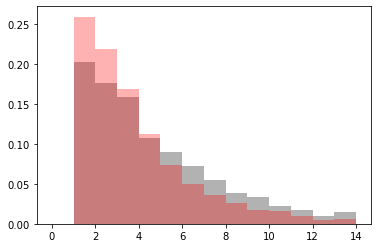

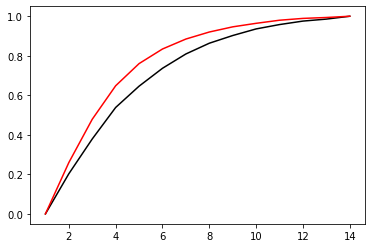

In [6]:
fig, ax = plt.subplots()
fig_cum, ax_cum = plt.subplots()
day = 0

ctrl_fw = []
for mouse in ctrl_mice:
    ctrl_fw.append(ctrl_field_mask_res[mouse][day]['fam']['field_widths'])
ctrl_fw = np.concatenate(ctrl_fw)

hist, bins, _ = ax.hist(ctrl_fw, bins = np.arange(15), color='black', alpha = .3, density=True)
ax_cum.plot(bins[1:], np.cumsum(hist), color= 'black')

ko_fw = []
for mouse in ko_mice:
    ko_fw.append(ko_field_mask_res[mouse][day]['fam']['field_widths'])
ko_fw = np.concatenate(ko_fw)

hist, bins, _ = ax.hist(ko_fw, bins = np.arange(15), color = 'red', alpha = .3,density=True)
print(hist)


ax_cum.plot(bins[1:], np.cumsum(hist), color='red')

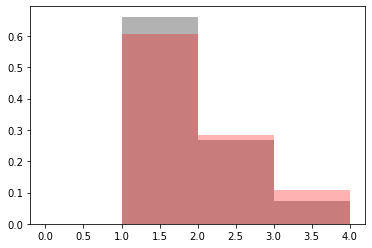

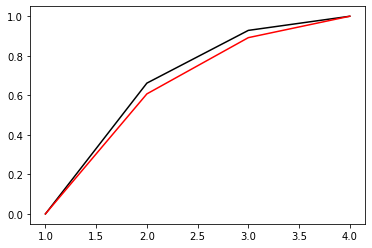

In [7]:
fig, ax = plt.subplots()
fig_cum, ax_cum = plt.subplots()
day = 0

ctrl_fw = []
for mouse in ctrl_mice:
    ctrl_fw.append(ctrl_field_mask_res[mouse][day]['fam']['num_fields'])
ctrl_fw = np.concatenate(ctrl_fw)

hist, bins, _ = ax.hist(ctrl_fw[ctrl_fw>0], bins = np.arange(5), color='black', alpha = .3, density=True)
ax_cum.plot(bins[1:], np.cumsum(hist), color='black')

ko_fw = []
for mouse in ko_mice:
    ko_fw.append(ko_field_mask_res[mouse][day]['fam']['num_fields'])
ko_fw = np.concatenate(ko_fw)

hist, bins, _ = ax.hist(ko_fw[ko_fw>0], bins = np.arange(5), color = 'red', alpha = .3,density=True)
ax_cum.plot(bins[1:], np.cumsum(hist), color='red')

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '22_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '22_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}


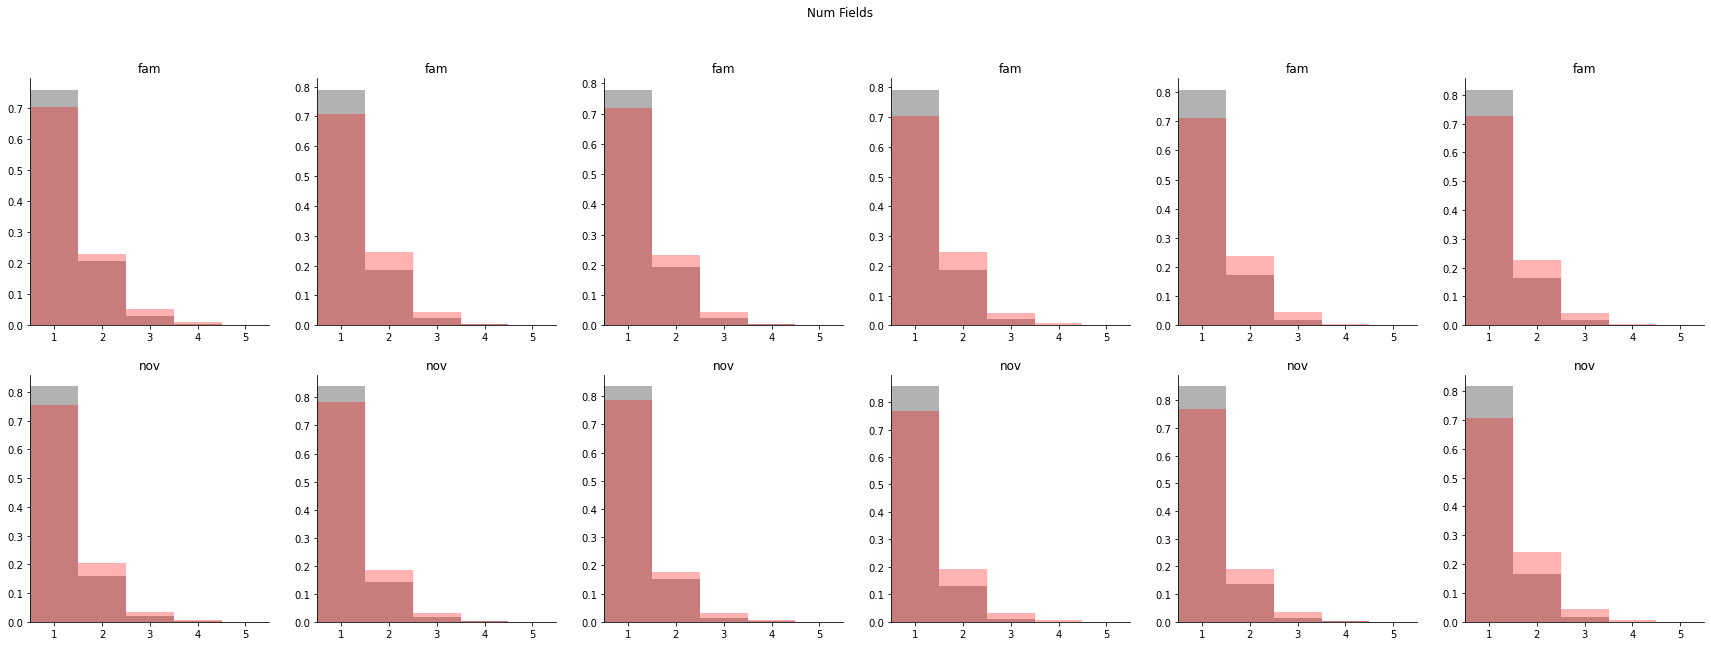

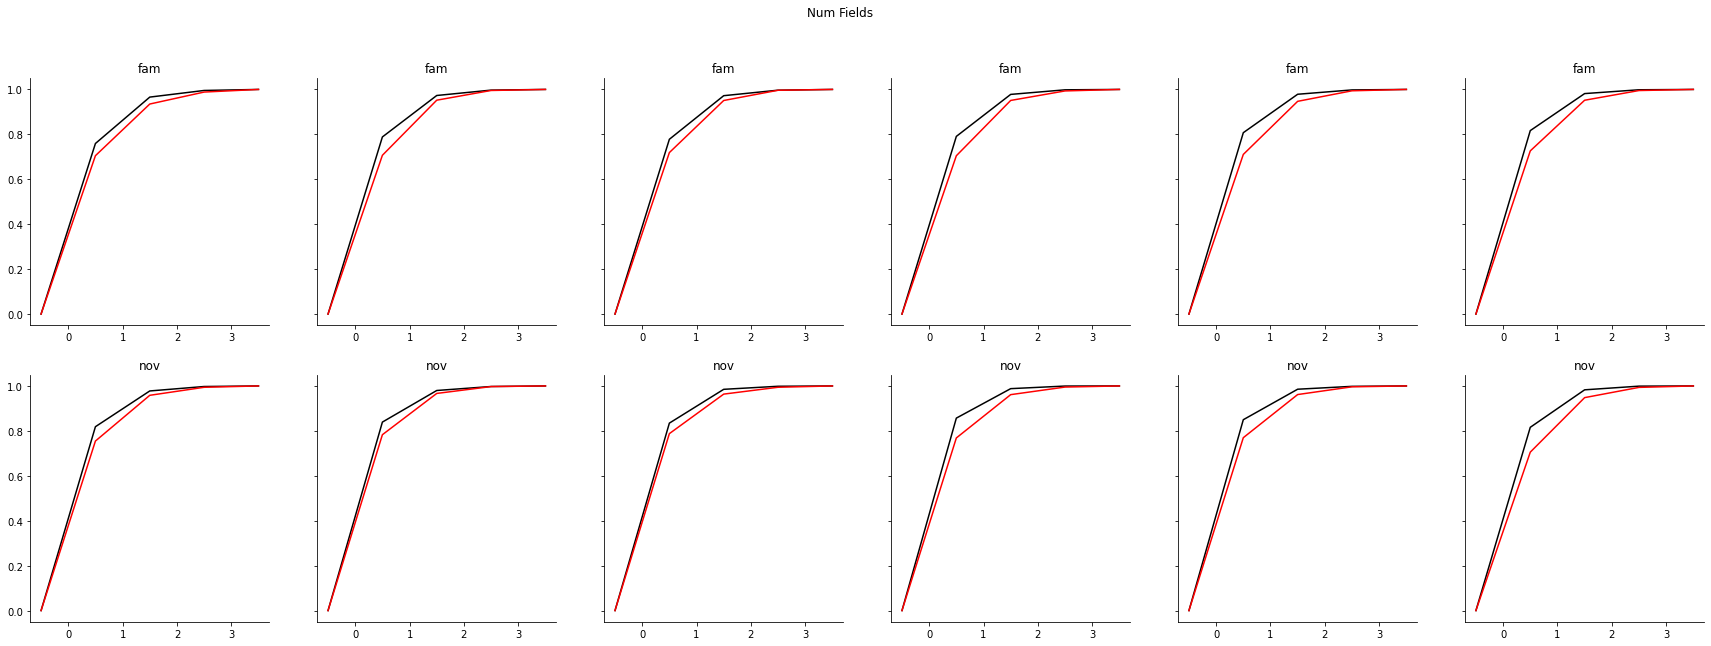

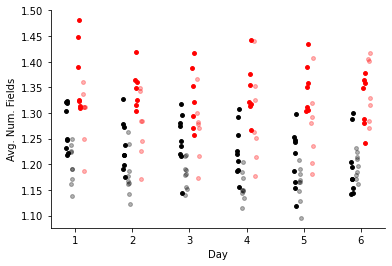

In [6]:
fig, ax = plt.subplots(2,6, figsize=[30,10])
fig_cum, ax_cum = plt.subplots(2,6, figsize=[30,10],sharey=True)

fig_scat, ax_scat = plt.subplots()
df = pd.DataFrame({'ko': [],
                   'day': [],
                   'day_norm': [],
                   'nov': [],
                   'num_fields' : [],
                   'mouse': [], 
                   'ko_x_day': [],
                   'ko_x_nov': [],
                   'nov_x_day': [],
                   'speed': [],
                   'intercept': []})

days_z = sp.stats.zscore(np.arange(6))
for row, novkey in enumerate([ 'fam', 'nov']):
    for day in range(6):

        ctrl_fw = []
        ctrl_mu = []
        for mouse in ctrl_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
#             dat = ctrl_field_mask_res[mouse][day][novkey]['num_fields']
            fm = ctrl_field_mask_res[mouse][day][novkey]['field_mask'] 
            rising_mask, falling_mask = fm[1:, :]>fm[:-1, :], fm[:-1, :]>fm[1:, :]
            rising_mask[0,:]= False
            falling_mask[-1,:] = False
            rising, falling = rising_mask.sum(axis=0), falling_mask.sum(axis=0)
#             rising, falling = (fm[1:, :]>fm[:-1, :]).sum(axis=0), (fm[:-1, :]>fm[1:, :]).sum(axis=0)
            dat = np.minimum(rising, falling)
            
#             r,f  = ctrl_field_mask_res[mouse][day][novkey]['rising_edges'], ctrl_field_mask_res[mouse][day][novkey]['falling_edges']
#             border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
#             r, f = r[~border_cells,:], f[~border_cells,:]
#             dat = np.minimum(r, f)
            
# #             dat = f[:,1]-r[:,1]
            
            
            ctrl_fw.append(dat[dat>0])
            df = df.append({'ko': 0, 
                            'day': day,
                            'day_norm': (day + 1)/6., #days_z[day], 
                            'nov': row, 
                            'num_fields': dat[dat>0].mean(), 
                            'mouse': mouse,
                            'ko_x_day': 0,
                            'ko_x_nov': 0,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ctrl_mu.append(dat[dat>0].mean())
        ctrl_fw = np.concatenate(ctrl_fw)

        hist, bins, _ = ax[row,day].hist(ctrl_fw, bins = np.arange(-0.5,5,1), color='black', alpha = .3, density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='black')
       
        ax[row,day].set_title(novkey)
        ax_cum[row,day].set_title(novkey)
        ax[row,day].spines['top'].set_visible(False)
        ax[row,day].spines['right'].set_visible(False)
        ax[row,day].set_xlim([.5,5.5])
        ax_cum[row,day].spines['top'].set_visible(False)
        ax_cum[row,day].spines['right'].set_visible(False)
        
        
        ctrl_mu = np.array(ctrl_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(-1,-.8, num=ctrl_mu.shape[0]), ctrl_mu, color='black', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(-.5,-.3, num=ctrl_mu.shape[0]), ctrl_mu, color='black', alpha = .3, s=15)

        ko_fw = []
        ko_mu = []
        for mouse in ko_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
#             dat = ko_field_mask_res[mouse][day][novkey]['num_fields']
            fm = ko_field_mask_res[mouse][day][novkey]['field_mask'] 
            rising_mask, falling_mask = fm[1:, :]>fm[:-1, :], fm[:-1, :]>fm[1:, :]
            rising_mask[0,:]= False
            falling_mask[-1,:] = False
            rising, falling = rising_mask.sum(axis=0), falling_mask.sum(axis=0)
#             rising, falling = (fm[1:, :]>fm[:-1, :]).sum(axis=0), (fm[:-1, :]>fm[1:, :]).sum(axis=0)
            dat = np.minimum(rising, falling)
            
#             r,f  = ko_field_mask_res[mouse][day][novkey]['rising_edges'], ko_field_mask_res[mouse][day][novkey]['falling_edges']
#             border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
#             r, f = r[~border_cells,:], f[~border_cells,:]
#             dat = np.minimum(r, f)
            
#             dat = (fm[1:, :]>fm[:-1, :]).sum(axis=0)
            ko_fw.append(dat[dat>0])
            df = df.append({'ko': 1, 
                            'day': day,
                            'day_norm': (day+1)/6., 
                            'nov': row, 
                            'num_fields': dat[dat>0].mean(), 
                            'mouse': mouse,
                            'ko_x_day': (day+1)/6.,
                            'ko_x_nov': row,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ko_mu.append(dat[dat>0].mean())
        ko_fw = np.concatenate(ko_fw)
        ko_mu = np.array(ko_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(.3,.5, num=ko_mu.shape[0]), ko_mu, color='red', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(.8,1, num=ko_mu.shape[0]), ko_mu, color='red', alpha = .3, s=15)
        

        hist, bins, _ = ax[row,day].hist(ko_fw, bins = np.arange(-0.5,5,1), color = 'red', alpha = .3,density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='red')
        
fig.suptitle("Num Fields")
fig_cum.suptitle("Num Fields")

ax_scat.set_ylabel('Avg. Num. Fields')
ax_scat.set_xlabel('Day')
ax_scat.set_xticks([6*day for day in range(6)])
ax_scat.set_xticklabels(np.arange(1,7))
ax_scat.spines['top'].set_visible(False)
ax_scat.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir,"num_sig_fields_hist.pdf"))
fig_cum.savefig(os.path.join(figdir,"num_sig_fields_cumhist.pdf"))
fig_scat.savefig(os.path.join(figdir,"num_sig_fields_summary.pdf"))

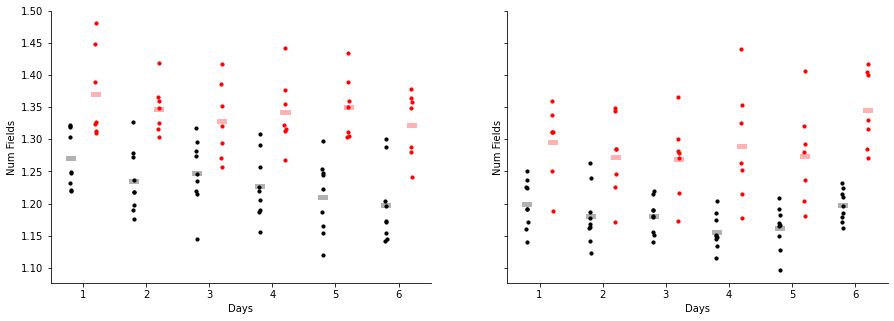

In [8]:
fig, ax = plt.subplots(1,2, figsize=[15,5],sharey=True)

s=10
lw =5
for day in range(6):
    mask = (df['ko']==0) & (df['day']==day) & (df['nov']==0)
    frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
    ax[0].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), frac, color = 'black', s=s)
    ax[0].plot(5*day  -1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    mask = (df['ko']==0) & (df['day']==day) & (df['nov']==1)
    frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
    ax[1].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), frac, color = 'black', s=s,alpha = 1)
    ax[1].plot(5*day  -1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    
    mask = (df['ko']==1) & (df['day']==day) & (df['nov']==0)
    frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
    ax[0].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(ko_mice)), frac, color = 'red', s=s)
    ax[0].plot(5*day  +1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3)
    
    mask = (df['ko']==1) & (df['day']==day) & (df['nov']==1)
    frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
    ax[1].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(ko_mice)), frac, color = 'red', s=s, alpha = 1)
    ax[1].plot(5*day  +1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3)
    

for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xlabel('Days')
    ax[a].set_ylabel("Num Fields")
    ax[a].set_xticks(5*np.arange(6))
    ax[a].set_xticklabels(np.arange(1,7))
    
fig.savefig(os.path.join(figdir,"num_sig_fields_summary.pdf"))

-6.749336163504605 9.3292147232694e-06
-3.3343135813572675 0.0008551019694724832


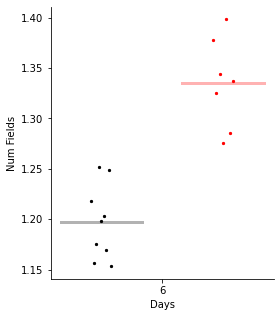

In [17]:
fig, ax = plt.subplots(figsize=[4,5],sharey=True)


day =5
mask = (df['ko']==0) & (df['day']==day) 
ctrl_frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
ax.scatter(5*day-.3 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), ctrl_frac, color = 'black', s=5)
ax.plot(5*day  -.3 + np.array([-0.2,0.2]), ctrl_frac.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)

mask = (df['ko']==1) & (df['day']==day) 
ko_frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
ax.scatter(5*day+.3 + np.linspace(-0.05,0.05, num = len(ko_mice)), ko_frac, color = 'red', s=5)
ax.plot(5*day  +.3 + np.array([-0.2,0.2]), ko_frac.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)


t,p = sp.stats.ttest_ind(ctrl_frac,ko_frac)
print(t,p)
t,p = sp.stats.ranksums(ctrl_frac,ko_frac)
print(t,p)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Days')
ax.set_ylabel("Num Fields")
ax.set_xticks(5*np.arange(5,6))
ax.set_xticklabels(np.arange(6,7))
    
fig.savefig(os.path.join(figdir,"num_sig_fields_summary_short.pdf"))

In [10]:
res = mixed_anova(data = df[df['nov']==0], dv= 'num_fields', between = 'ko', within = 'day', subject = 'mouse')
print(res)
print(res['p-unc'].iloc[0])
posthoc = pairwise_ttests(data = df[df['nov']==0], dv= 'num_fields', between = 'ko', within = 'day', subject = 'mouse', padjust='holm')
print(posthoc)

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0           ko  0.298594    1   14  0.298594  27.908340  0.000116  0.665938   
1          day  0.032943    5   70  0.006589   4.972955  0.000592  0.262108   
2  Interaction  0.008586    5   70  0.001717   1.296117  0.275539  0.084735   

        eps  
0       NaN  
1  0.677825  
2       NaN  
0.00011572197035229136
    Contrast  day    A    B Paired  Parametric         T        dof  \
0        day    -  0.0  1.0   True        True  2.709352  15.000000   
1        day    -  0.0  2.0   True        True  2.507658  15.000000   
2        day    -  0.0  3.0   True        True  2.799130  15.000000   
3        day    -  0.0  4.0   True        True  2.815911  15.000000   
4        day    -  0.0  5.0   True        True  3.708344  15.000000   
5        day    -  1.0  2.0   True        True  0.137195  15.000000   
6        day    -  1.0  3.0   True        True  0.619554  15.000000   
7        day    -  1.0  4.0   True  

In [29]:
res = mixed_anova(data = df[df['nov']==1], dv= 'num_fields', between = 'ko', within = 'day', subject = 'mouse')
print(res)
print(res['p-unc'].iloc[0])

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0           ko  0.297436    1   14  0.297436  43.886574  0.000011  0.758148   
1          day  0.031782    5   70  0.006356   3.371559  0.008712  0.194085   
2  Interaction  0.011715    5   70  0.002343   1.242750  0.298618  0.081531   

        eps  
0       NaN  
1  0.589529  
2       NaN  
1.1423281353803488e-05


In [17]:
lmm_res = MixedLM(df['num_fields'], df[['ko', 
                                        'day', 
                                        'nov', 
                                        'ko_x_nov', 
                                        'ko_x_day',
                                        'nov_x_day',
                                        'speed',
                                        'intercept']], df['mouse'], exog_re = df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: num_fields
No. Observations: 192     Method:             REML      
No. Groups:       16      Scale:              0.0018    
Min. group size:  12      Log-Likelihood:     303.0512  
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
ko             0.038    0.017  2.330 0.020  0.006  0.071
day           -0.010    0.003 -2.844 0.004 -0.017 -0.003
nov           -0.100    0.015 -6.750 0.000 -0.130 -0.071
ko_x_nov      -0.001    0.012 -0.080 0.936 -0.025  0.023
ko_x_day       0.042    0.027  1.574 0.115 -0.010  0.094
nov_x_day      0.069    0.021  3.231 0.001  0.027  0.111
speed         -0.479    0.064 -7.507 0.000 -0.605 -0.354
intercept      1.417    0.022 63.896 0.00

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '22_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '22_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}


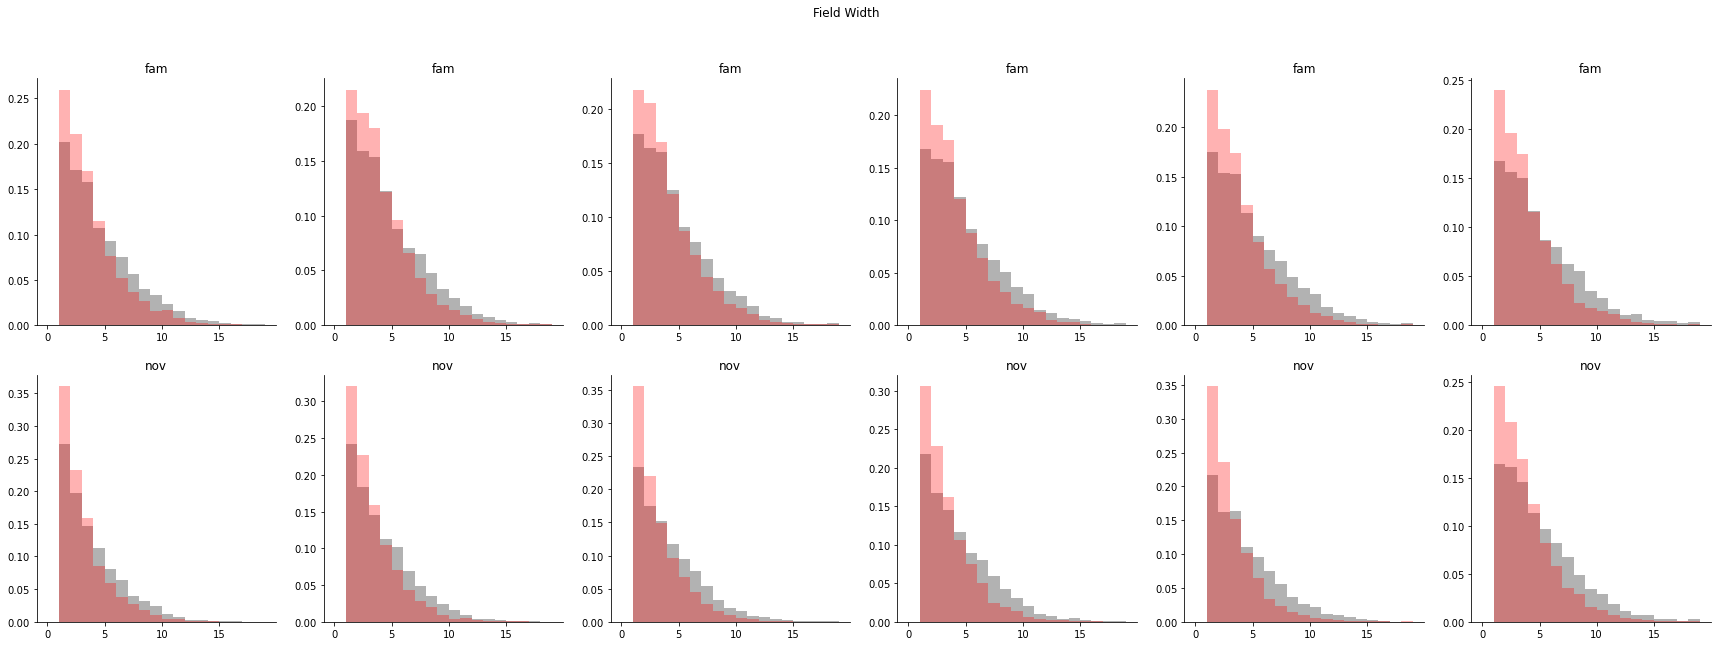

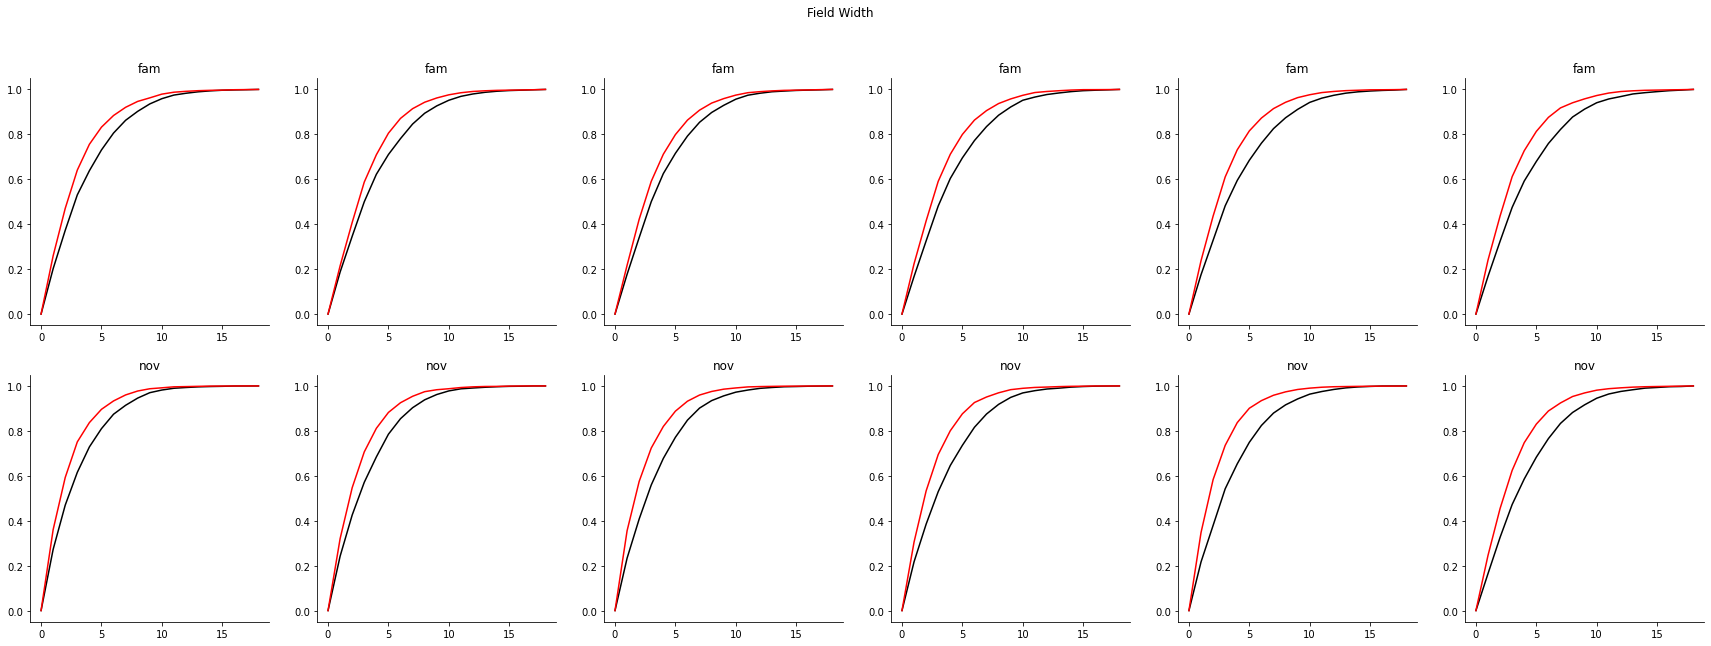

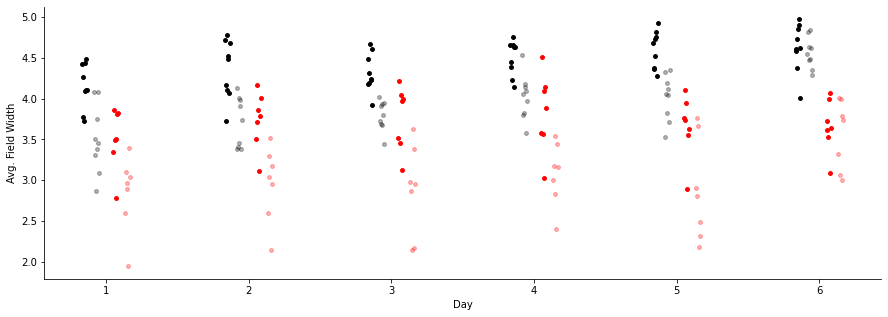

In [22]:
fig, ax = plt.subplots(2,6, figsize=[30,10])
fig_cum, ax_cum = plt.subplots(2,6, figsize= [30,10])
fig_scat, ax_scat = plt.subplots( figsize= [15,5], sharey=True)
df = pd.DataFrame({'ko': [],
                   'day': [],
                   'nov': [],
                   'fw' : [],
                   'mouse': [],
                   'ko_x_day': [],
                   'ko_x_nov': [],
                   'nov_x_day': [],
                   'speed': [],
                   'intercept': []})
days_z = sp.stats.zscore(np.arange(6))
for row, novkey in enumerate([ 'fam', 'nov']):
    for day in range(6):

        ctrl_fw = []
        ctrl_mu = []
        for mouse in ctrl_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
            r,f  = ctrl_field_mask_res[mouse][day][novkey]['rising_edges'], ctrl_field_mask_res[mouse][day][novkey]['falling_edges']
            border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
            r, f = r[~border_cells,:], f[~border_cells,:]
            
            dat = f[:,1]-r[:,1]
#             print(dat)
            ctrl_fw.append(dat[dat>0])
            df = df.append({'ko': 0, 
                            'day': (day+1)/6.,
                            'nov': row, 
                            'fw': dat[dat>0].mean(), 
                            'mouse': mouse, 
                            'ko_x_day': 0,
                            'ko_x_nov': 0,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ctrl_mu.append(dat[dat>0].mean())
        ctrl_fw = np.concatenate(ctrl_fw)

        
        hist, bins, _ = ax[row,day].hist(ctrl_fw, bins = np.arange(0,20), color='black', alpha = .3, density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='black')
       
        ax[row,day].set_title(novkey)
        ax_cum[row,day].set_title(novkey)
        ax[row,day].spines['top'].set_visible(False)
        ax[row,day].spines['right'].set_visible(False)
        ax_cum[row,day].spines['top'].set_visible(False)
        ax_cum[row,day].spines['right'].set_visible(False)
        
        
        ctrl_mu = np.array(ctrl_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(-1,-.8, num=ctrl_mu.shape[0]), ctrl_mu, color='black', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(-.5,-.3, num=ctrl_mu.shape[0]), ctrl_mu, color='black', alpha = .3, s=15)

        ko_fw = []
        ko_mu = []
        for mouse in ko_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
            r,f  = ko_field_mask_res[mouse][day][novkey]['rising_edges'], ko_field_mask_res[mouse][day][novkey]['falling_edges']
            border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
            r, f = r[~border_cells,:], f[~border_cells,:]
            
            dat = f[:,1]-r[:,1]
#             dat = ko_field_mask_res[mouse][day][novkey]['field_widths']
            ko_fw.append(dat[dat>0])
            df = df.append({'ko': 1, 
                            'day': (day+1)/6., 
                            'nov': row, 
                            'fw': dat[dat>0].mean(), 
                            'mouse': mouse, 
                            'ko_x_day': (day+1)/6.,
                            'ko_x_nov': row,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ko_mu.append(dat[dat>0].mean())
        ko_fw = np.concatenate(ko_fw)
        ko_mu = np.array(ko_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(.3,.5, num=ko_mu.shape[0]), ko_mu, color='red', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(.8,1, num=ko_mu.shape[0]), ko_mu, color='red', alpha = .3, s=15)
        

#         ax[row,day].hist(ko_fw, bins = np.arange(1,20), color = 'red', alpha = .3,density=True)
        hist, bins, _ = ax[row,day].hist(ko_fw, bins = np.arange(0,20), color = 'red', alpha = .3,density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='red')
        
fig.suptitle("Field Width")
fig_cum.suptitle("Field Width")

ax_scat.set_ylabel('Avg. Field Width')
ax_scat.set_xlabel('Day')
ax_scat.set_xticks([6*day for day in range(6)])
ax_scat.set_xticklabels(np.arange(1,7))
ax_scat.spines['top'].set_visible(False)
ax_scat.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir,"field_width_hist.pdf"))
fig_cum.savefig(os.path.join(figdir,"field_width_cumhist.pdf"))
fig_scat.savefig(os.path.join(figdir,"field_width_summary.pdf"))
        

In [24]:
# _df = df[df['speed']>.05]
# _df['speed'] = sp.stats.zscore(df['speed']._values)
lmm_res = MixedLM(df['fw'],  df[['ko', 
                                 'day', 
                                 'nov', 
                                 'ko_x_nov', 
                                 'ko_x_day',
                                 'nov_x_day',
                                 'speed',
                                 'intercept']], df['mouse'], exog_re = df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: fw      
No. Observations: 192     Method:             REML    
No. Groups:       16      Scale:              0.0509  
Min. group size:  12      Log-Likelihood:     -12.3144
Max. group size:  12      Converged:          Yes     
Mean group size:  12.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
ko          -0.100    0.089 -1.125 0.261 -0.275  0.075
day          0.366    0.136  2.700 0.007  0.100  0.632
nov         -0.756    0.080 -9.478 0.000 -0.912 -0.600
ko_x_nov    -0.162    0.066 -2.460 0.014 -0.290 -0.033
ko_x_day    -0.389    0.183 -2.123 0.034 -0.748 -0.030
nov_x_day    0.559    0.114  4.886 0.000  0.335  0.784
speed        3.943    0.400  9.851 0.000  3.158  4.727
intercept    2.889    0.138 20.935 0.000  2.619  3.160
day Var      0.080 

### Field edge analysis

In [20]:
def field_shifts(mouse, day, fm_res, novkey, pcnt_th = .25, act_th = .25, plot = False):
    sess = u.load_single_day(mouse,day)
    
    ledge, redge = fm_res[mouse][day][novkey]['rising_edges'], fm_res[mouse][day][novkey]['falling_edges']
    

    border_cells = (ledge[:,1]==0) #+ (redge[:,1]>=28) > 0
    ledge, redge = ledge[~border_cells,:], redge[~border_cells,:]
    
#     arm_cells = .5*(redge[:,0]+ledge[:,0])>=0 #10
#     ledge,redge = ledge[arm_cells,:], redge[arm_cells,:]
#     ledge[:,1], redge[:,1] = np.maximum(ledge[:,1]-1,0), np.minimum(redge[:,1]+1,29) #np.maximum(ledge[:,1]-1,0), np.minimum(redge[:,1]+1,29)

    if novkey in ['fam']:
        trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
    else:
        trial_mask = sess.trial_info['LR']==sess.novel_arm
        
        
    shift = []
    form_lap_vel = []
    field_width = []
    form_lap = []
    field_var = []
    mean_speed = []
    for field in range(ledge.shape[0]):
        fieldmat = sess.trial_matrices['spks'][trial_mask,:,:][:,np.maximum(ledge[field,1],0):redge[field,1],ledge[field,0]]
        speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:][:,np.maximum(ledge[field,1],0):redge[field,1]],axis=1)
        fieldmat[np.isnan(fieldmat)]=1E-5
        activity_th = act_th*np.amax(fieldmat.ravel())
        fieldmat_th = np.amax(1*(fieldmat>activity_th), axis=1)
        formation_laps = fieldmat_th[:-4] * (sp.signal.convolve(fieldmat_th,np.ones([5,]), mode= 'valid')>=3) #(sp.ndimage.convolve1d(fieldmat_th, np.ones([5,]), mode='constant', cval = 0)>=1)
        if formation_laps.sum()>0:
            formation_lap = np.nonzero(formation_laps)[0][0]


            if fieldmat_th[formation_lap:].mean()>=pcnt_th and redge[field,1]-ledge[field,1]>=3: 


    #             form_lap_vel.append(np.nanmean(speed[np.maximum(formation_lap-1,0):formation_lap+2]))
                form_lap_vel.append(speed[formation_lap])
                mean_speed.append(np.nanmean(speed[formation_lap:]))
                form_lap.append(formation_lap)
                field_width.append(redge[field,1]-ledge[field,1])

                form_argmax = sp.ndimage.center_of_mass(fieldmat[formation_lap,:])[0] 
    #             form_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[np.maximum(formation_lap-1,0):formation_lap+2,:],axis=0))[0] 
    #             print(form_argmax, sp.ndimage.center_of_mass(fieldmat[formation_lap,:]))
                field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+1:,:], axis=0))[0]
    #             field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+2:,:], axis=0))[0] 

                shift.append(field_argmax-form_argmax)
        
                

                avg_act = np.nanmean(fieldmat[formation_lap:, :], axis=1)
                avg_act_norm = avg_act/np.nanmax(avg_act)
                field_var.append(np.nanvar(avg_act_norm))

                if plot:
                    fig, ax = plt.subplots(1,2, figsize= [10,5])
                    ax[0].imshow(sess.trial_matrices['spks'][trial_mask,:,:][:,:-1,ledge[field,0]], cmap ='magma')
#                     ax[0].vlines([ledge[field,1], redge[field,1]], 0, trial_mask.sum(), color= 'blue')
#                     ax[0].hlines(formation_lap, 0,30)
                    ax[0].scatter(form_argmax+ ledge[field,1],formation_lap,color='white',marker='*',s=20)
    
    
                    trial_argmax = np.array([sp.ndimage.center_of_mass(fieldmat[trial,:])[0] for trial in range(formation_lap+1,fieldmat.shape[0])])
                    ax[0].scatter(trial_argmax+ledge[field,1], np.arange(formation_lap+1,fieldmat.shape[0]),color='white',marker='*',s=20)
                    ax[0].vlines(field_argmax + ledge[field,1], 0 , trial_mask.sum(), color='red')
                    ax[0].set_title("%d" % field)

                    ax[1].imshow(sess.trial_matrices['spks'][trial_mask,:,:][:,:-1,ledge[field,0]], cmap ='magma')

                    mousedir = os.path.join(figdir, sess.mouse) 
                    os.makedirs(mousedir, exist_ok = True)
#                     fig.savefig(os.path.join(mousedir, "field_%d.pdf" % field))

    return {'shift': np.array(shift), 
            'formation_lap': np.array(form_lap), 
            'width': np.array(field_width), 
            'init_speed': np.array(form_lap_vel),
            'speed': np.array(mean_speed),
            'field_var': np.array(field_var)}

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


<ipython-input-20-90c205027790>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2, figsize= [10,5])
<ipython-input-20-90c205027790>:28: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:][:,np.maximum(ledge[field,1],0):redge[field,1]],axis=1)


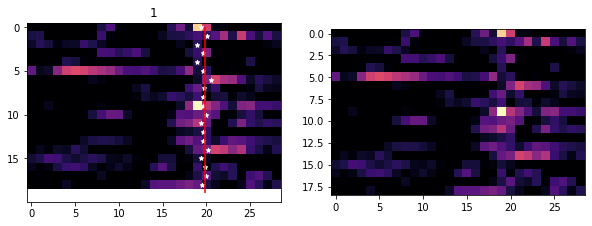

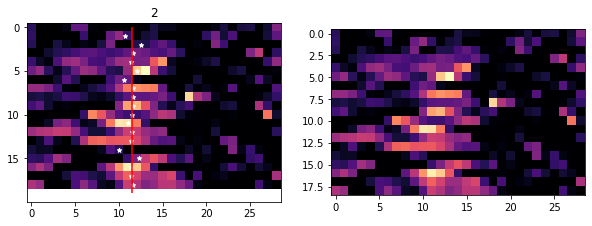

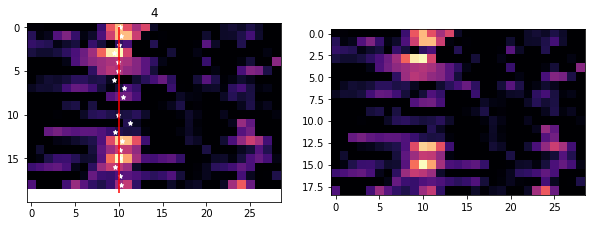

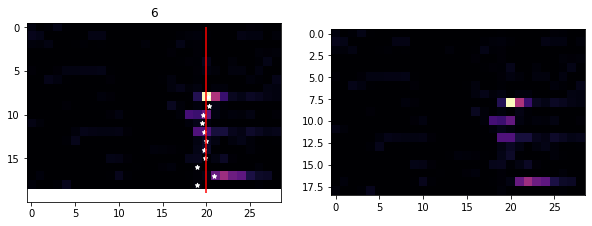

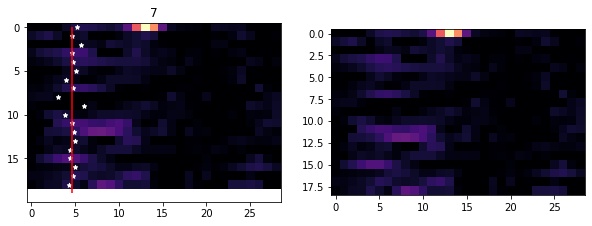

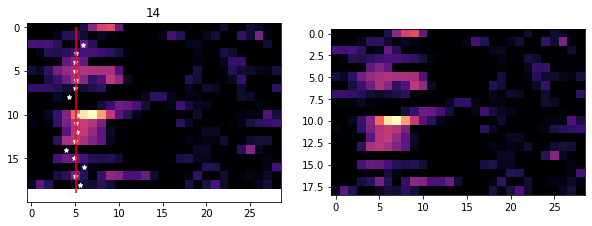

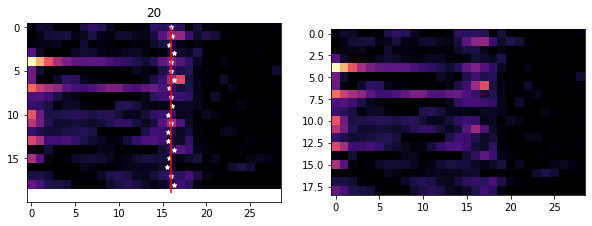

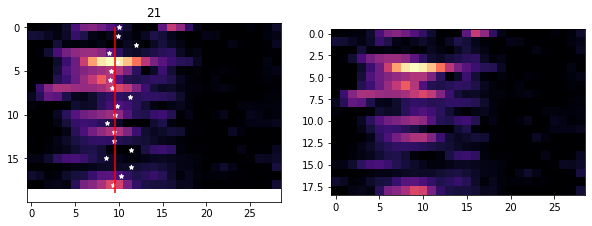

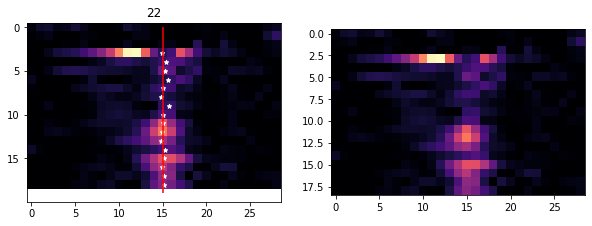

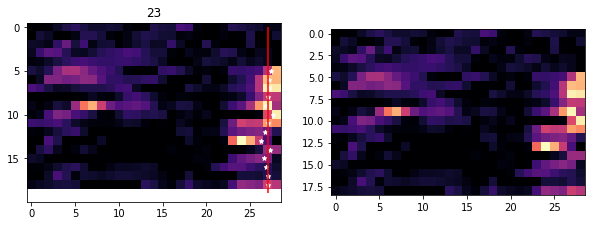

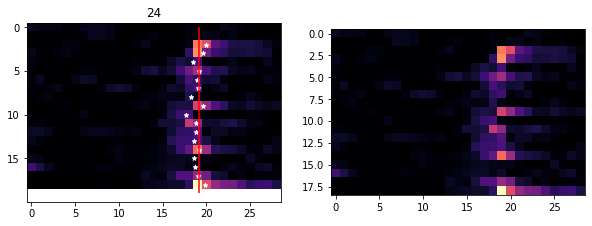

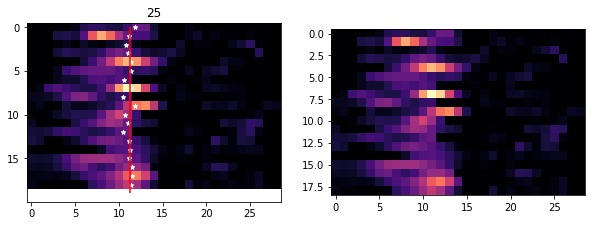

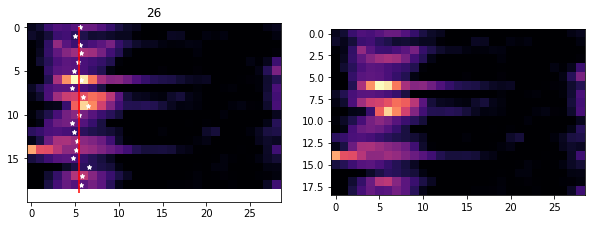

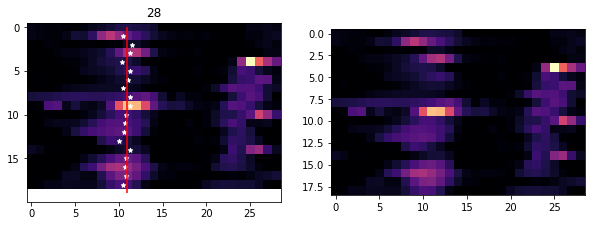

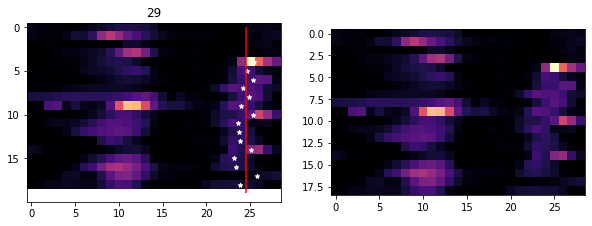

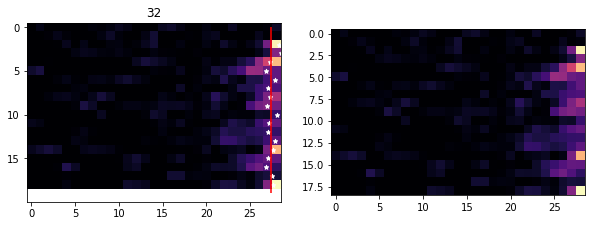

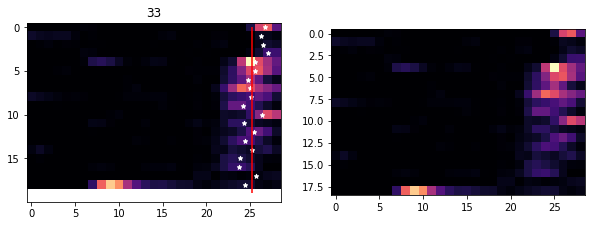

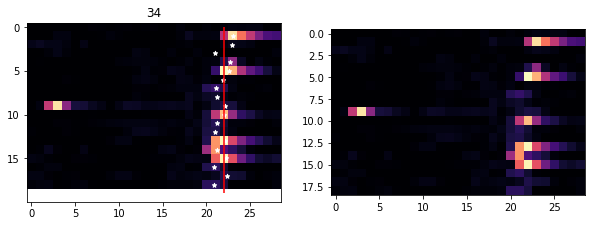

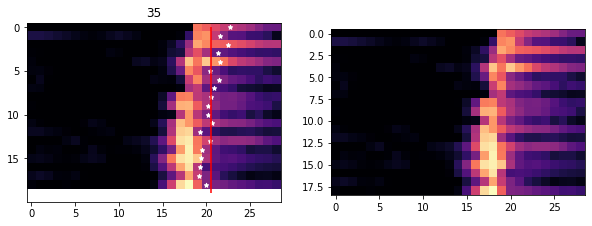

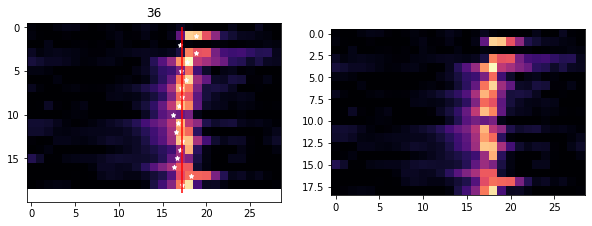

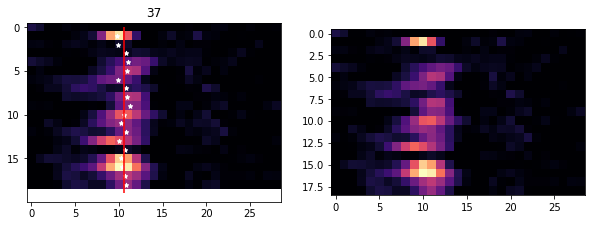

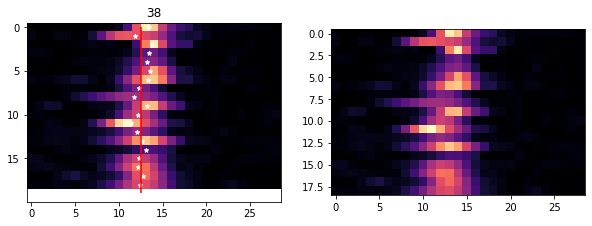

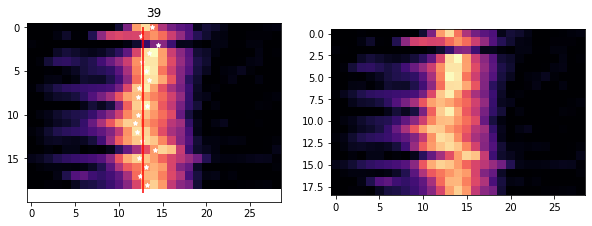

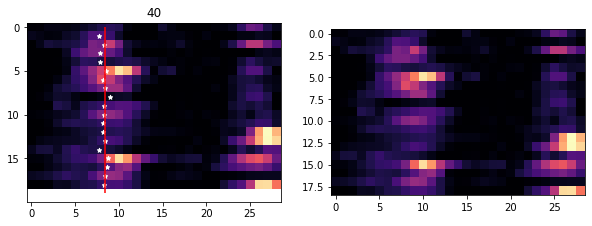

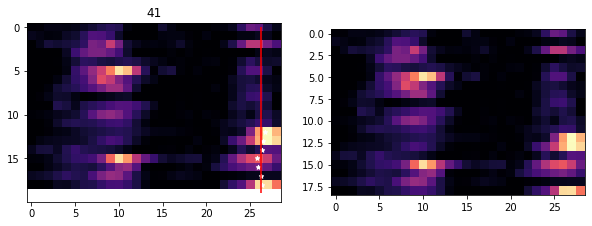

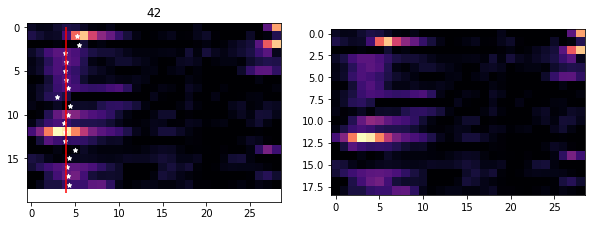

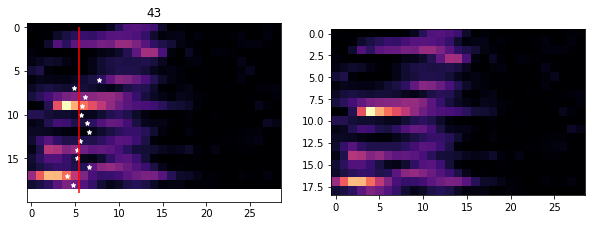

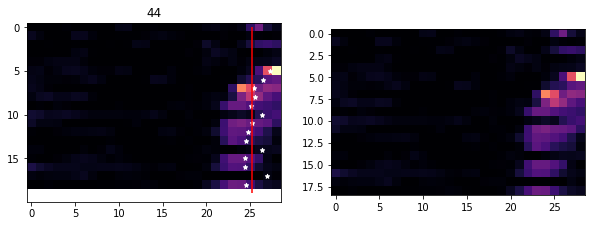

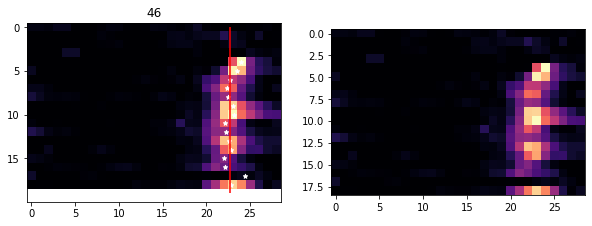

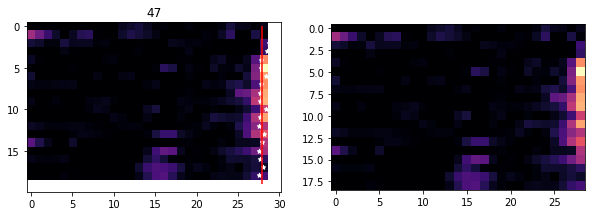

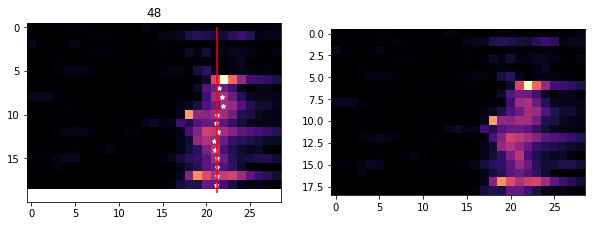

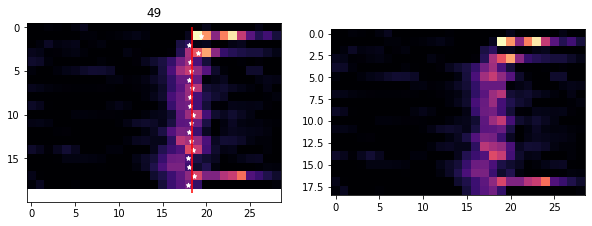

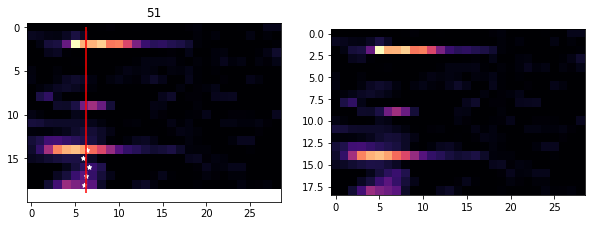

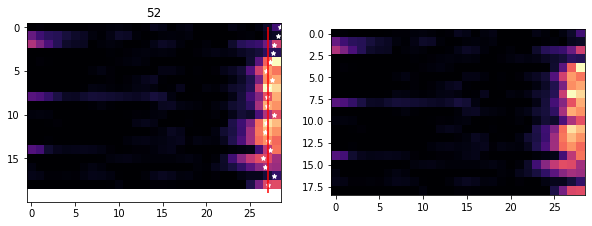

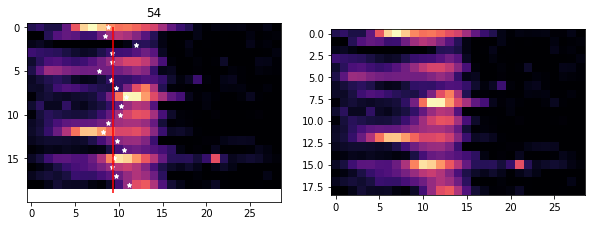

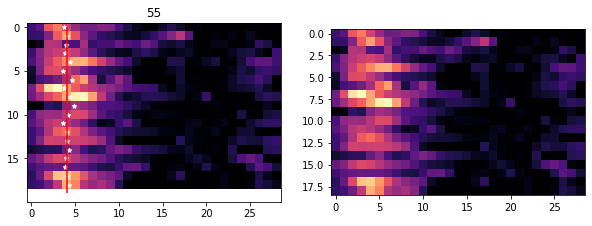

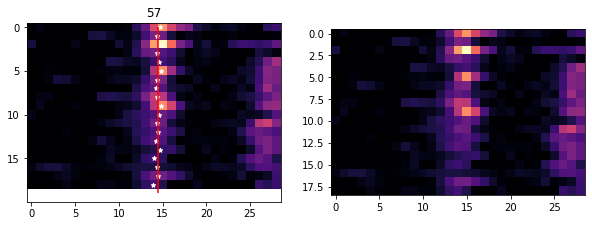

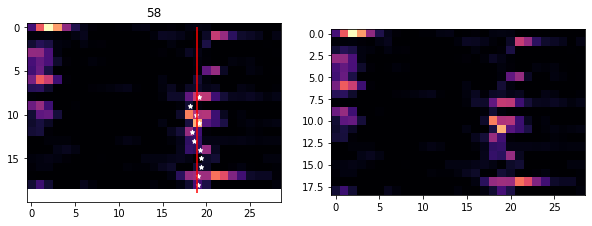

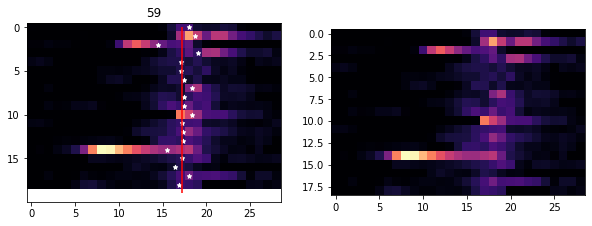

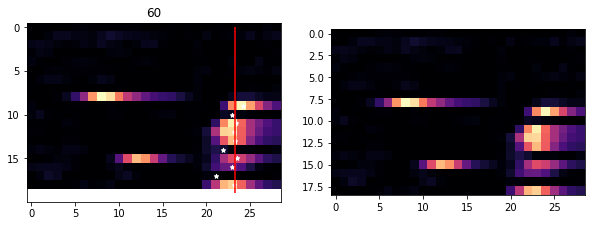

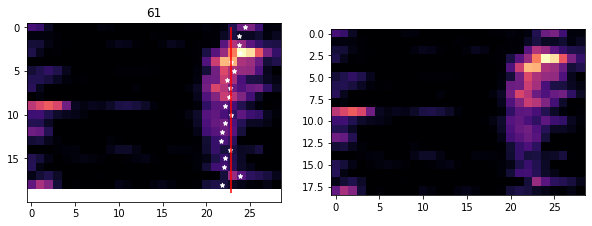

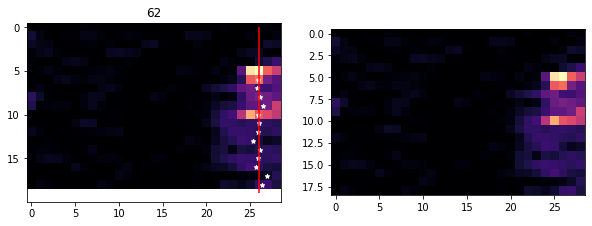

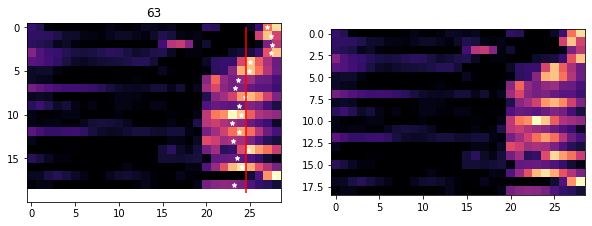

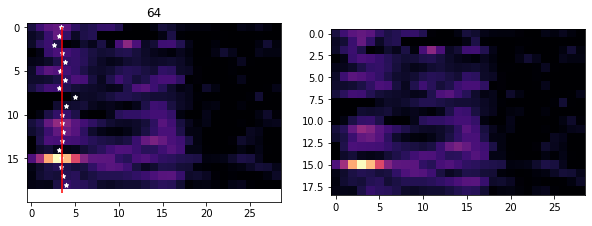

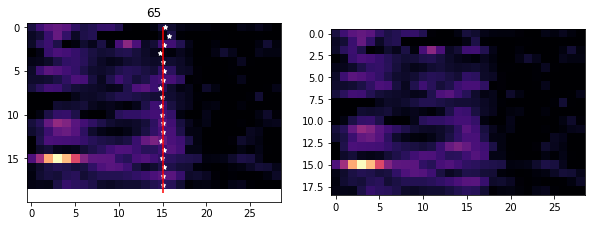

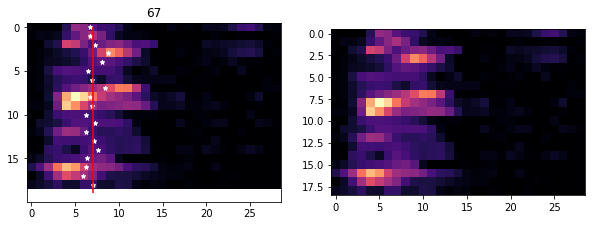

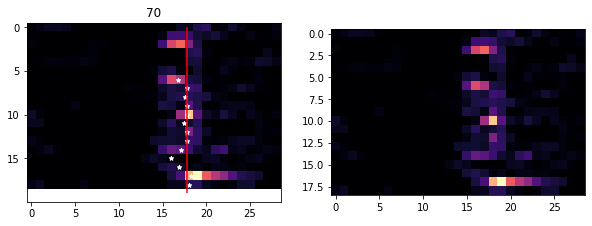

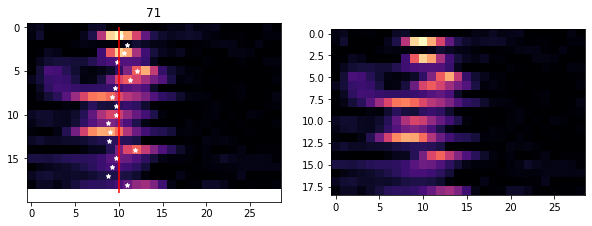

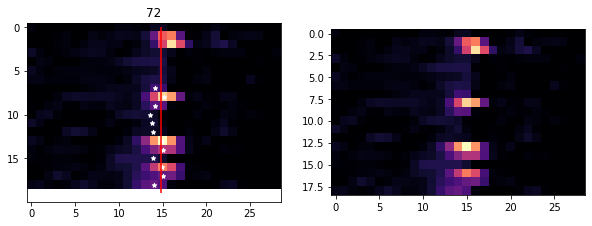

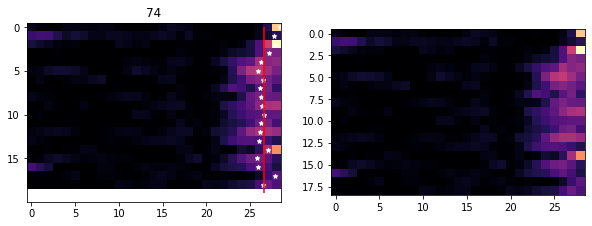

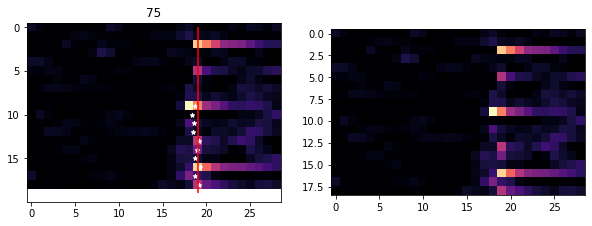

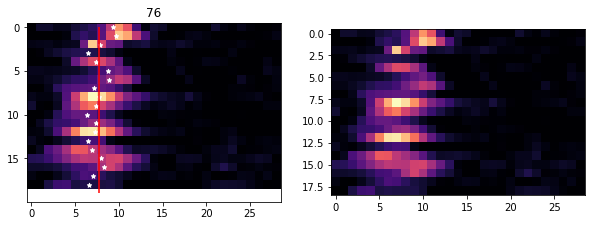

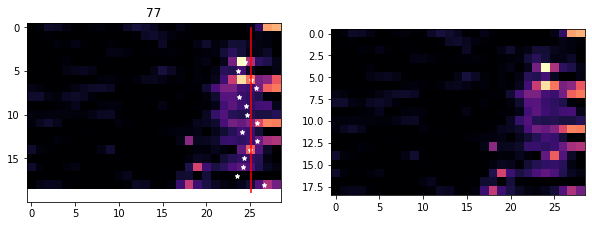

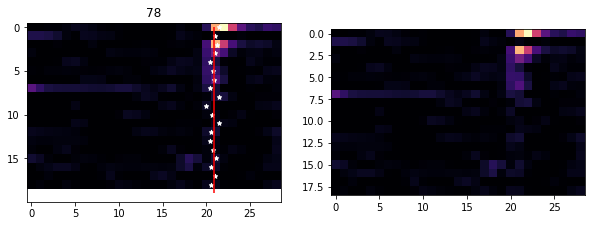

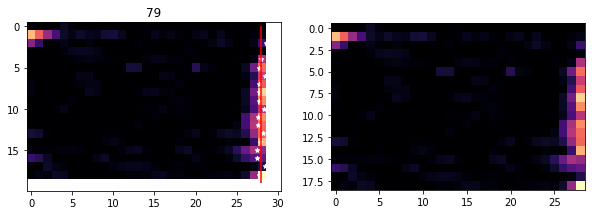

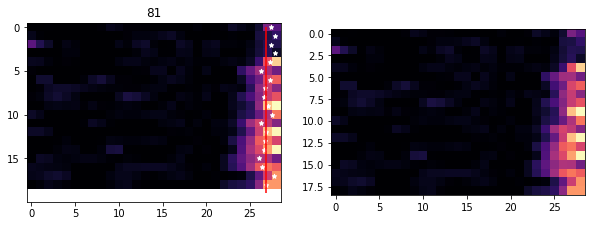

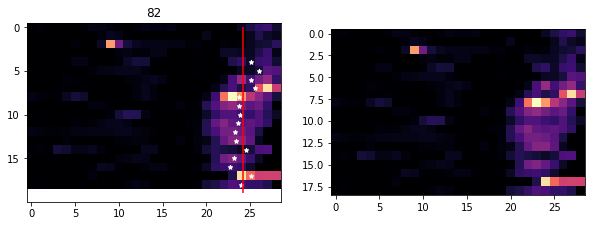

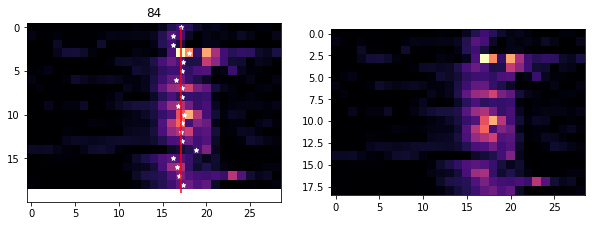

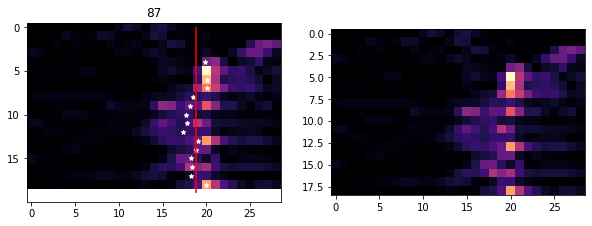

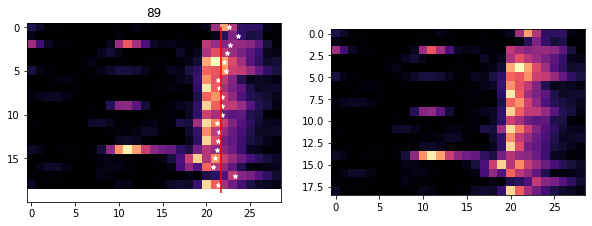

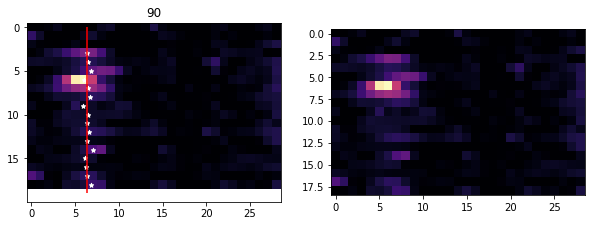

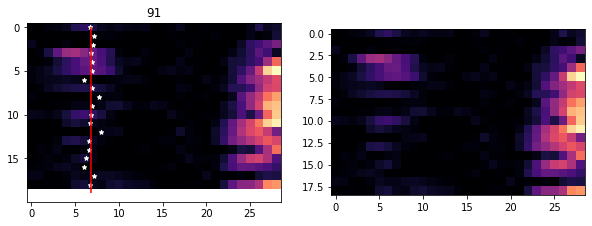

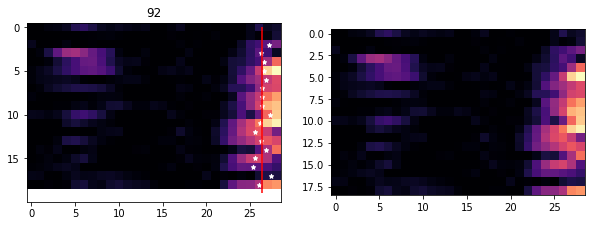

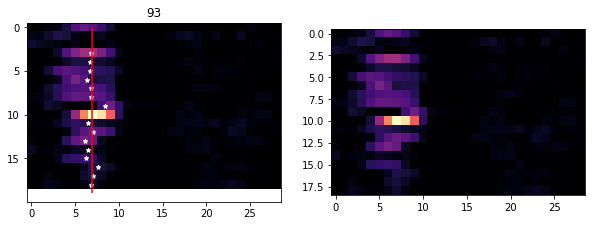

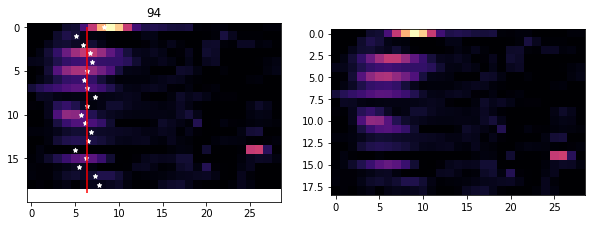

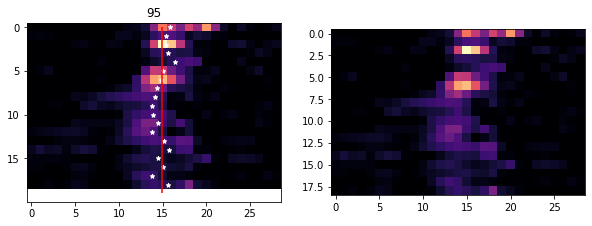

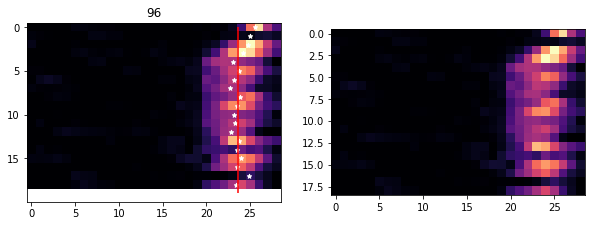

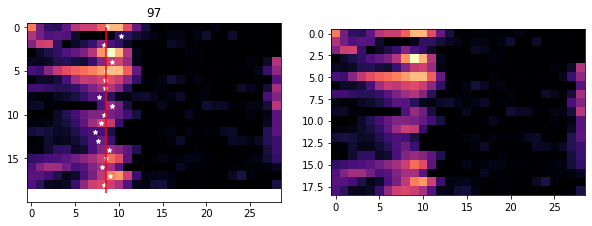

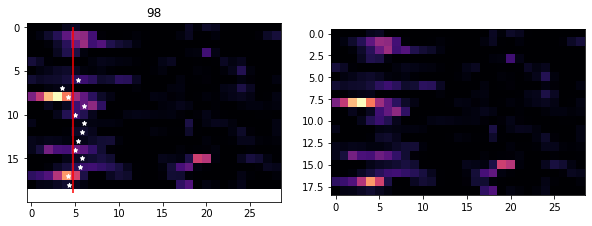

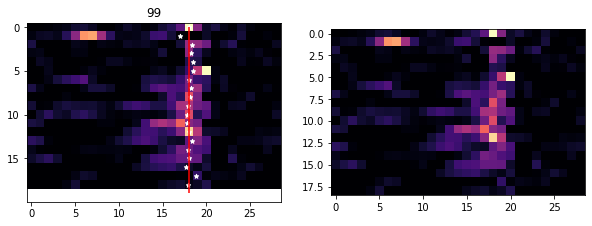

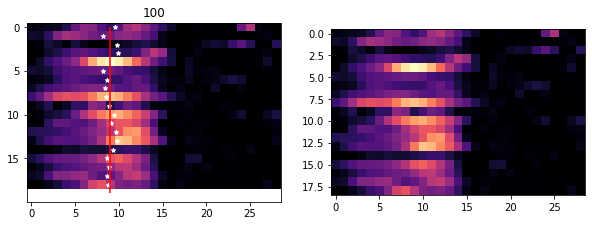

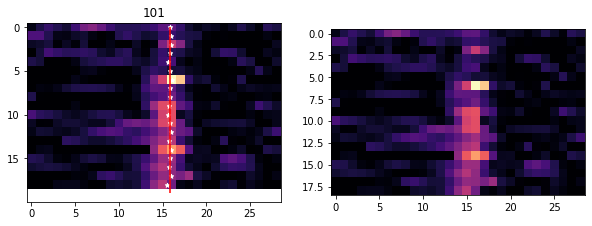

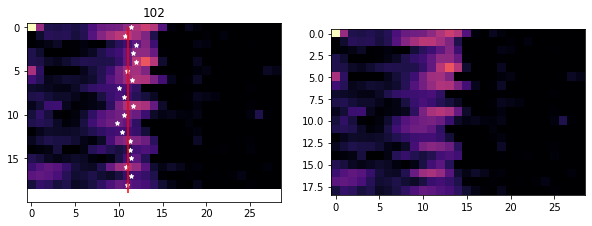

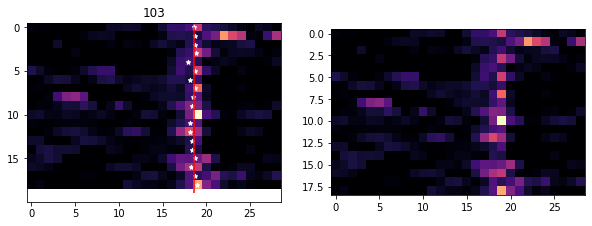

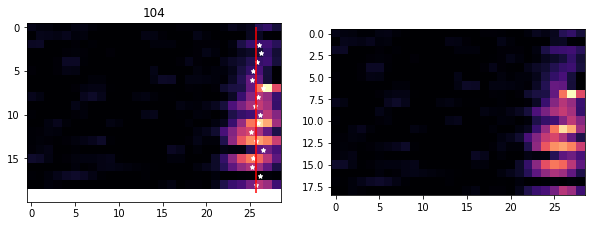

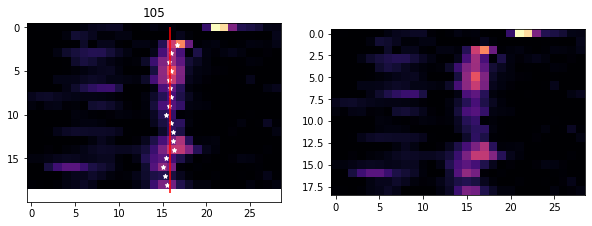

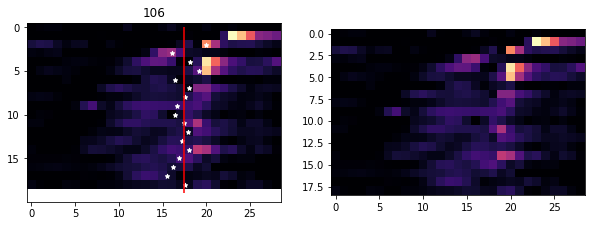

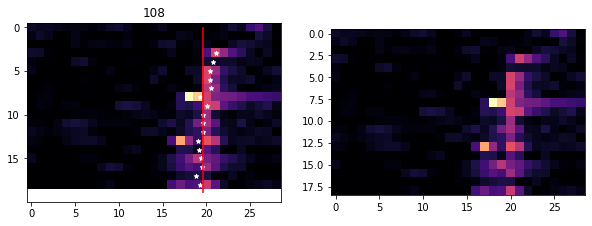

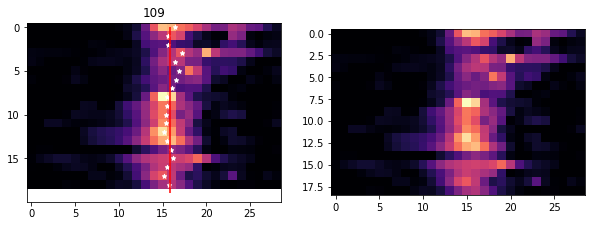

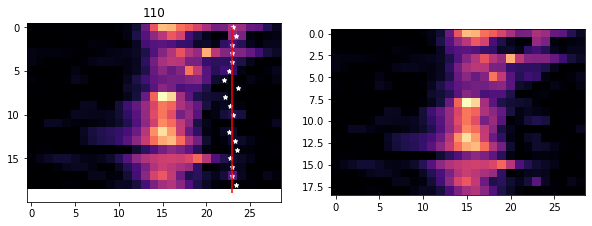

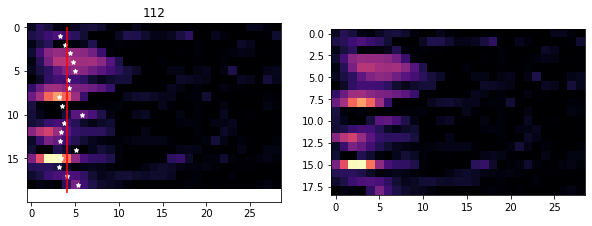

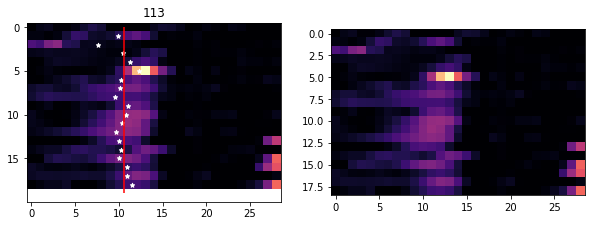

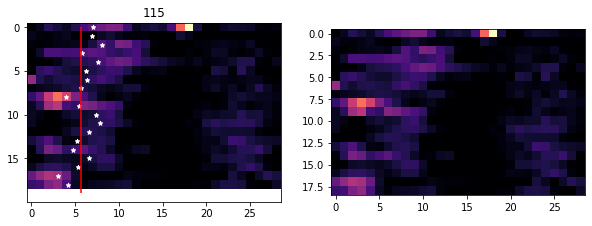

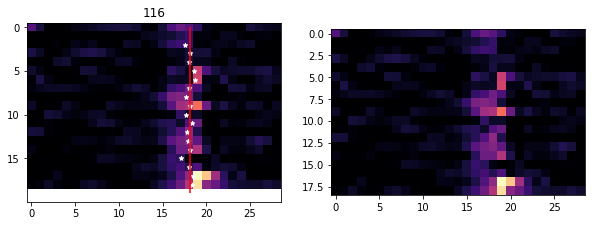

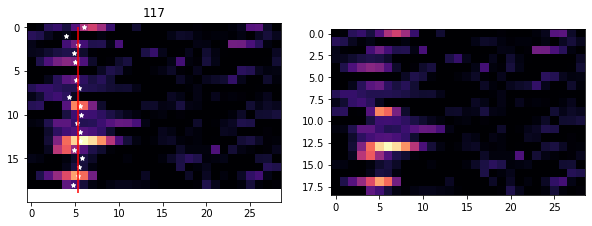

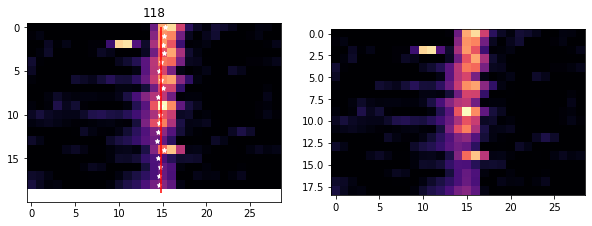

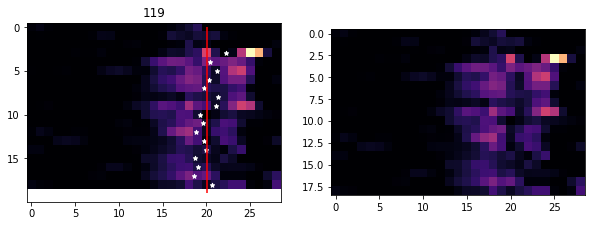

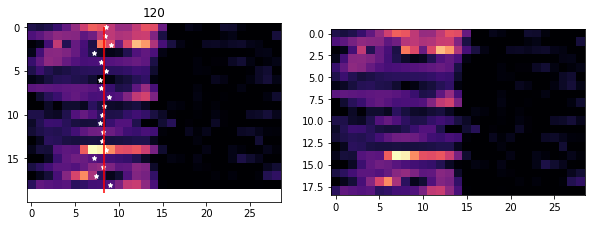

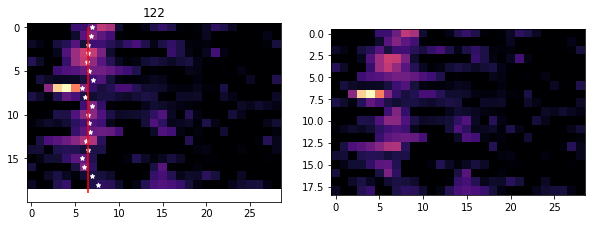

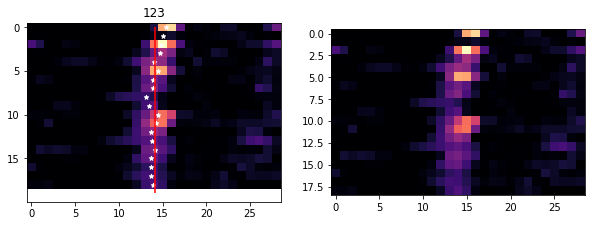

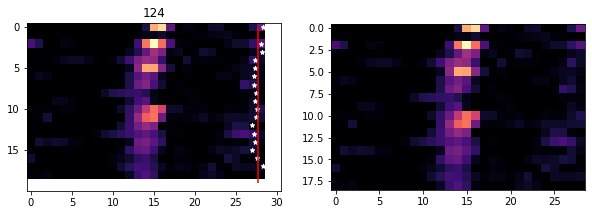

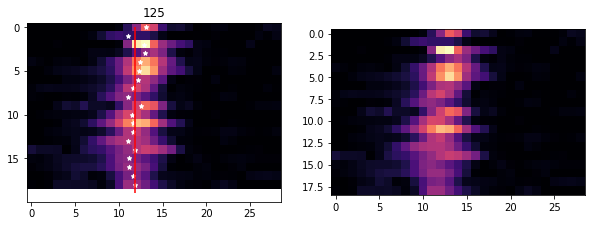

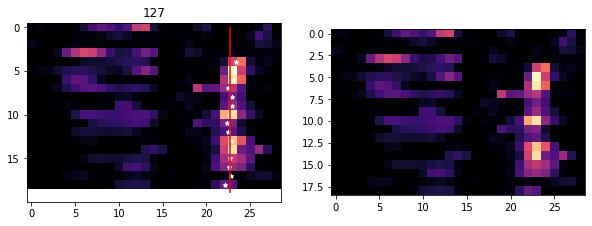

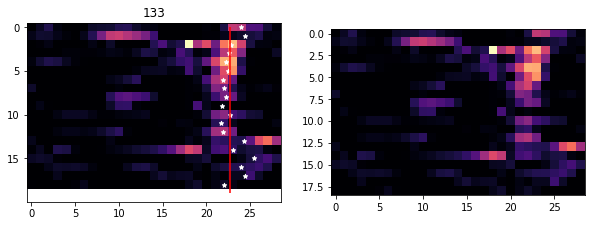

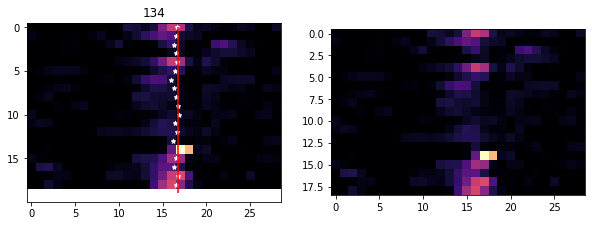

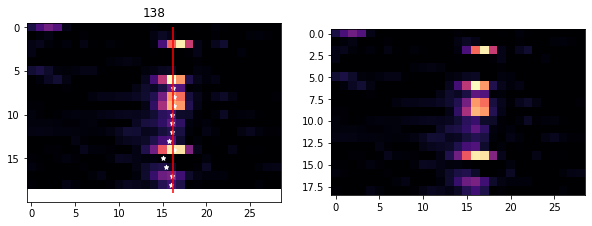

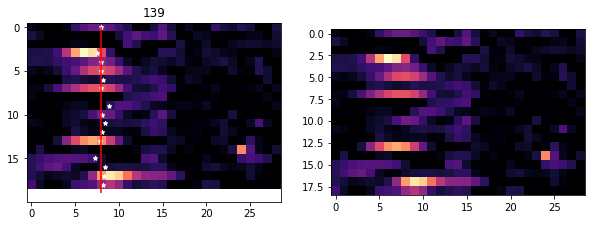

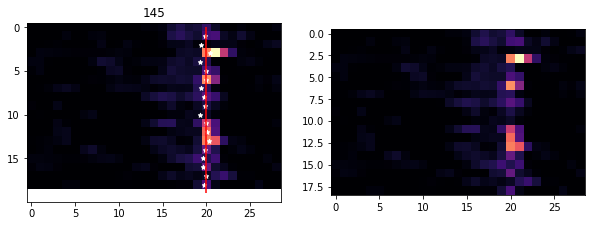

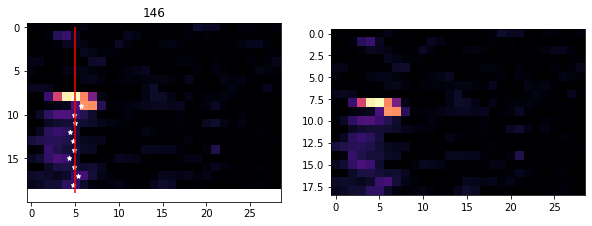

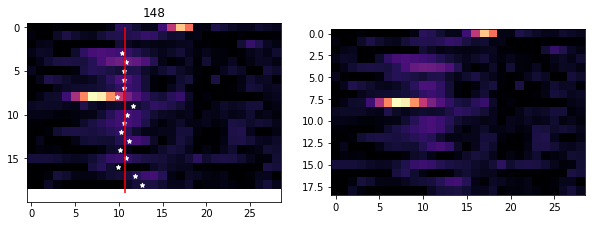

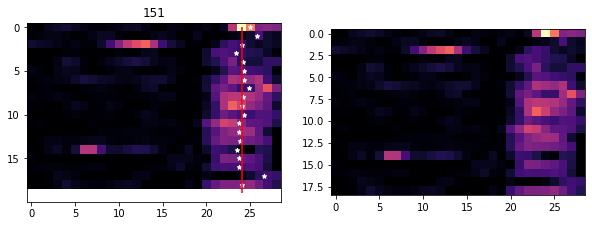

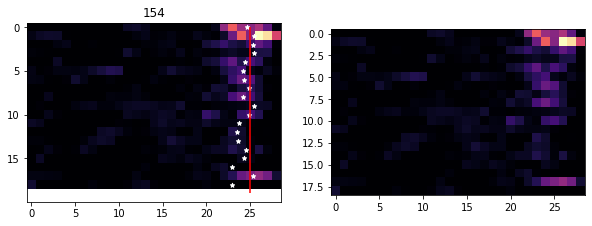

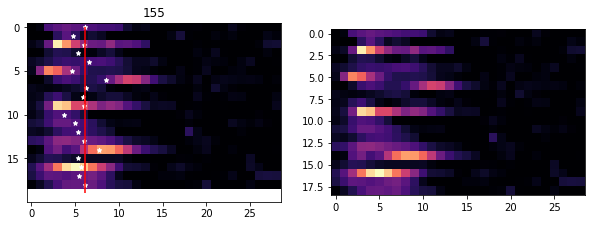

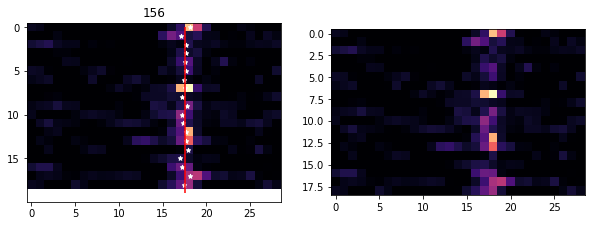

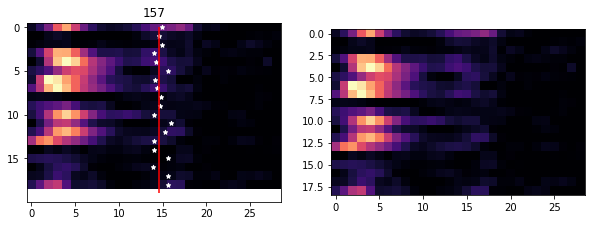

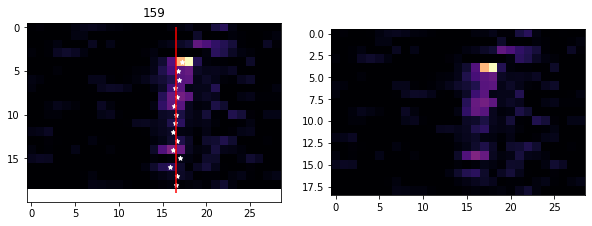

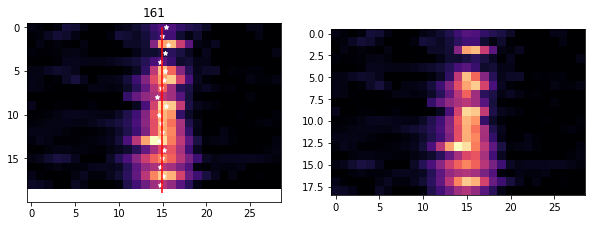

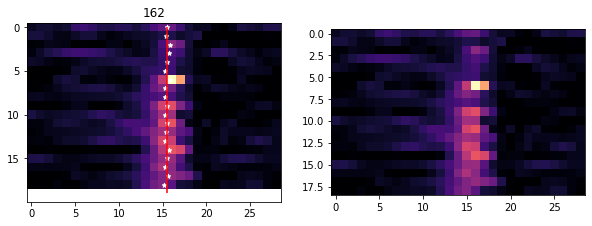

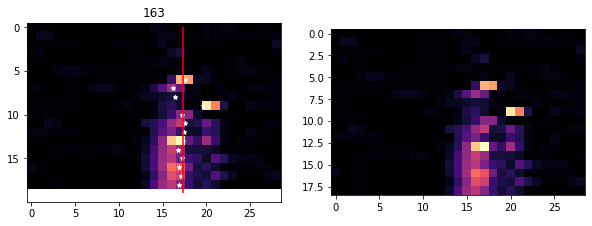

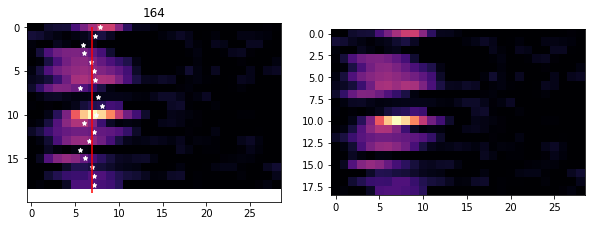

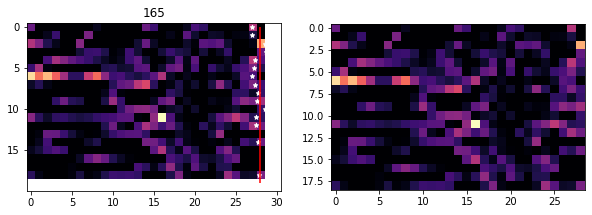

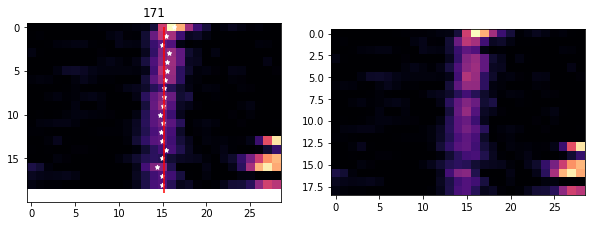

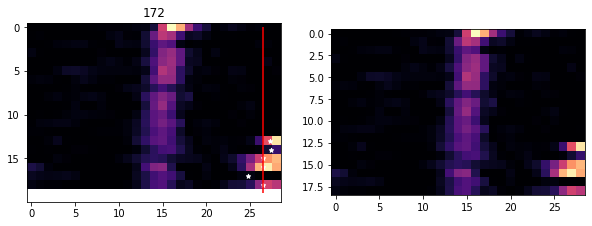

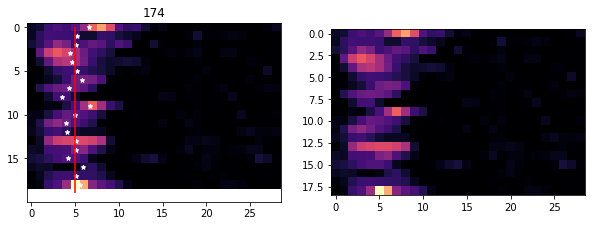

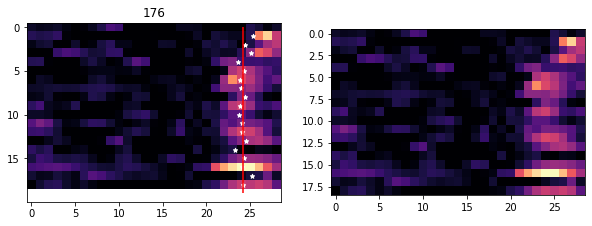

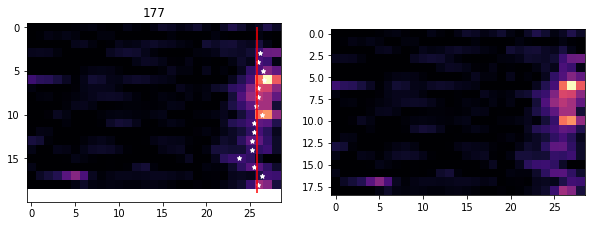

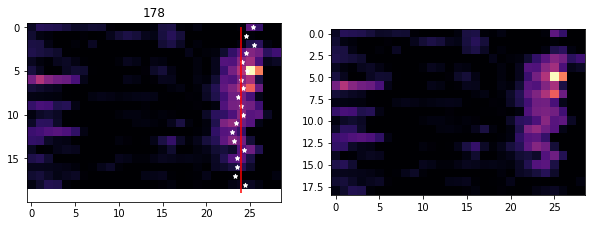

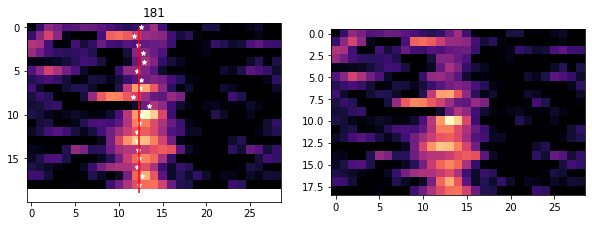

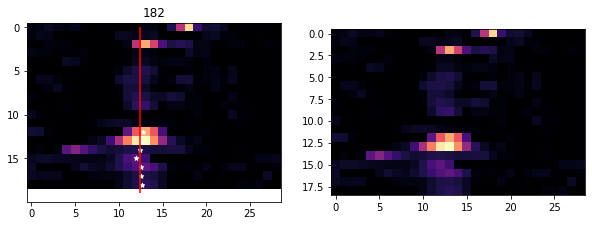

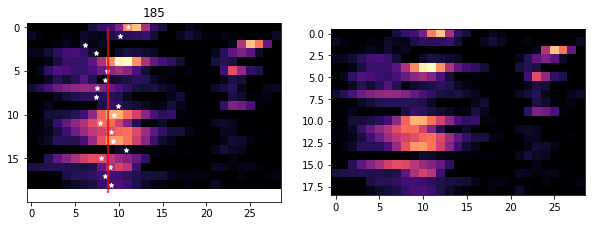

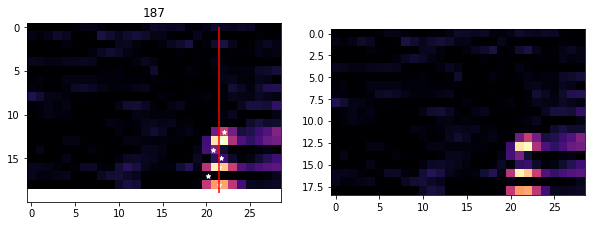

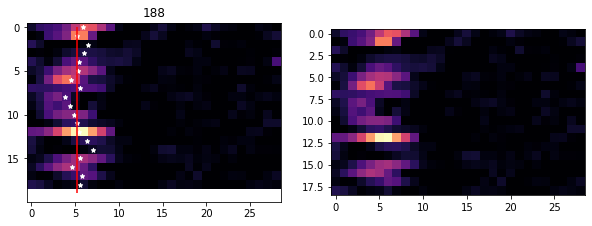

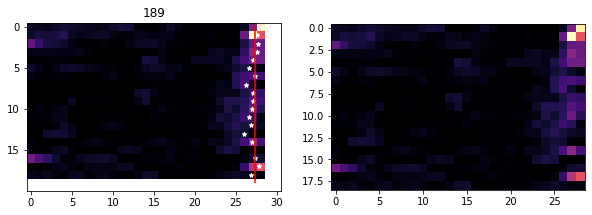

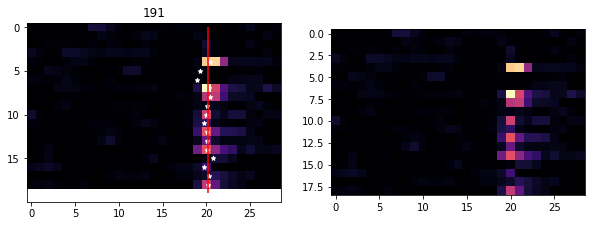

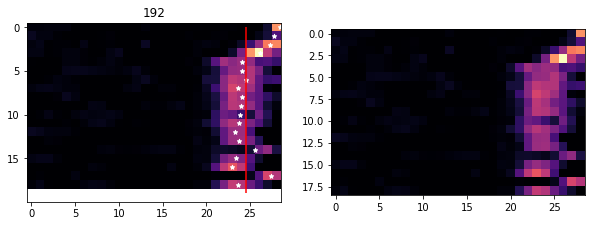

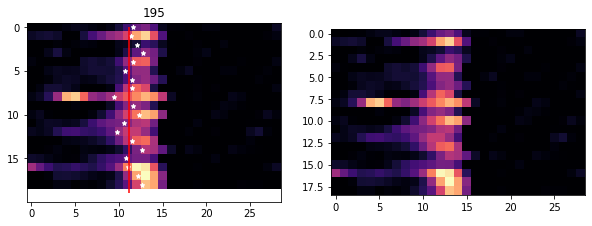

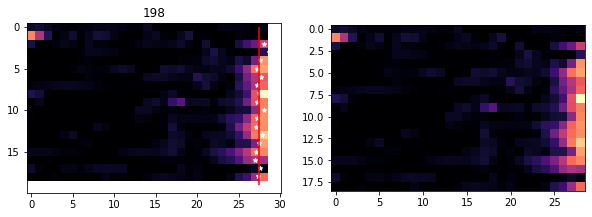

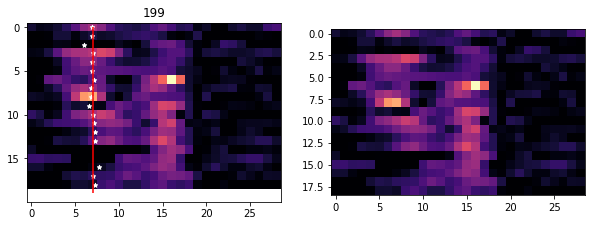

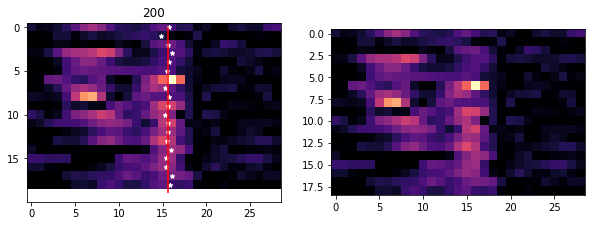

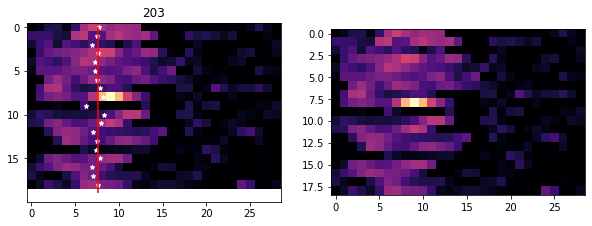

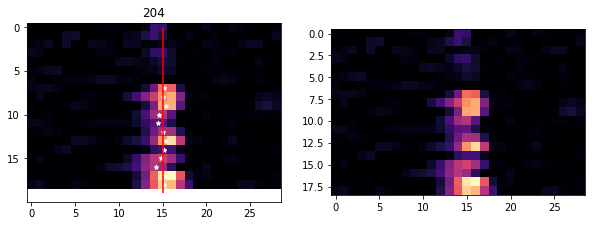

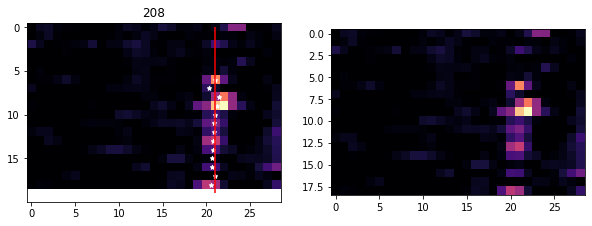

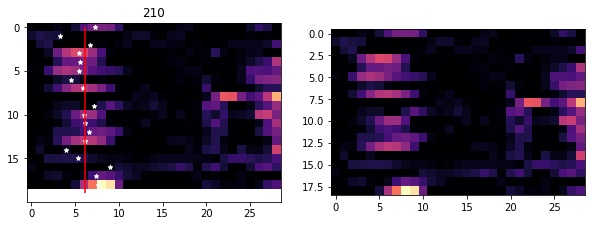

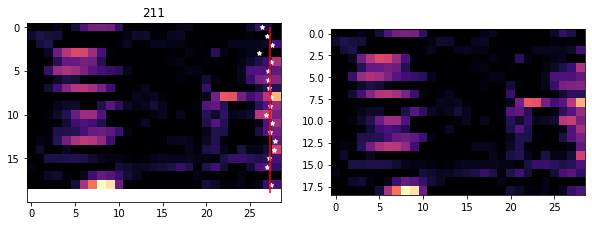

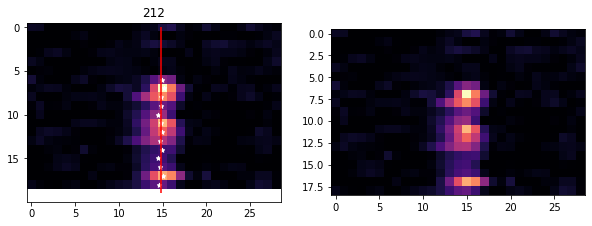

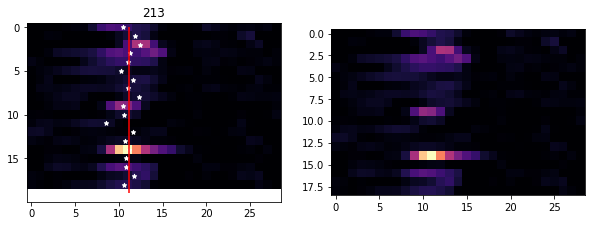

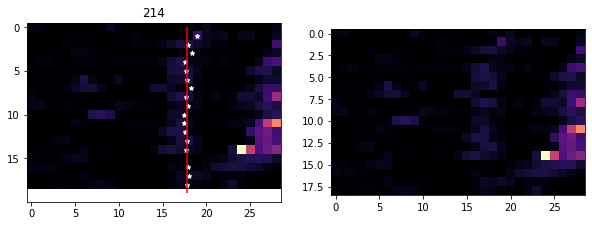

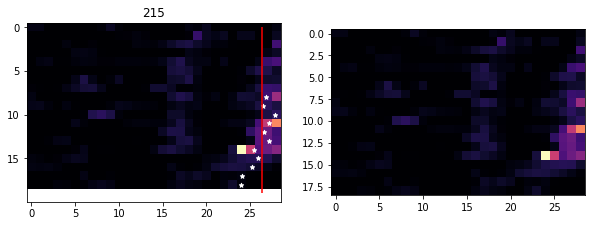

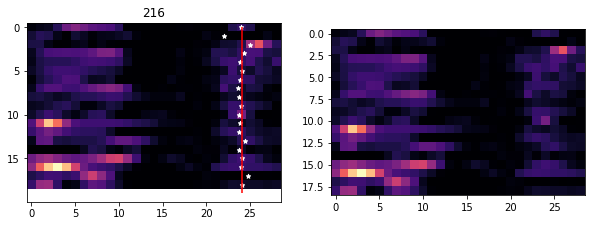

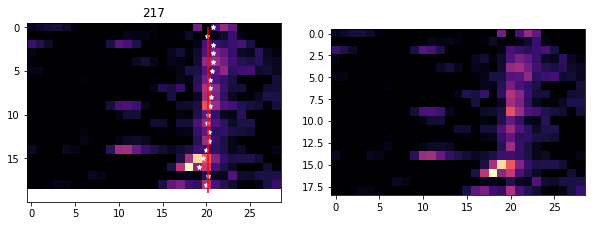

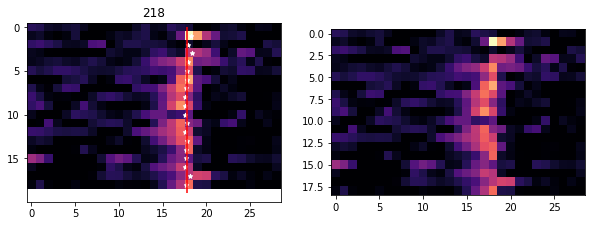

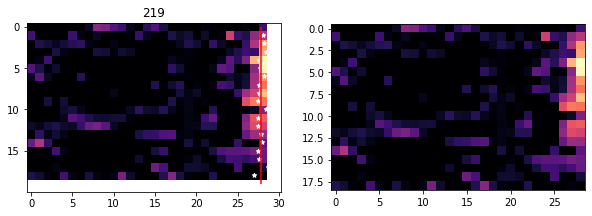

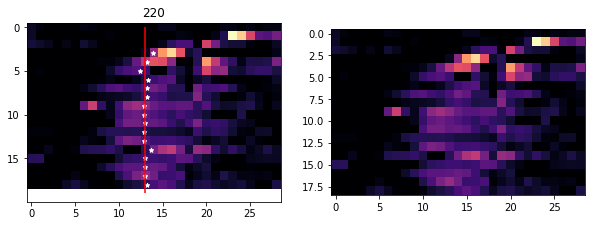

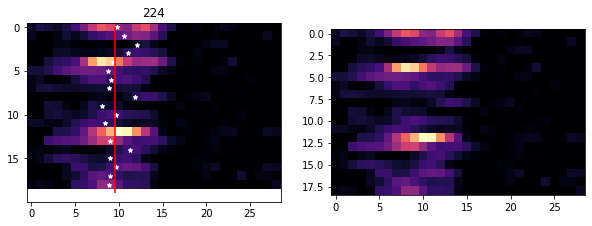

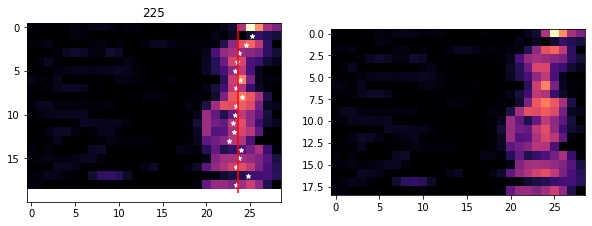

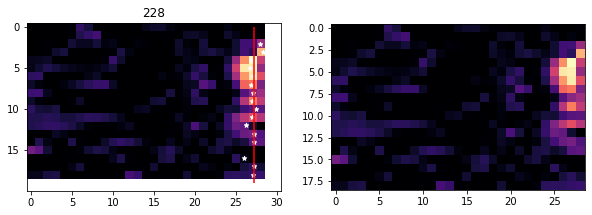

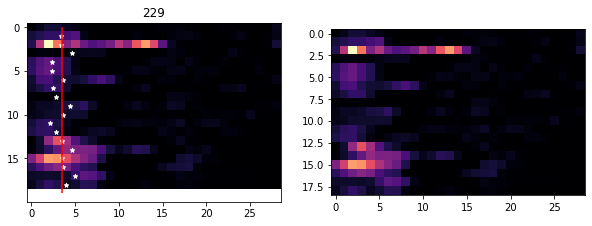

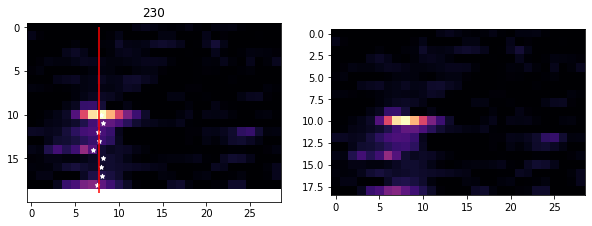

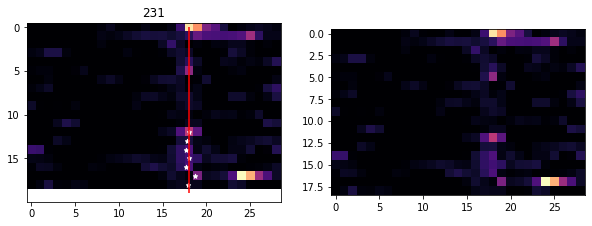

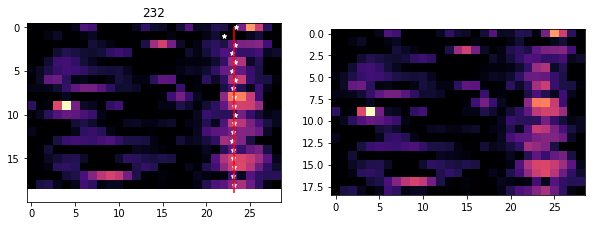

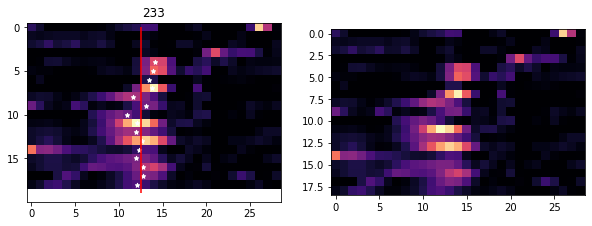

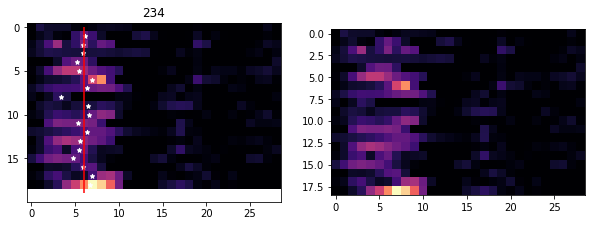

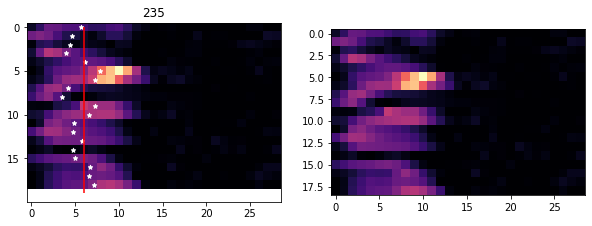

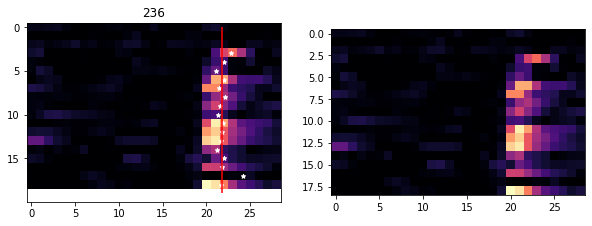

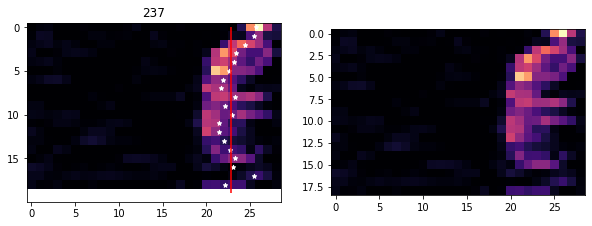

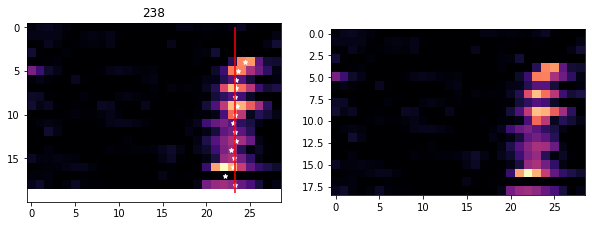

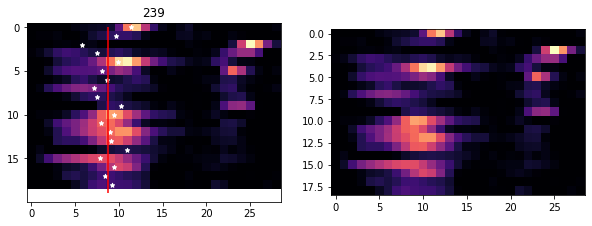

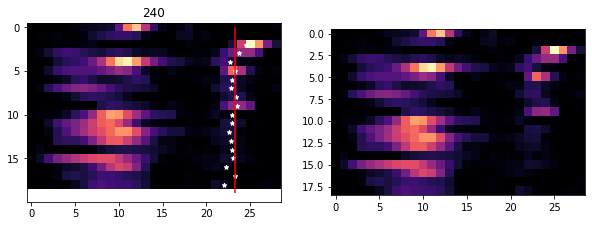

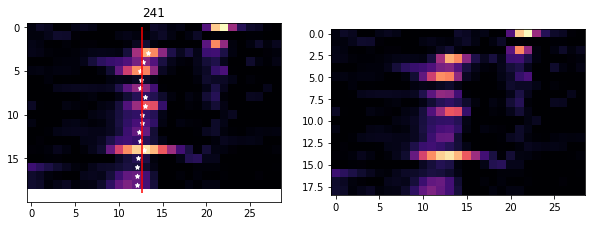

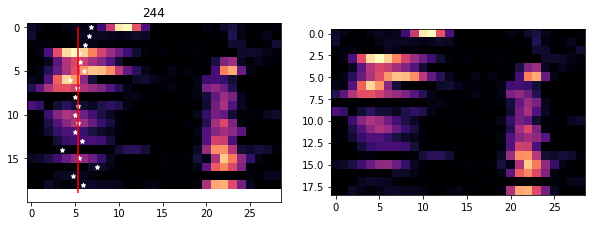

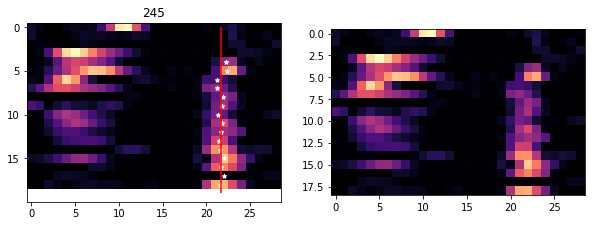

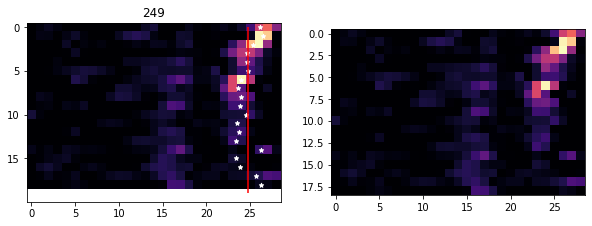

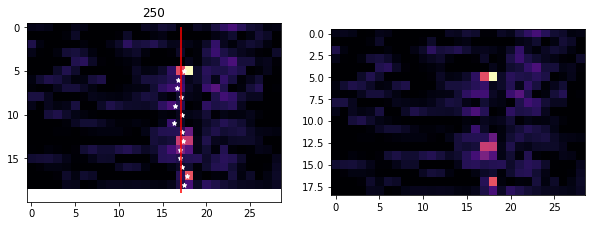

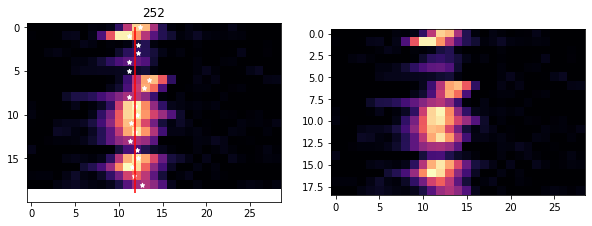

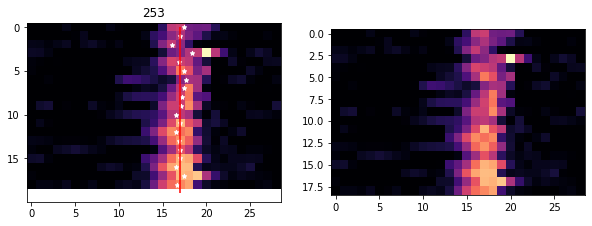

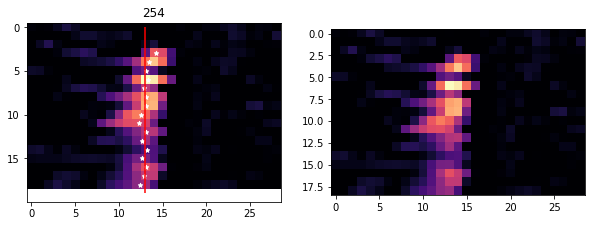

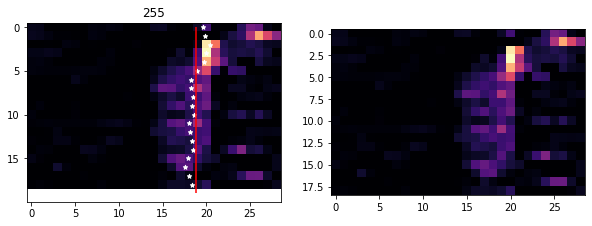

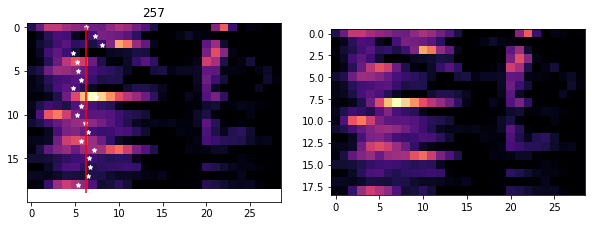

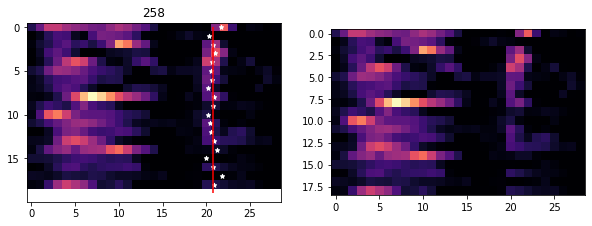

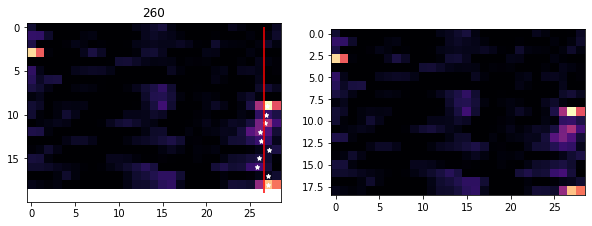

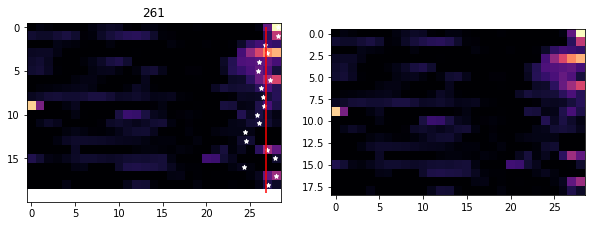

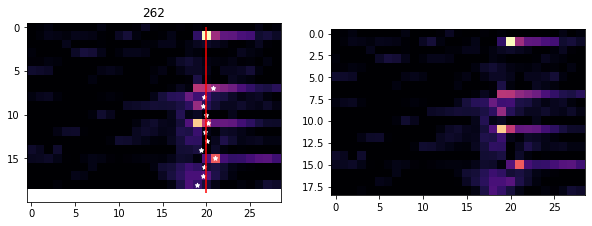

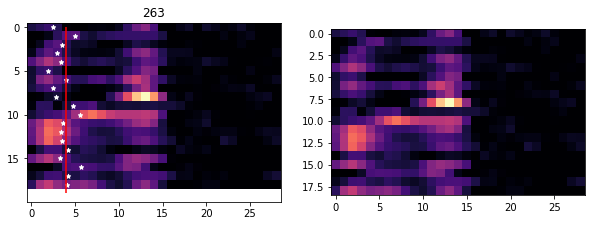

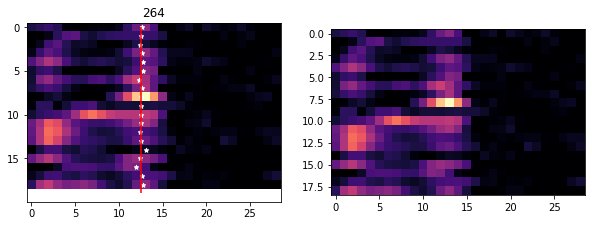

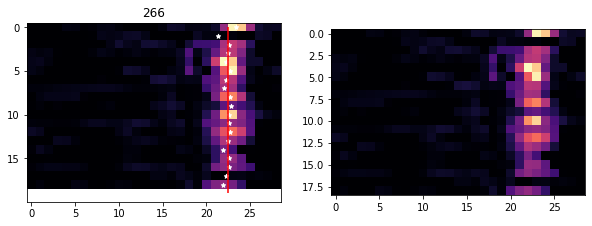

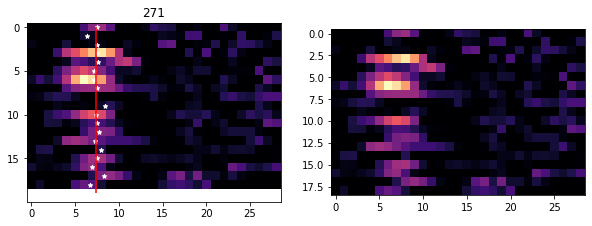

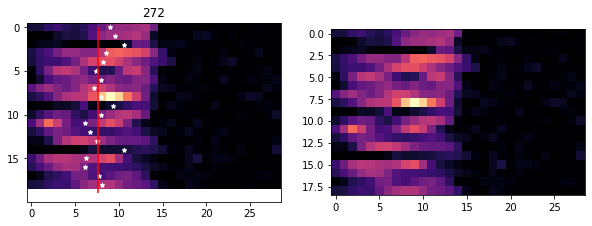

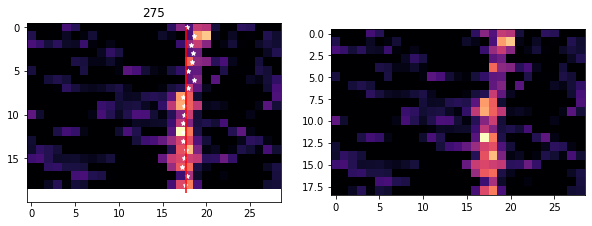

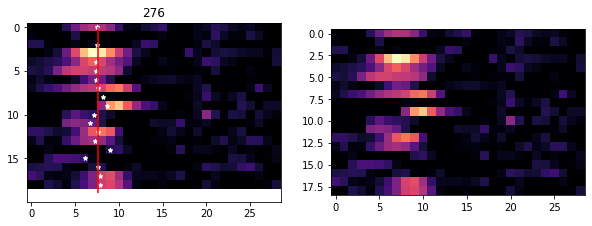

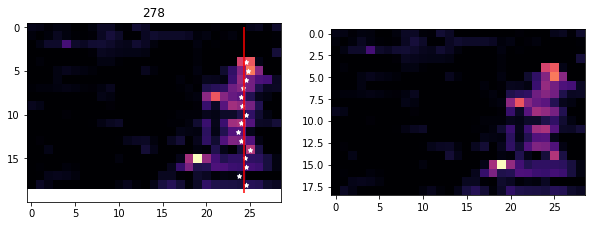

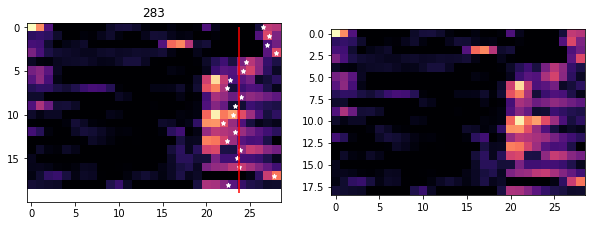

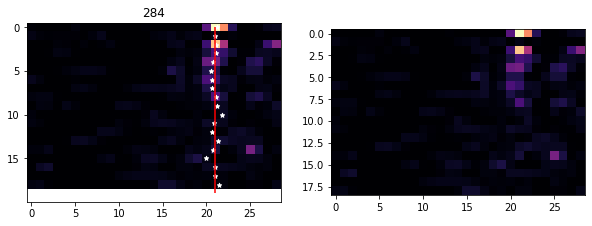

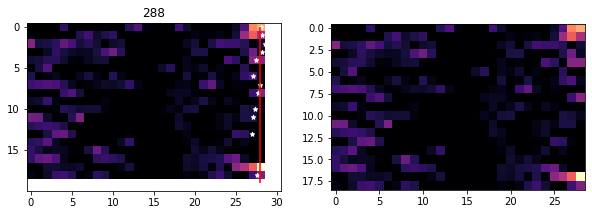

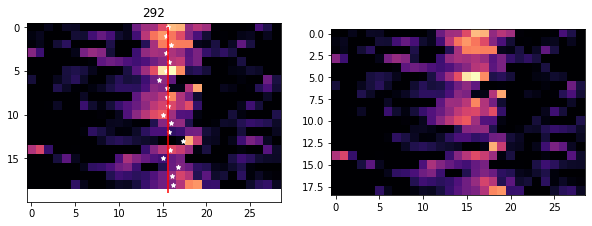

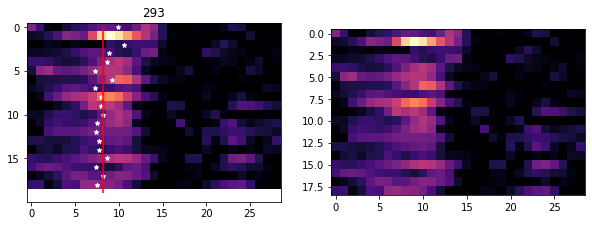

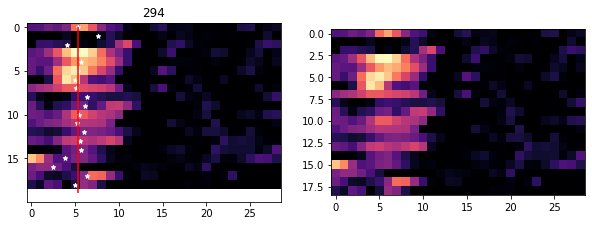

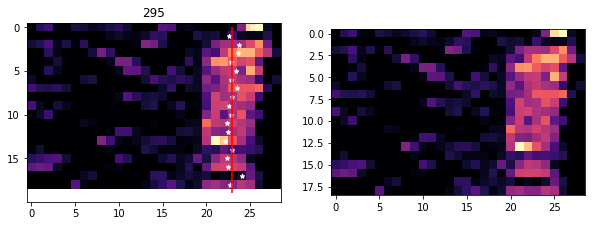

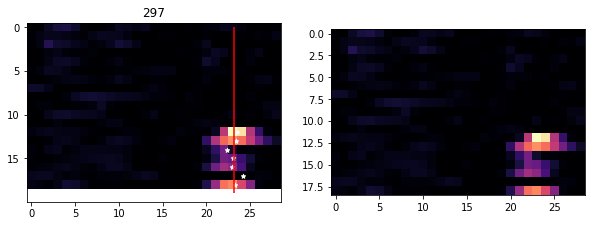

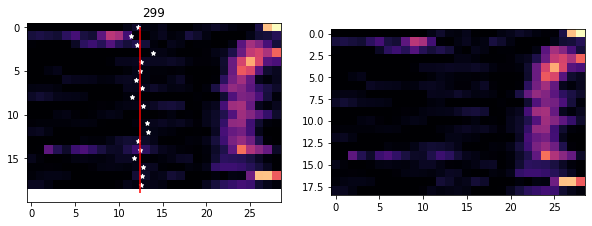

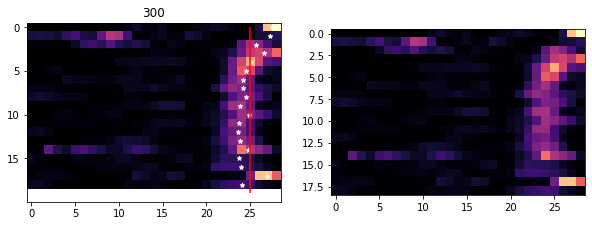

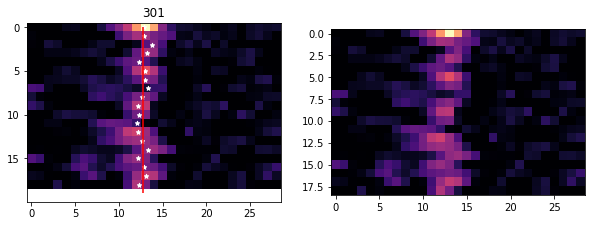

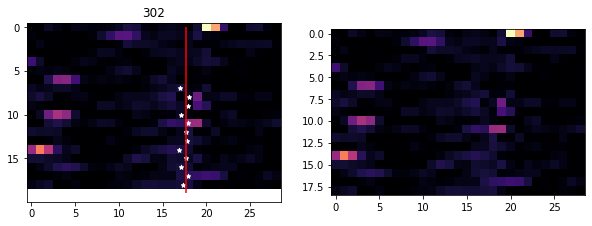

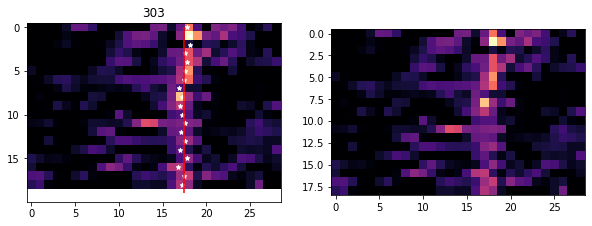

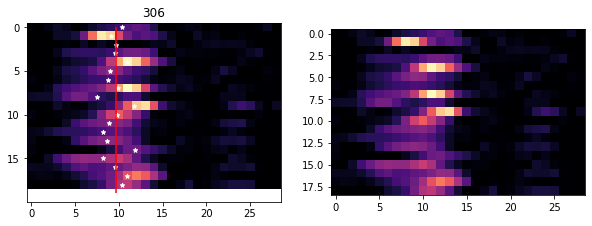

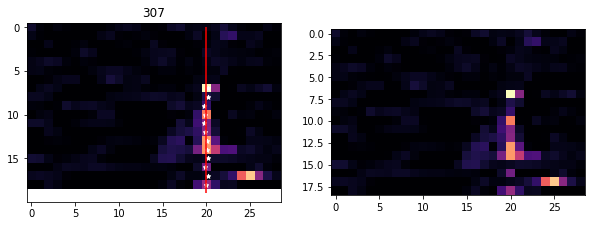

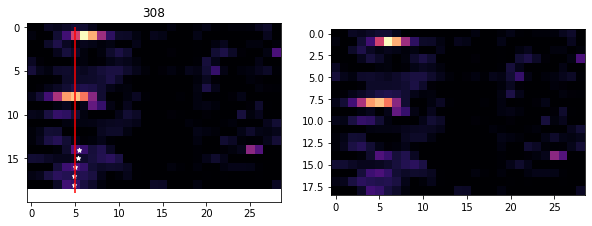

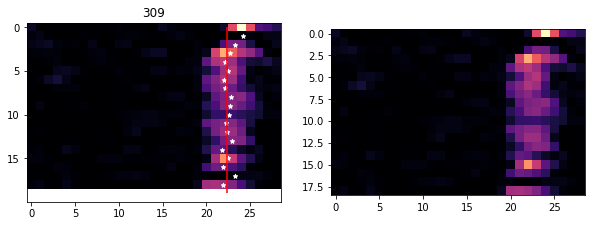

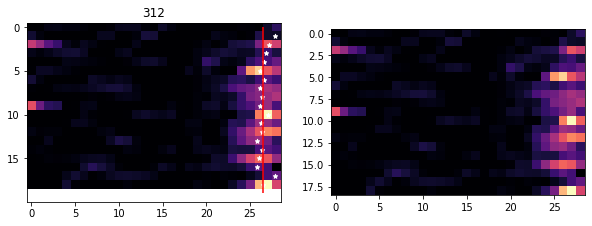

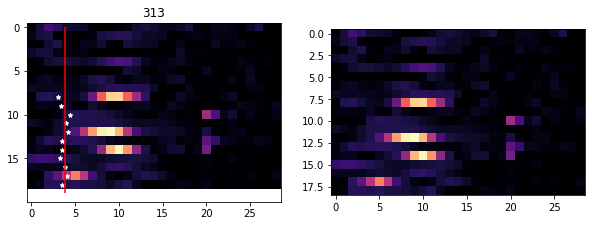

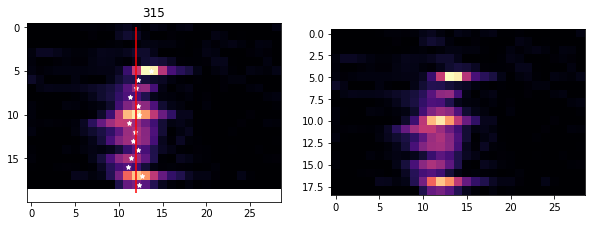

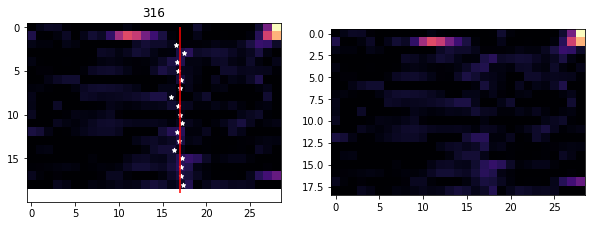

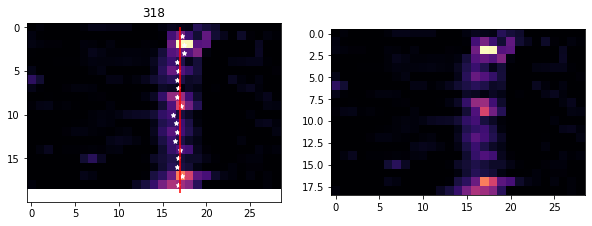

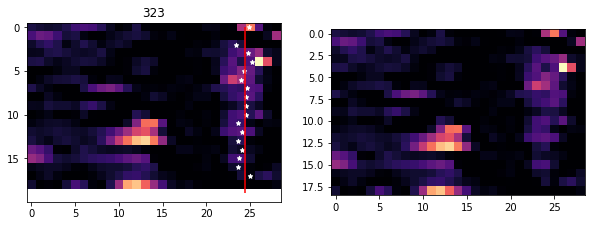

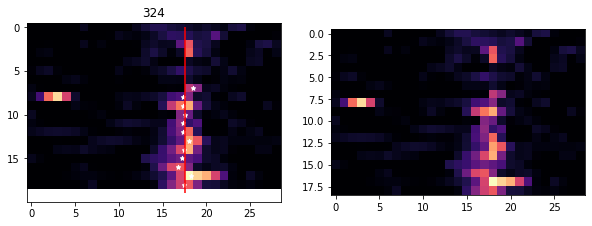

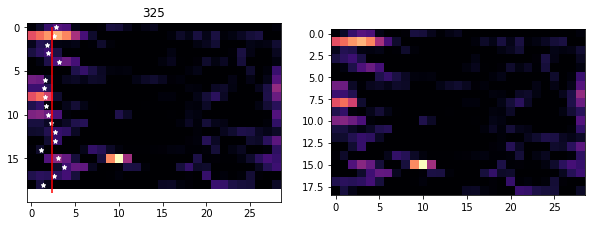

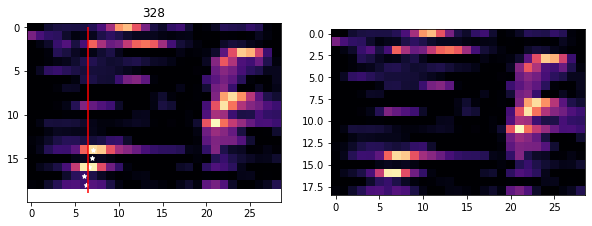

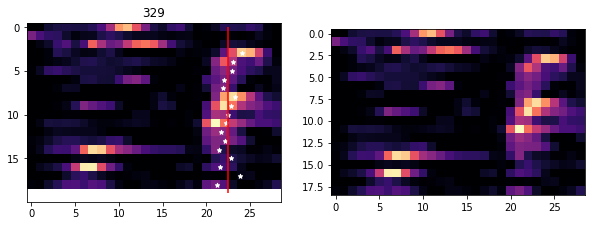

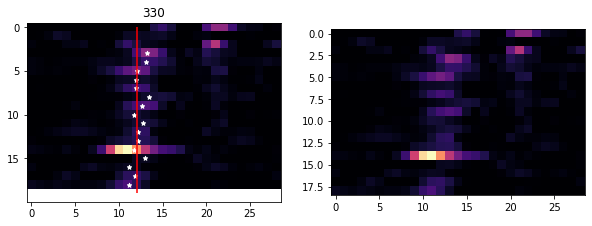

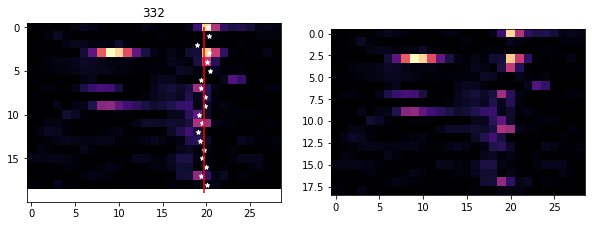

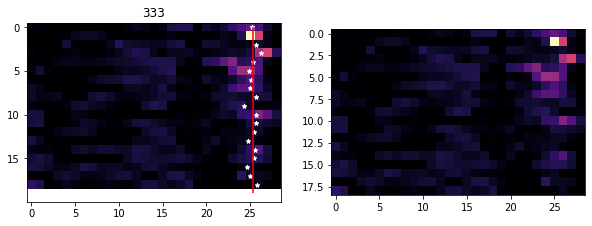

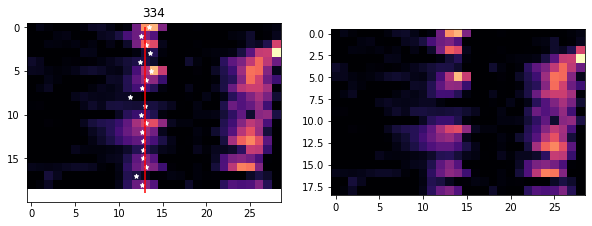

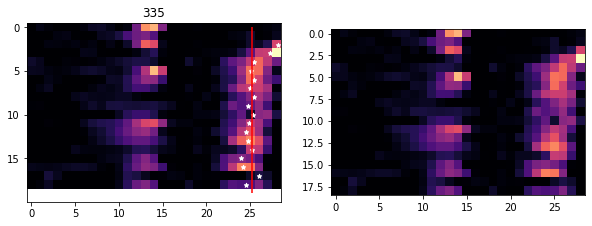

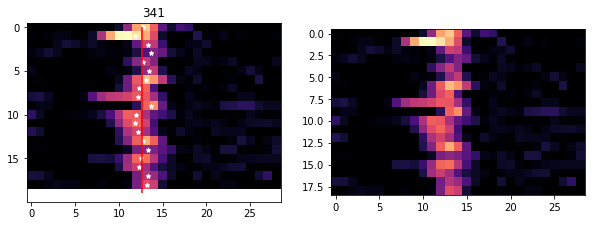

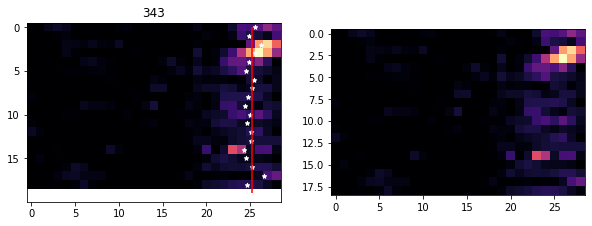

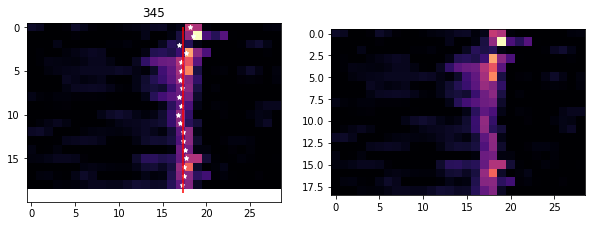

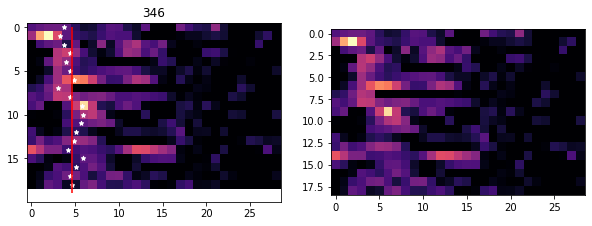

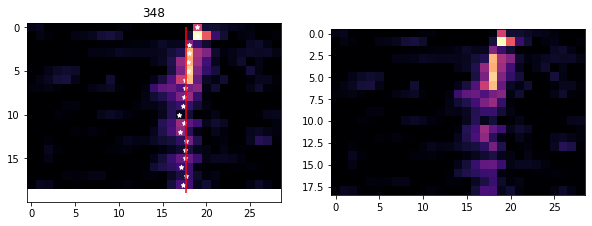

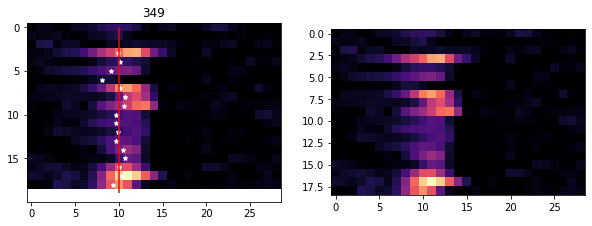

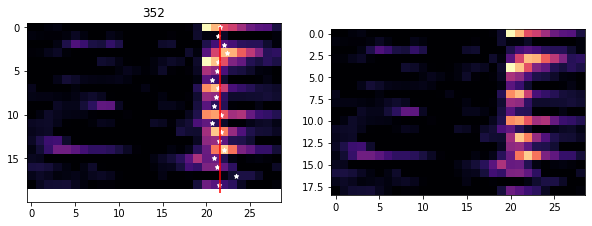

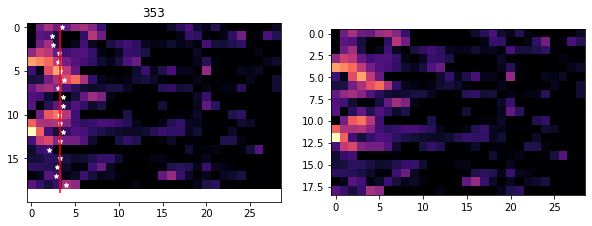

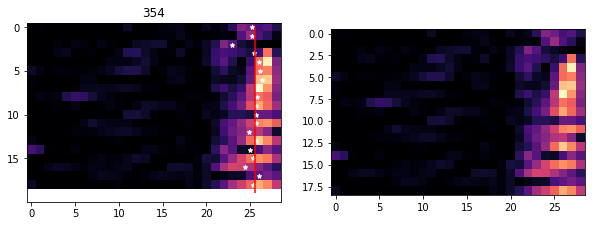

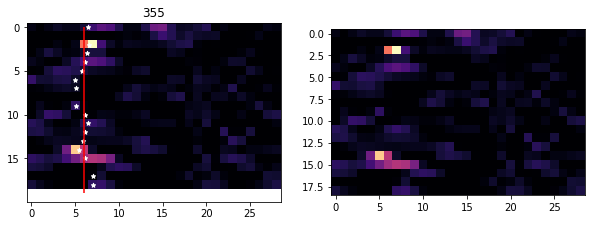

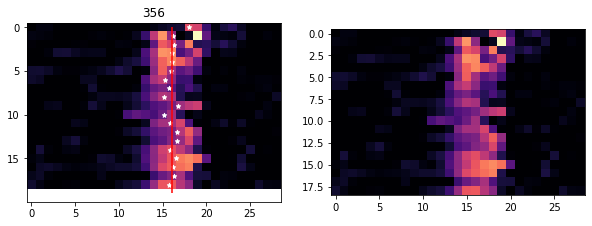

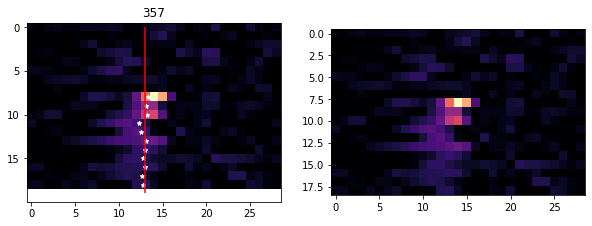

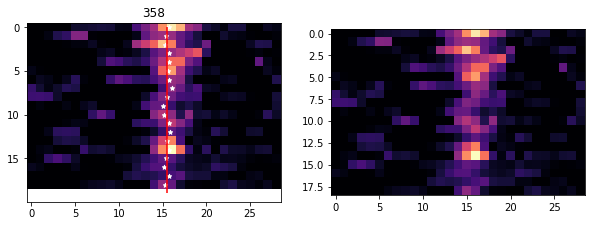

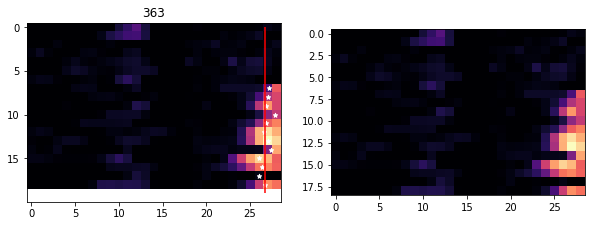

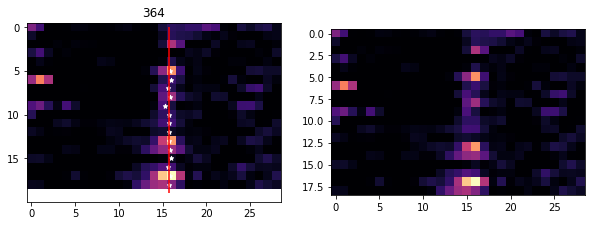

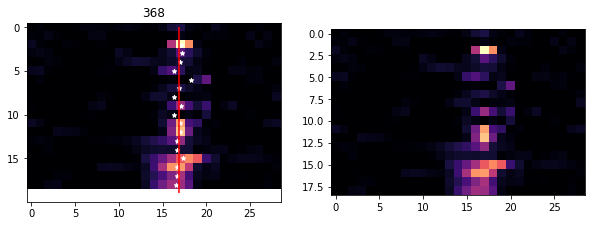

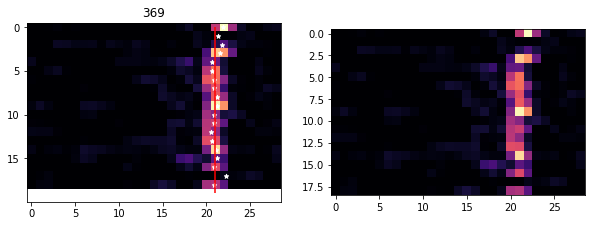

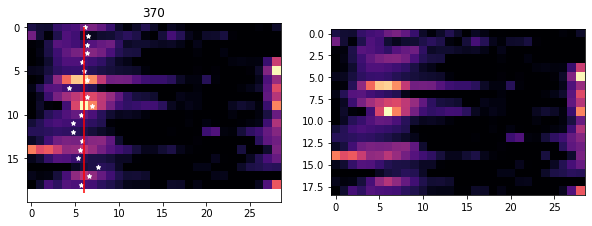

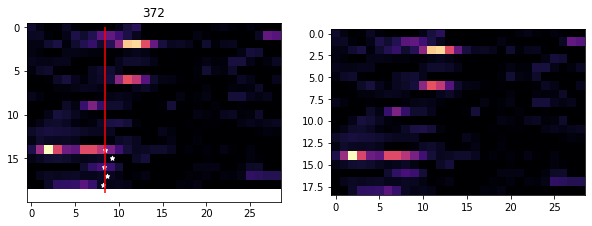

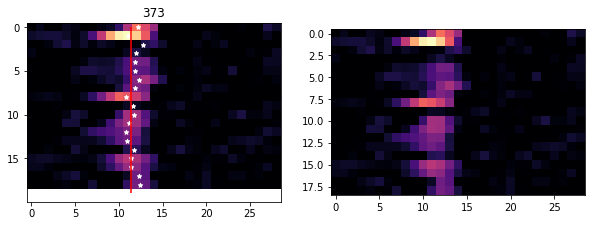

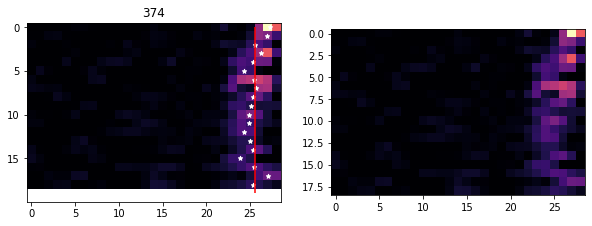

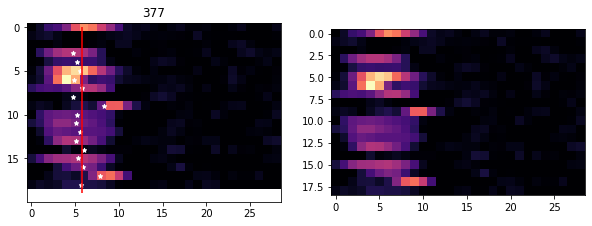

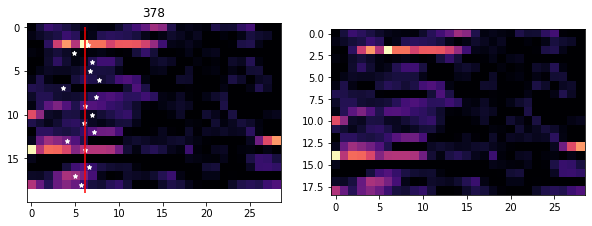

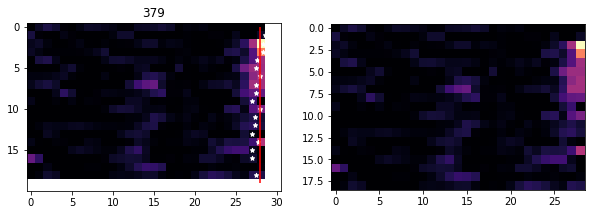

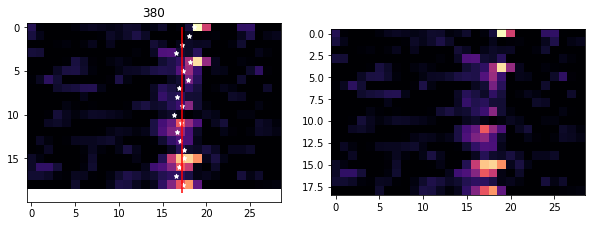

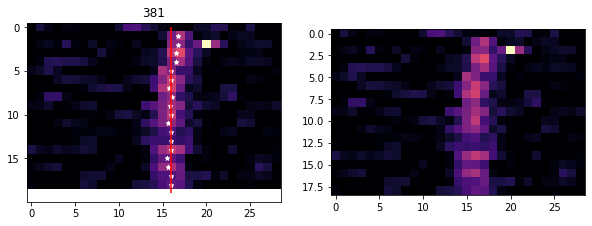

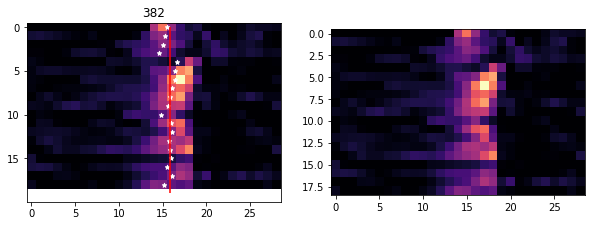

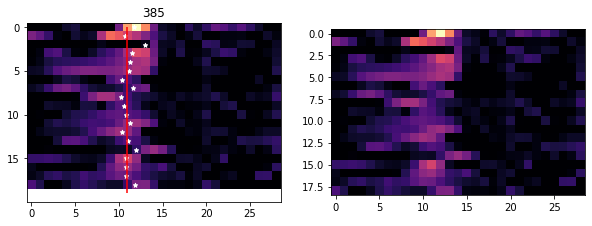

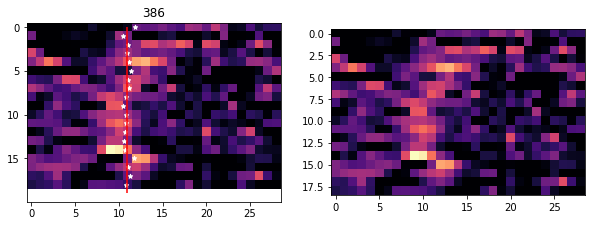

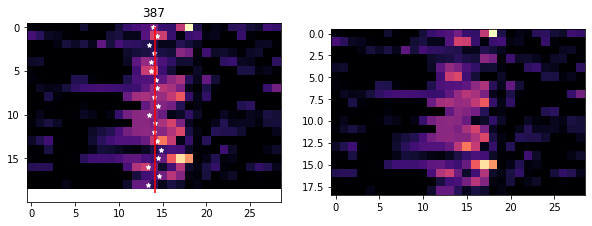

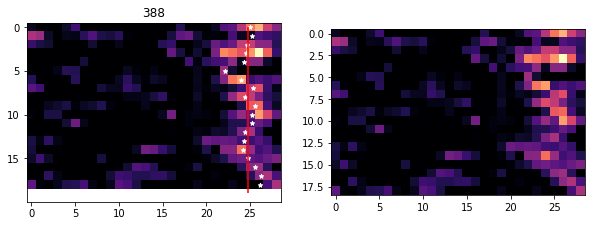

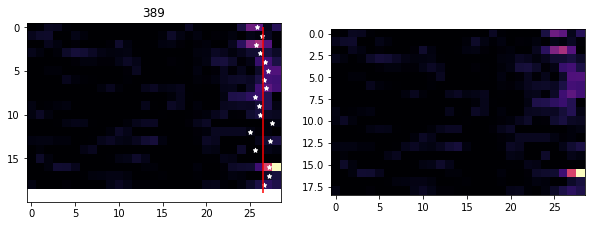

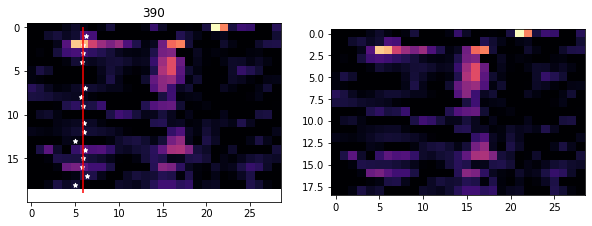

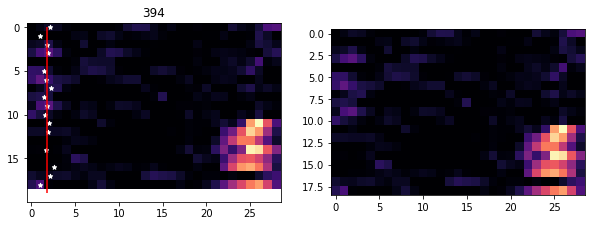

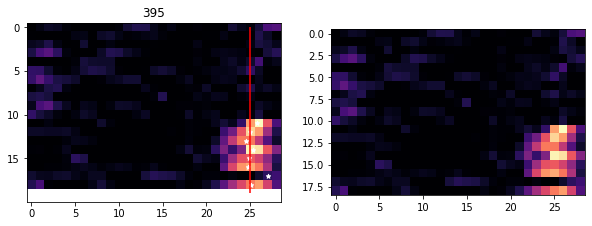

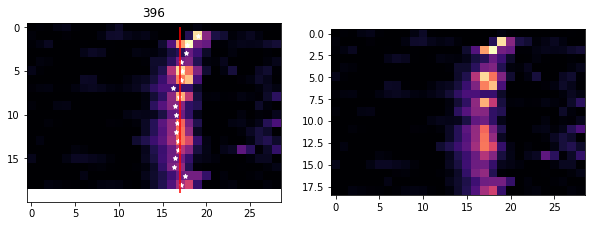

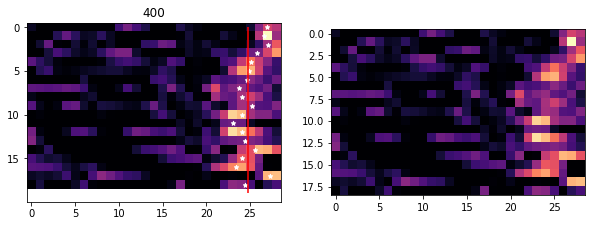

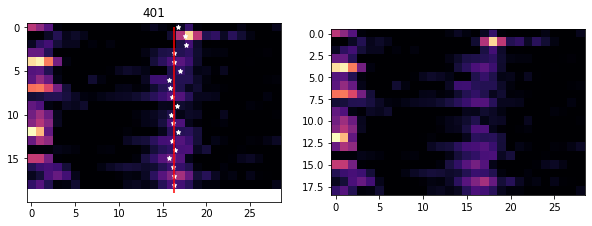

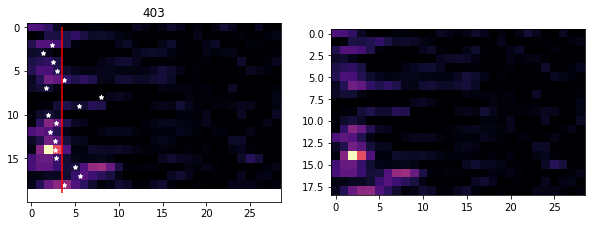

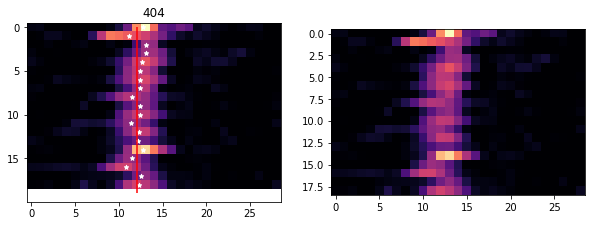

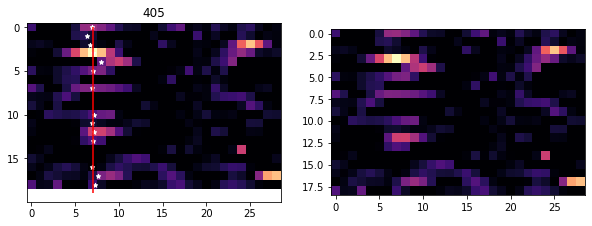

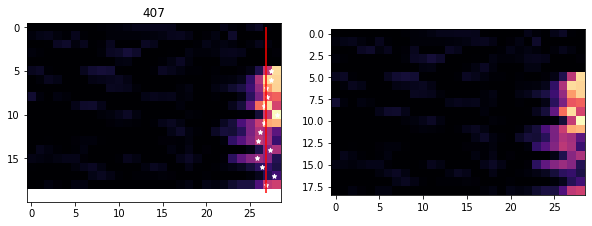

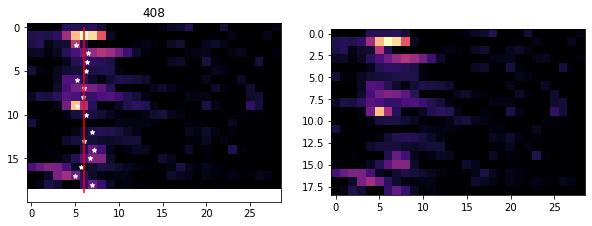

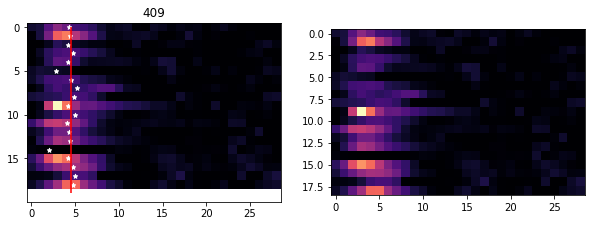

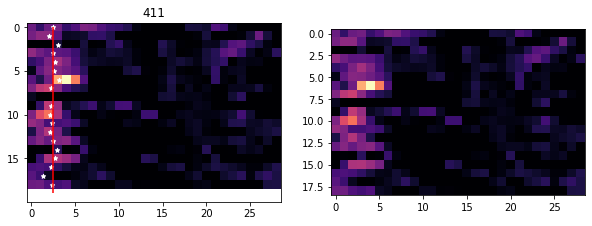

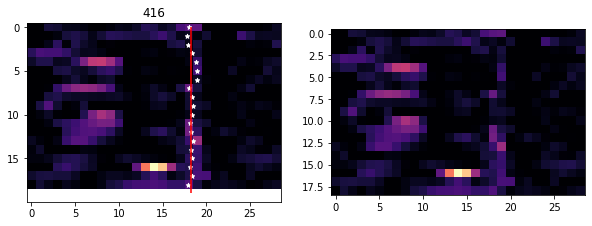

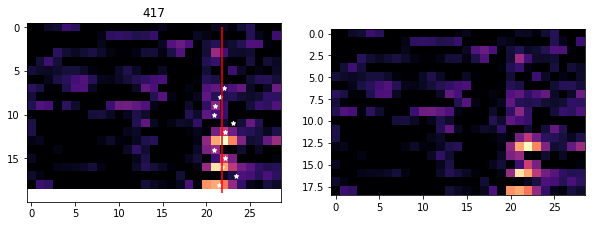

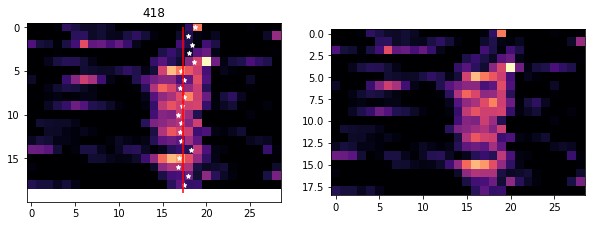

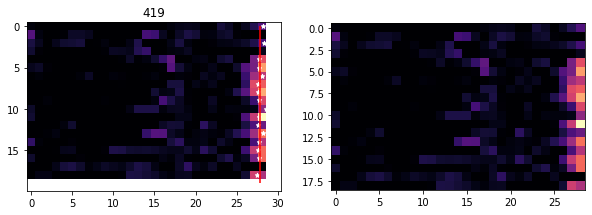

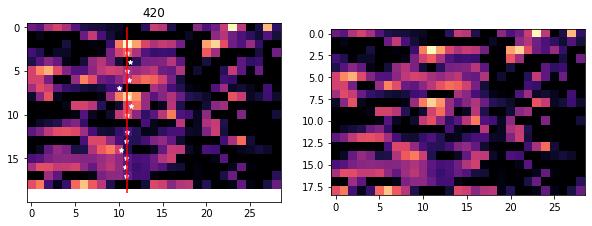

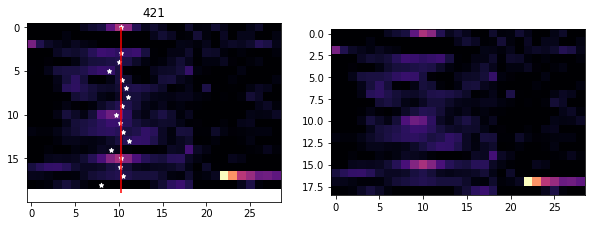

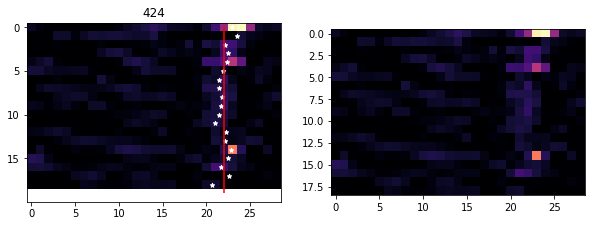

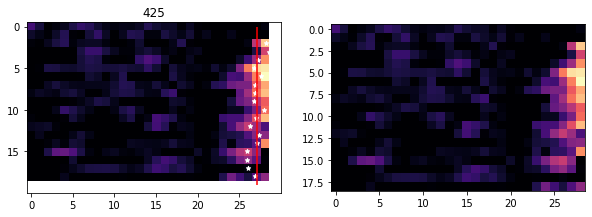

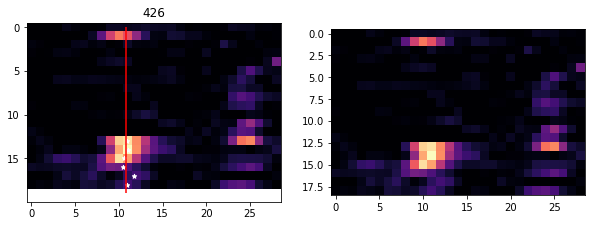

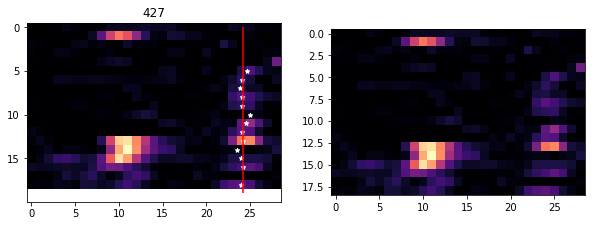

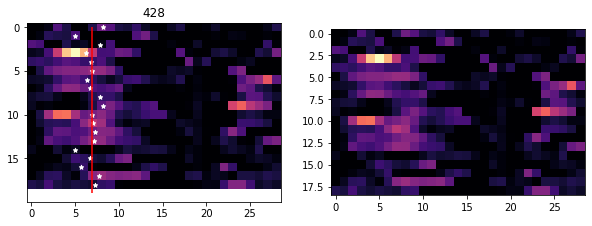

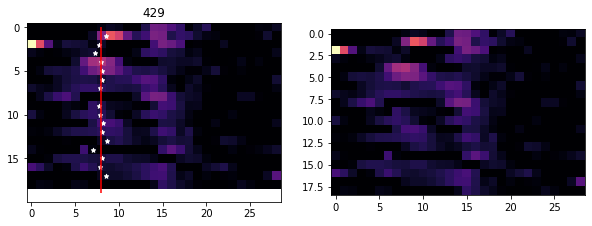

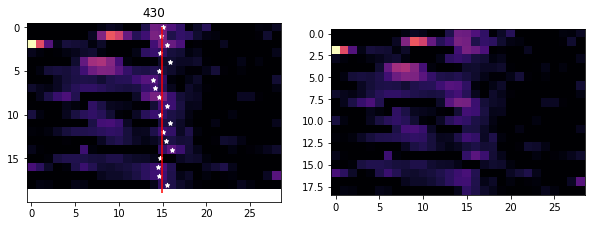

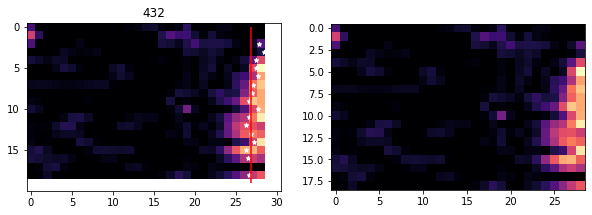

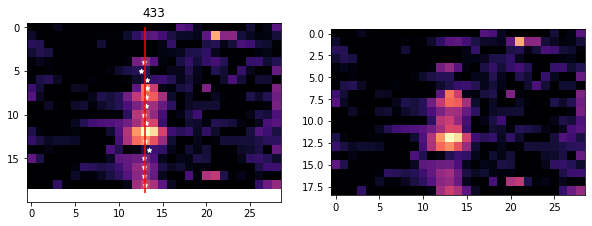

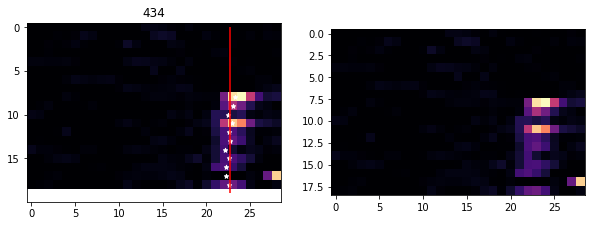

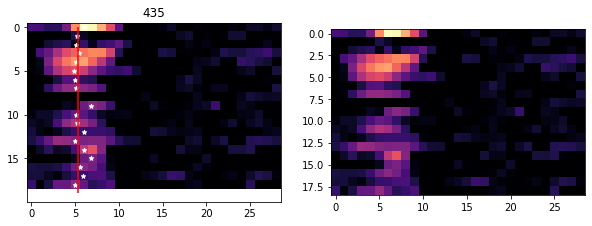

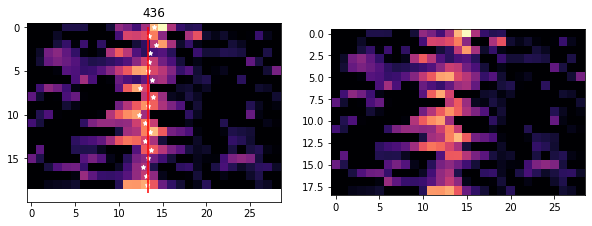

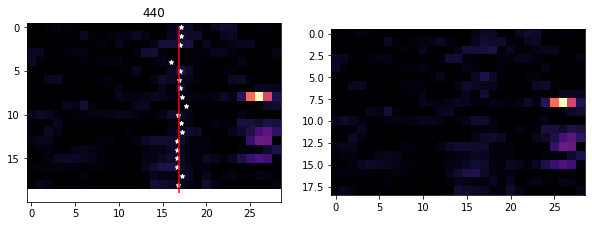

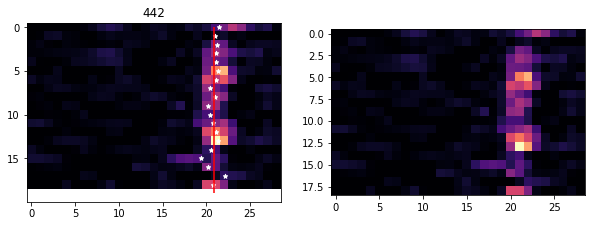

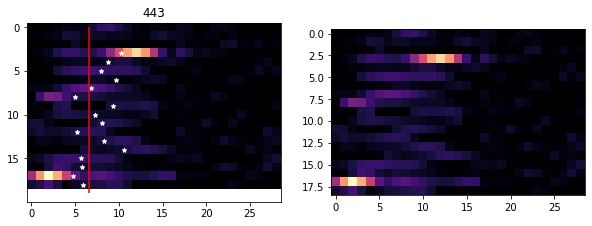

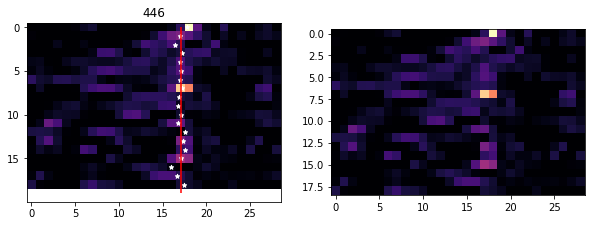

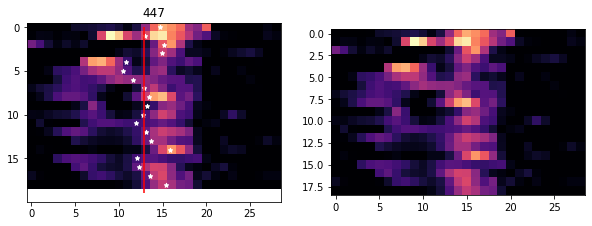

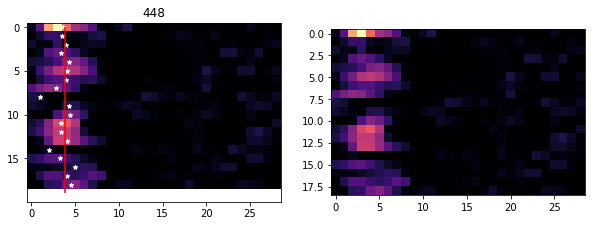

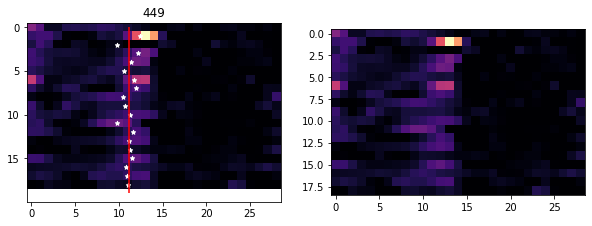

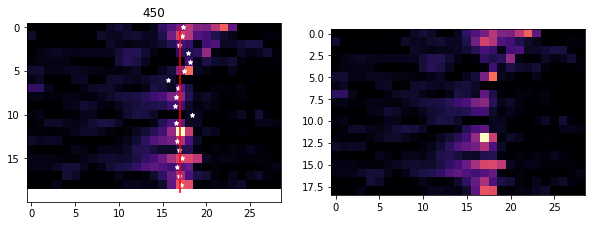

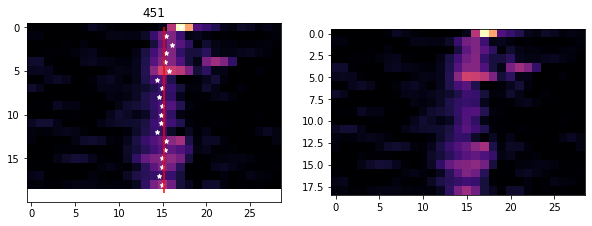

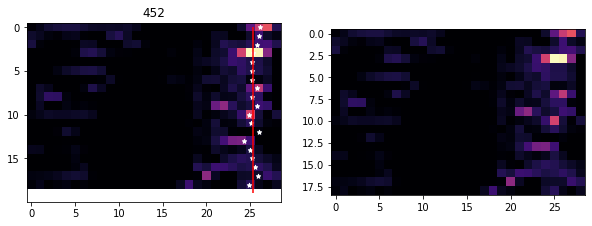

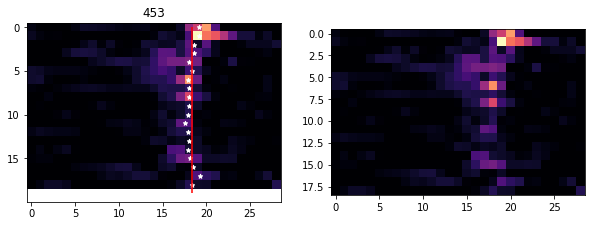

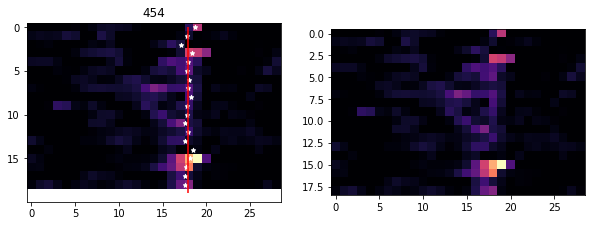

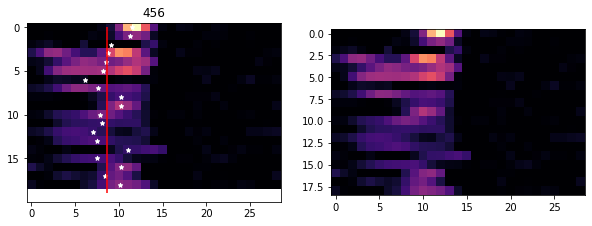

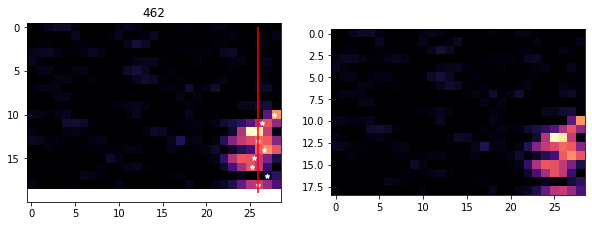

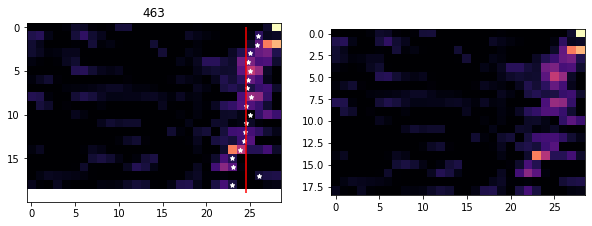

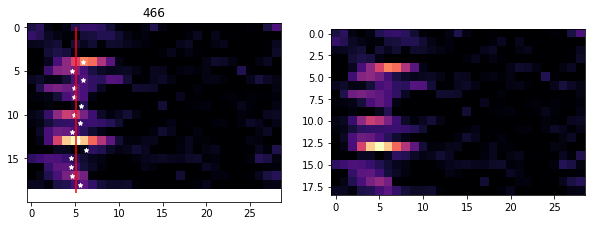

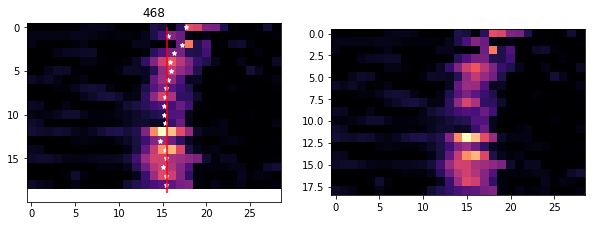

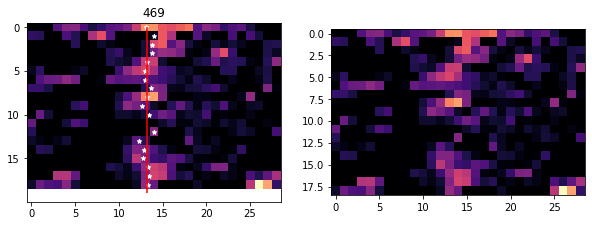

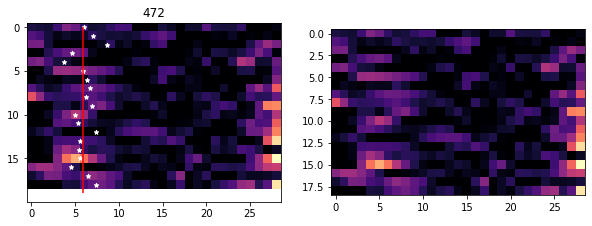

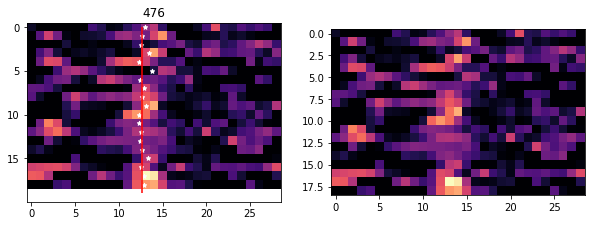

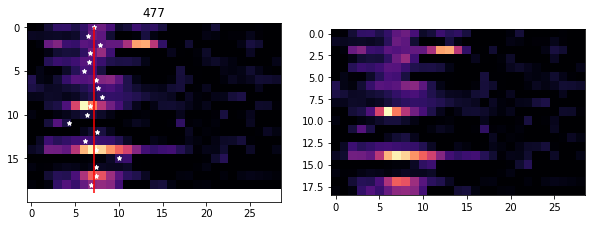

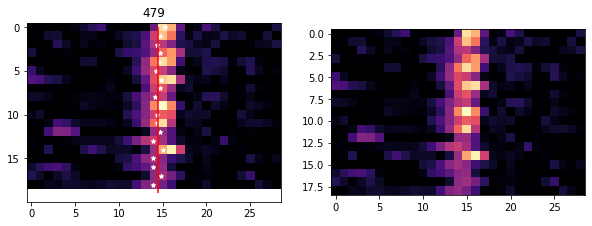

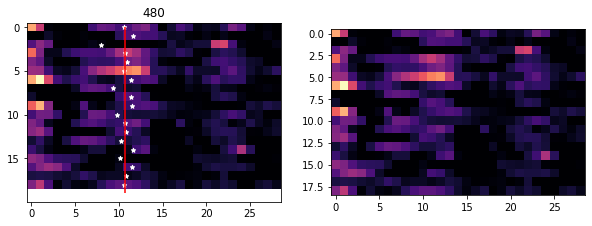

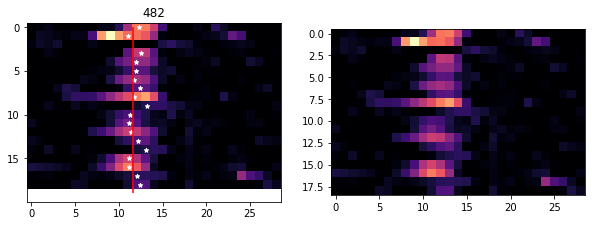

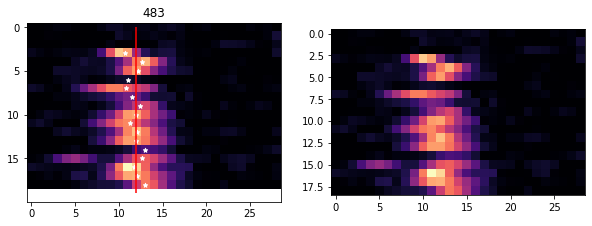

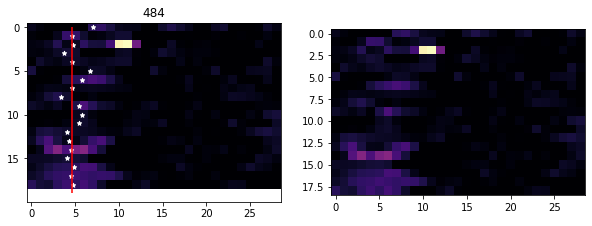

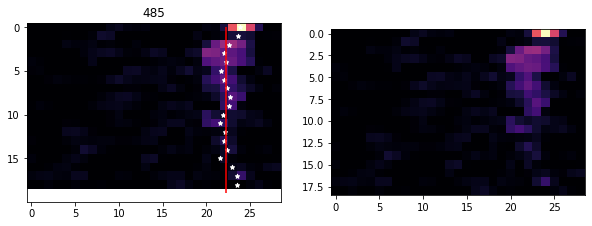

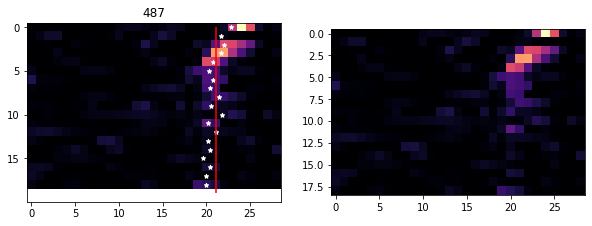

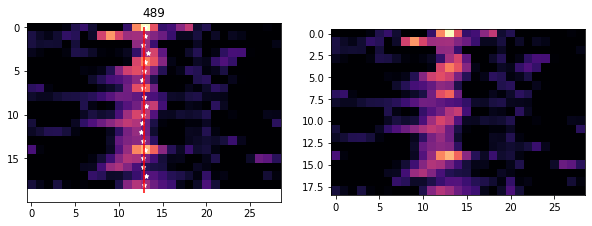

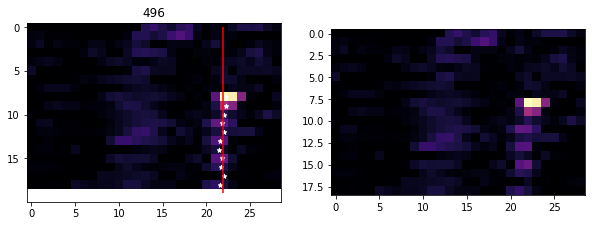

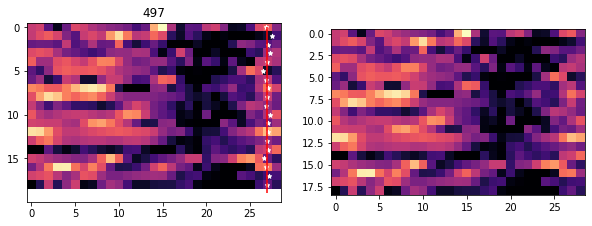

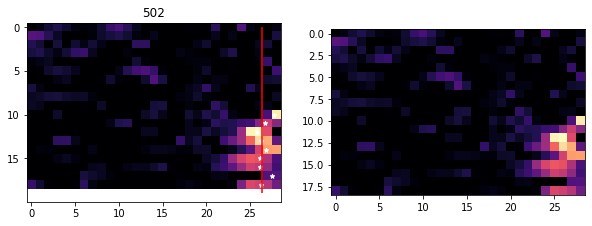

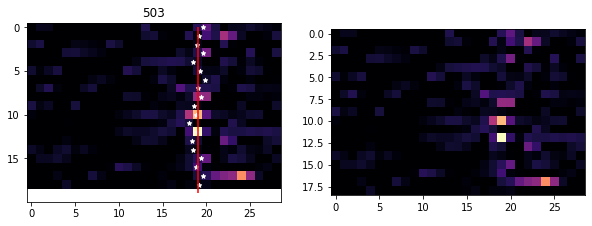

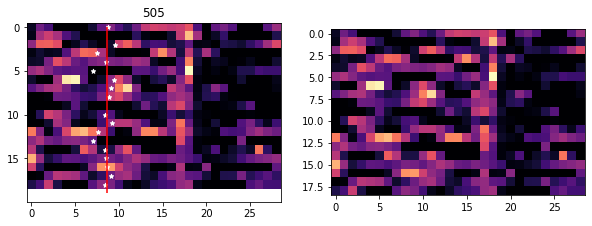

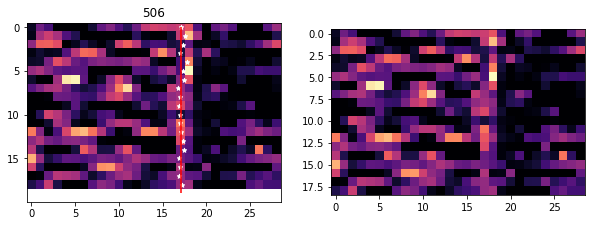

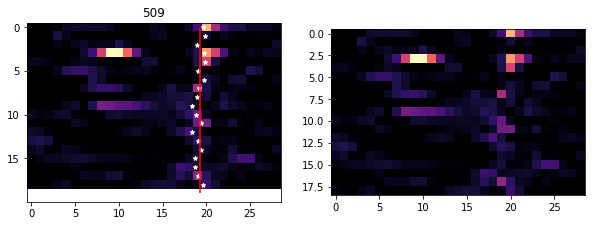

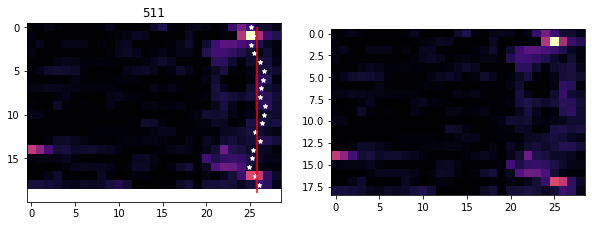

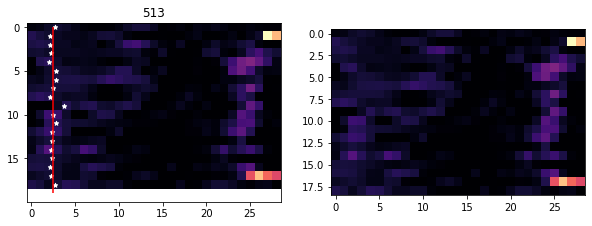

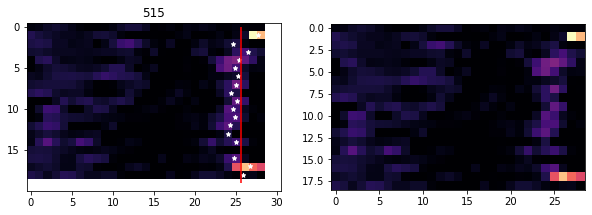

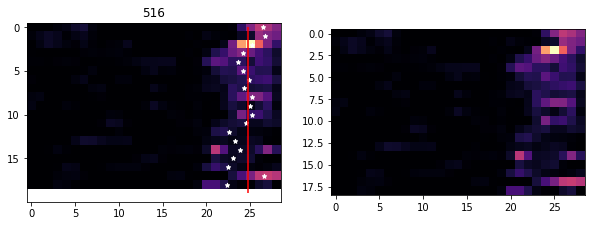

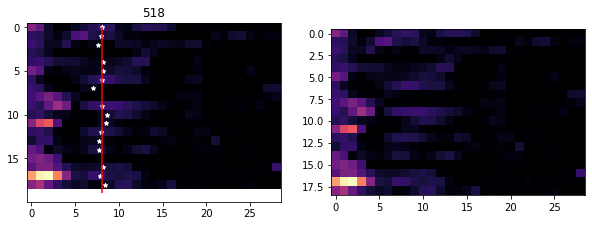

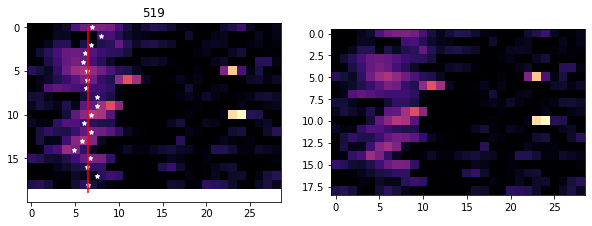

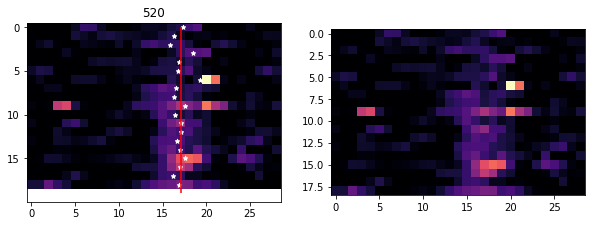

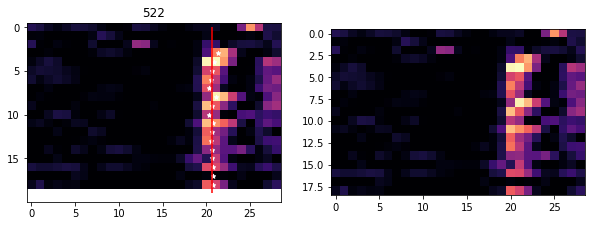

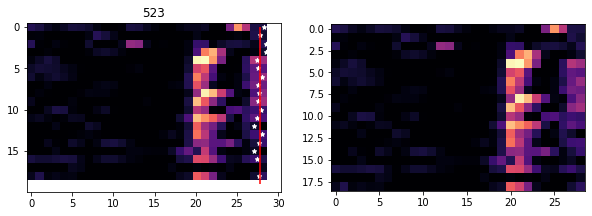

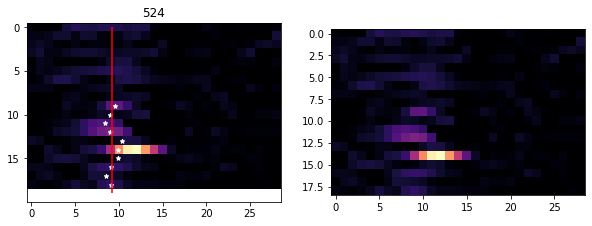

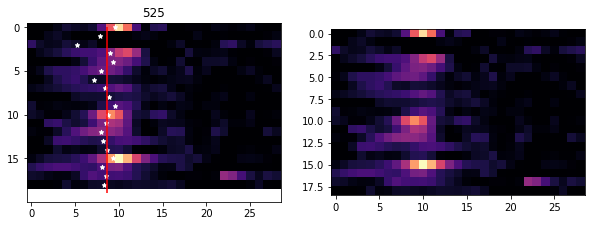

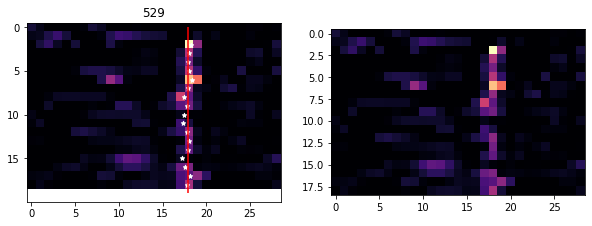

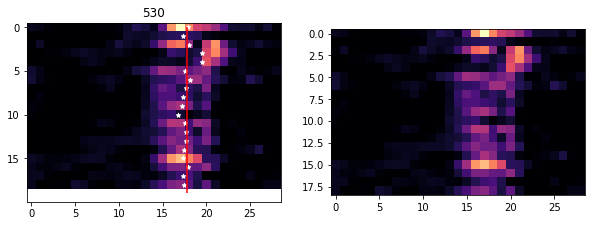

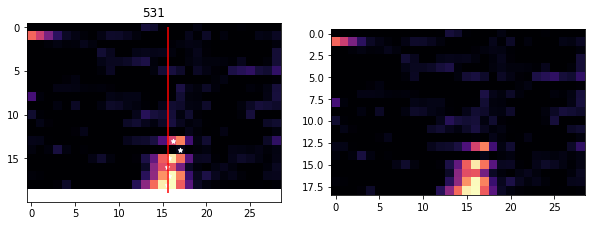

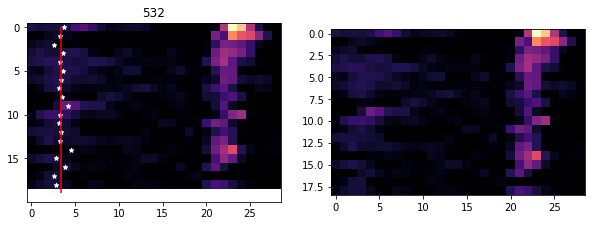

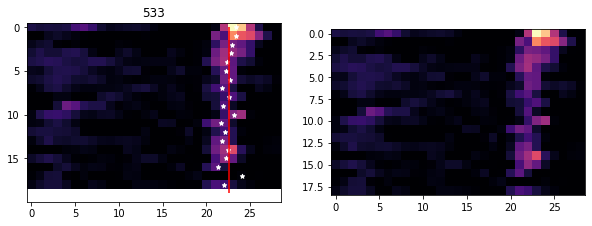

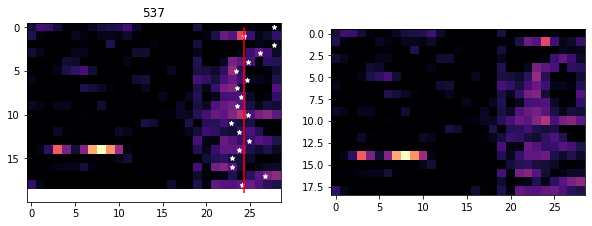

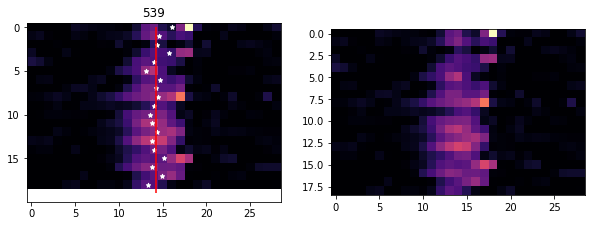

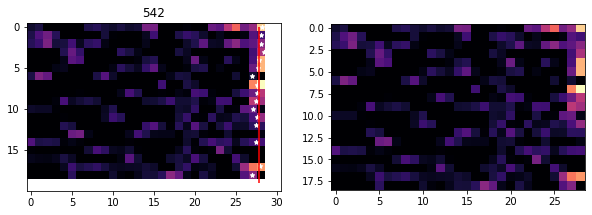

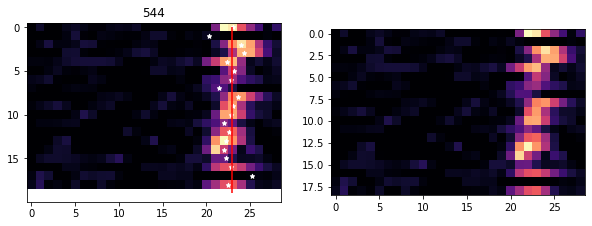

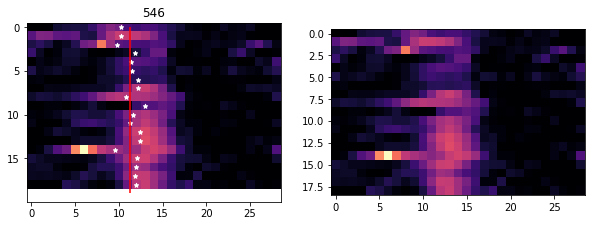

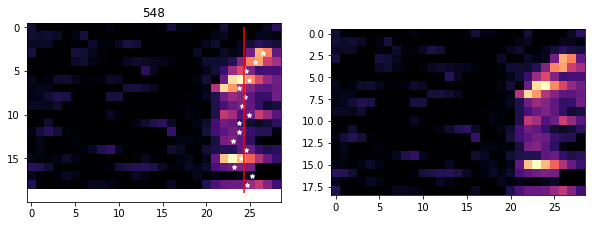

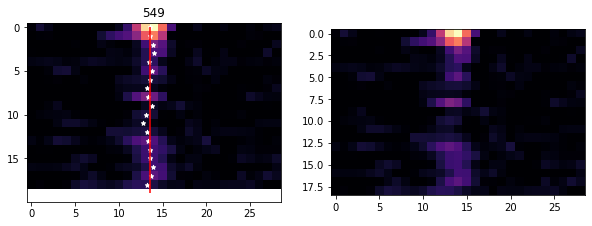

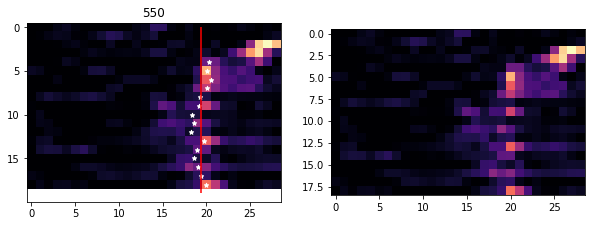

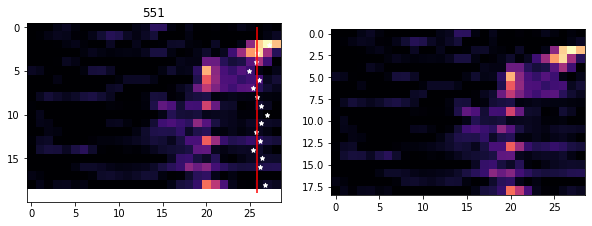

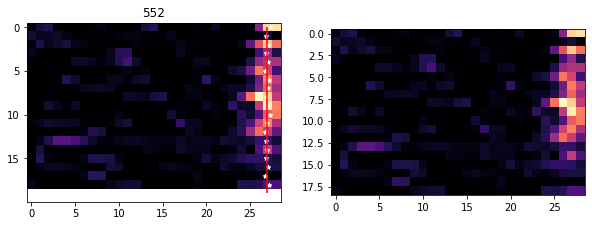

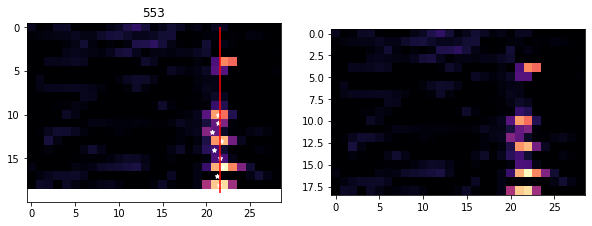

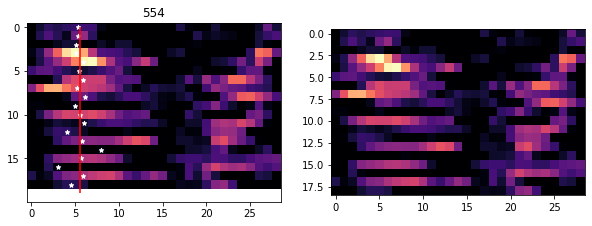

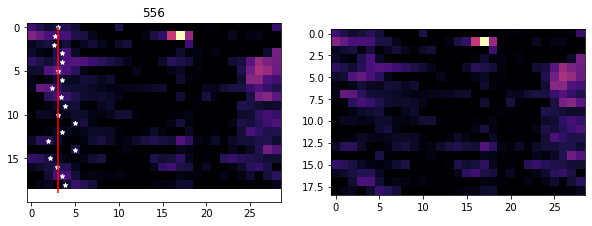

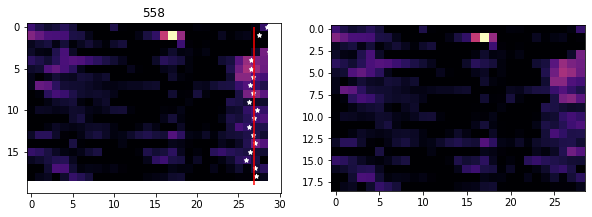

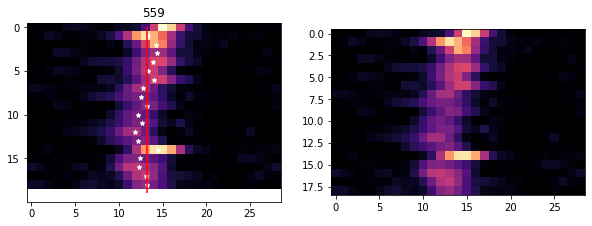

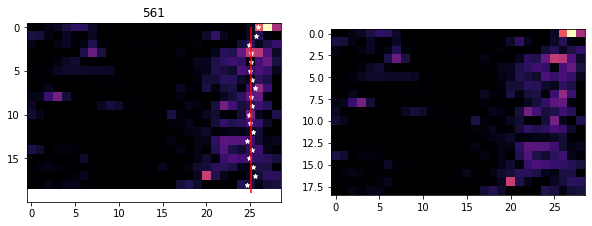

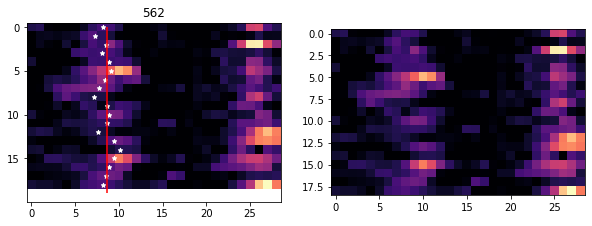

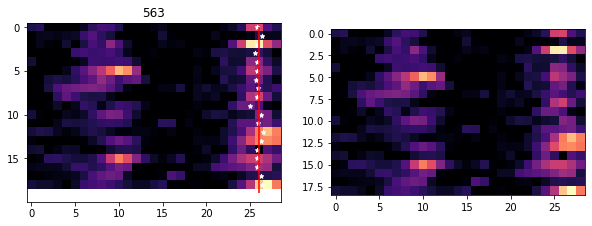

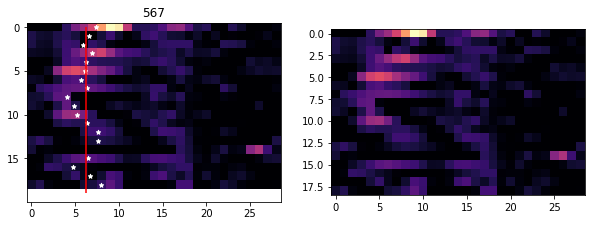

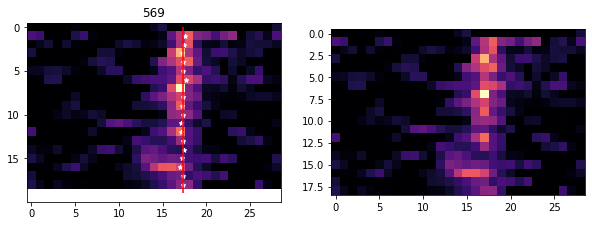

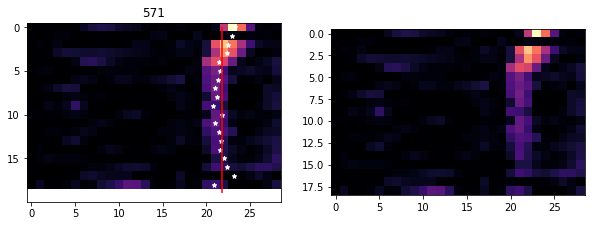

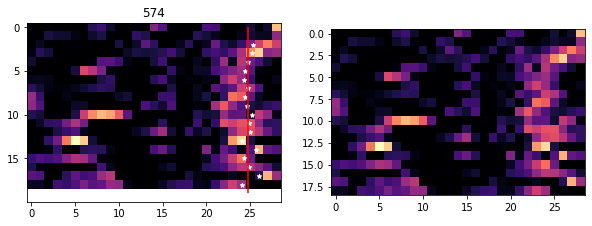

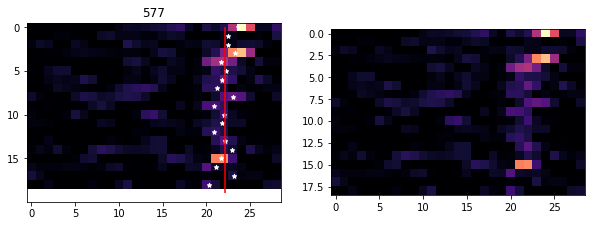

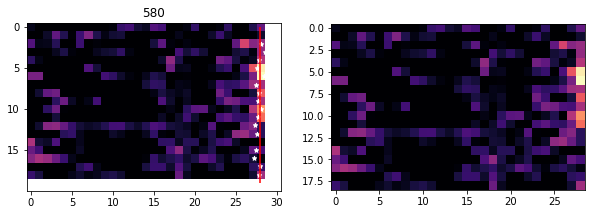

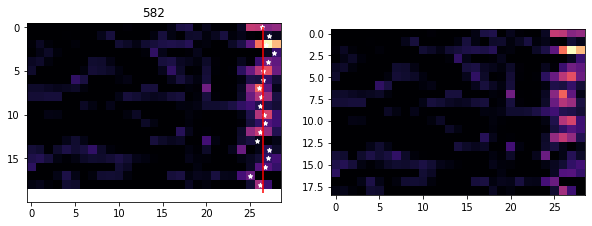

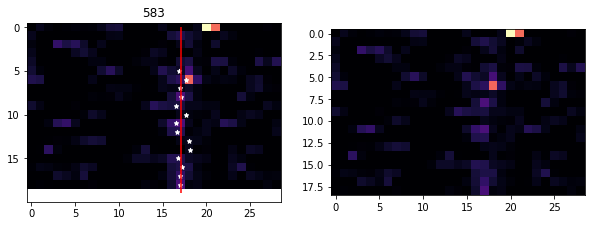

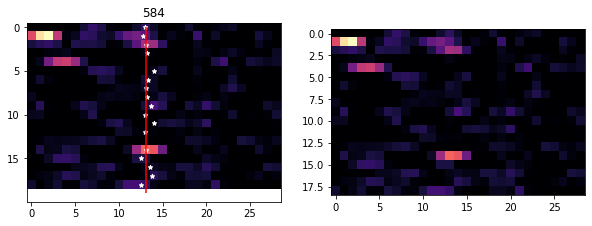

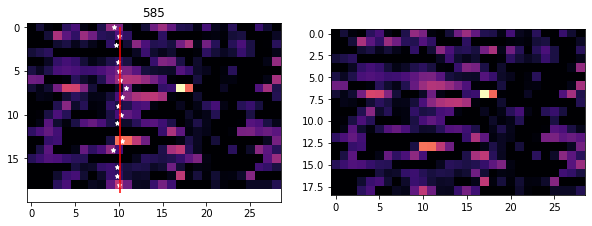

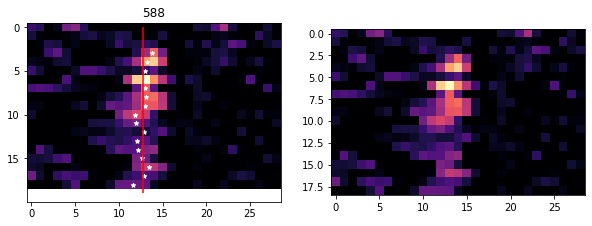

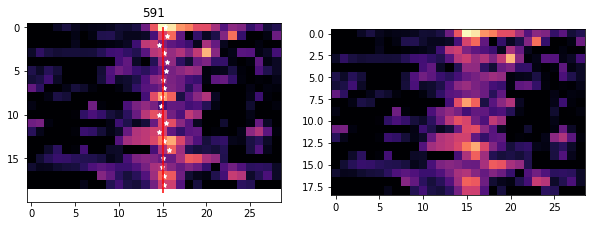

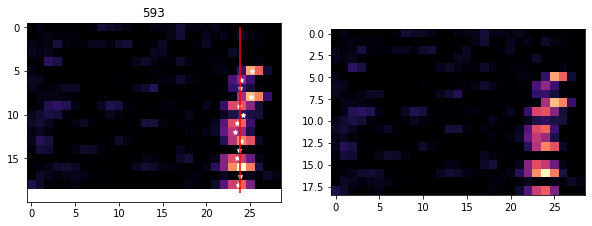

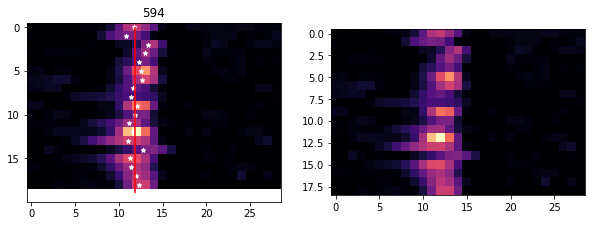

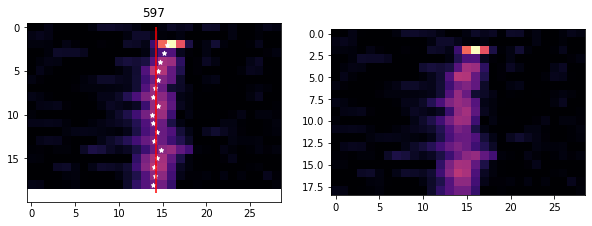

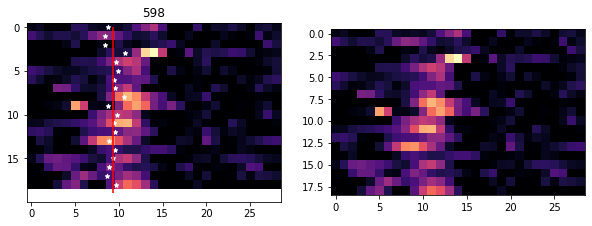

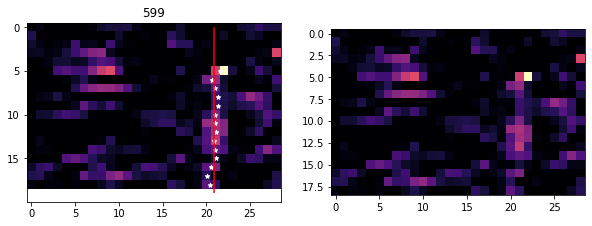

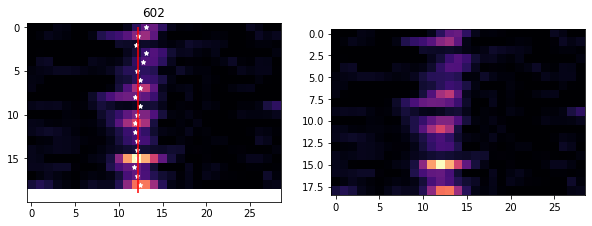

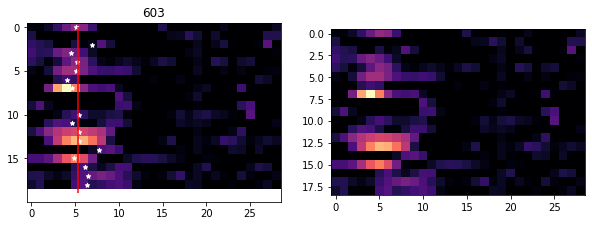

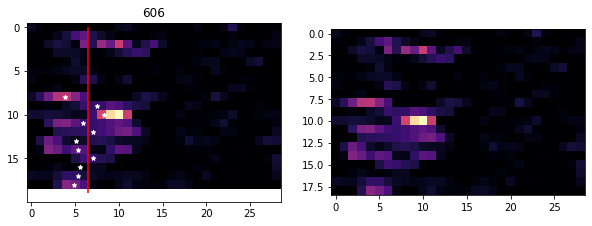

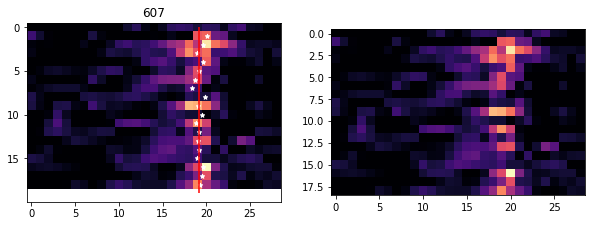

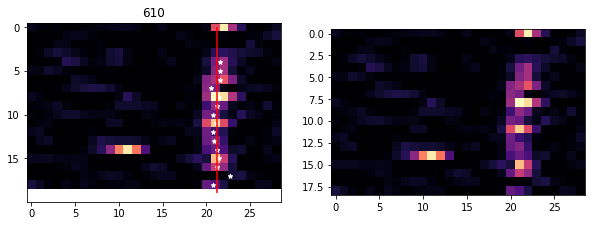

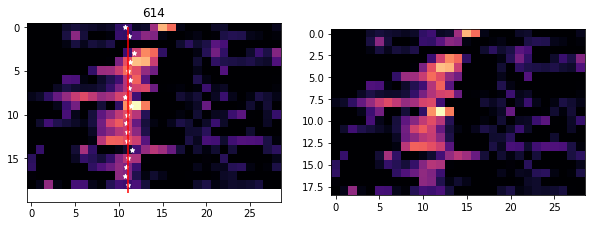

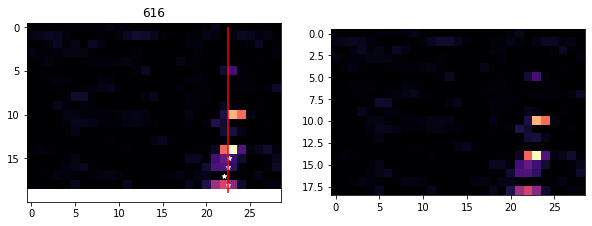

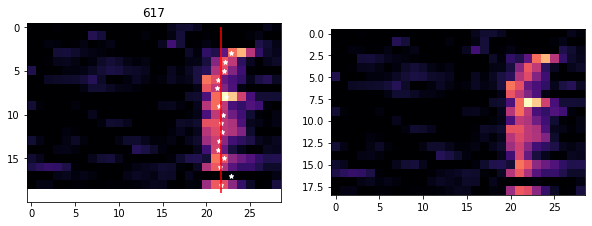

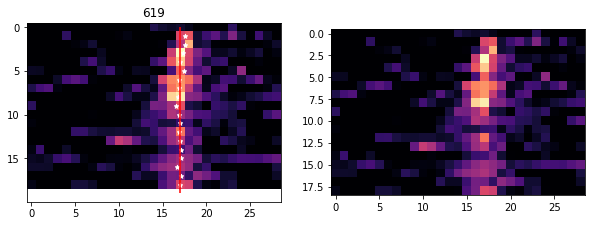

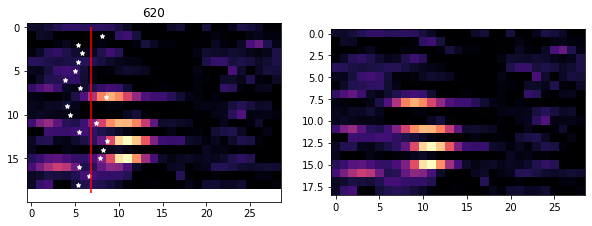

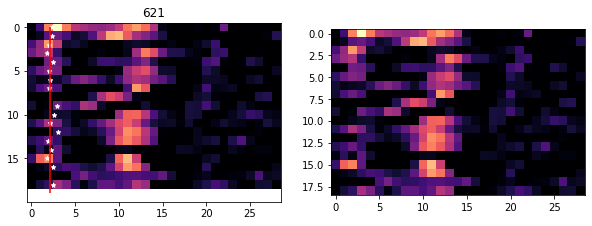

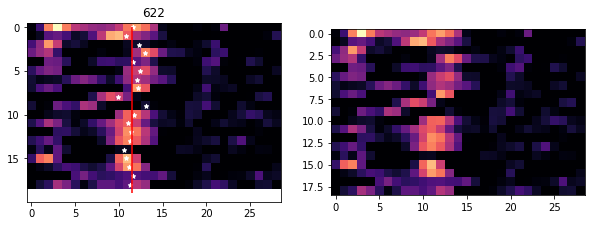

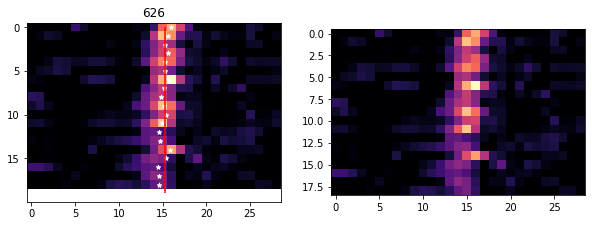

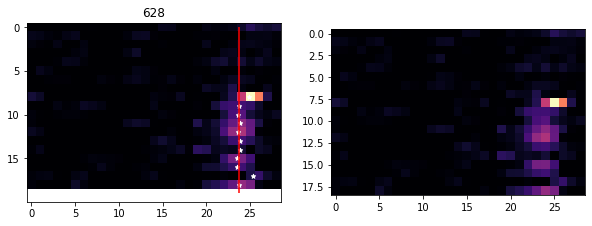

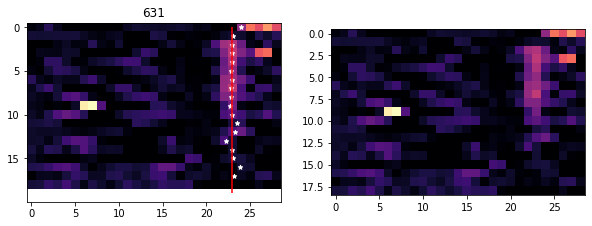

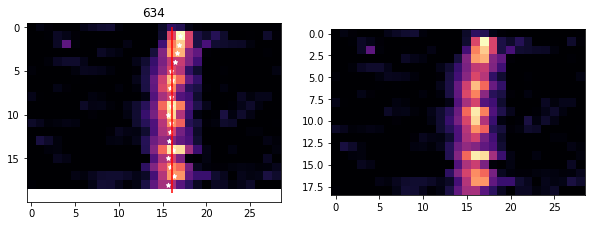

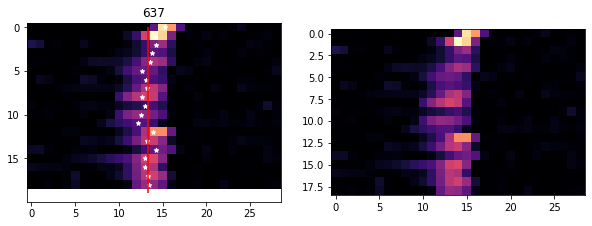

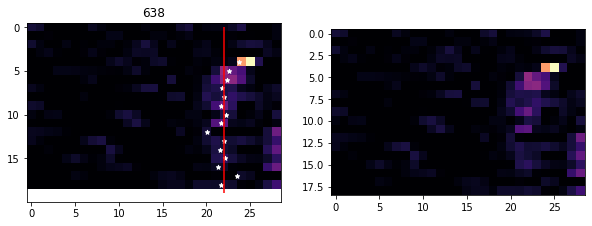

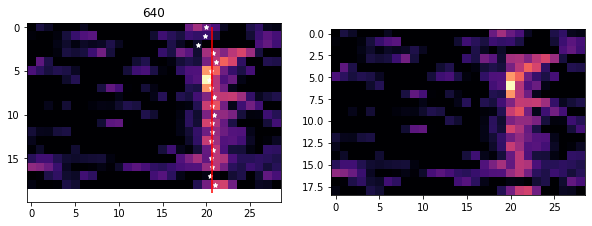

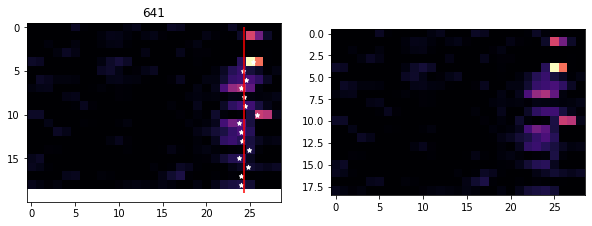

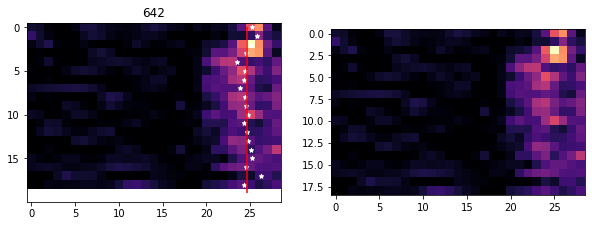

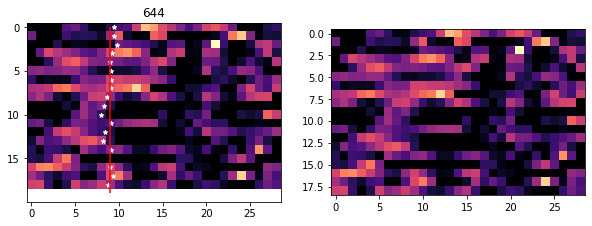

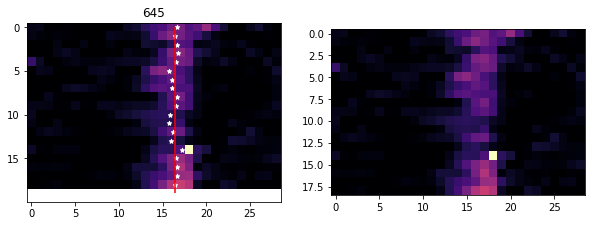

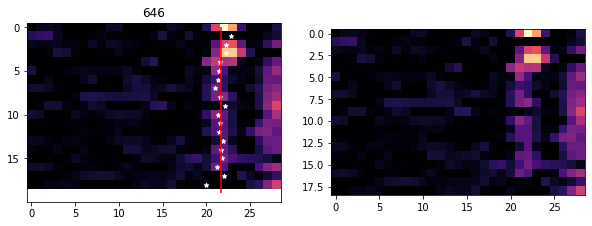

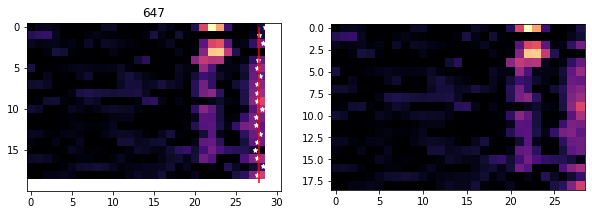

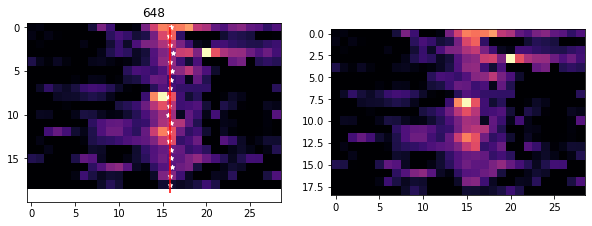

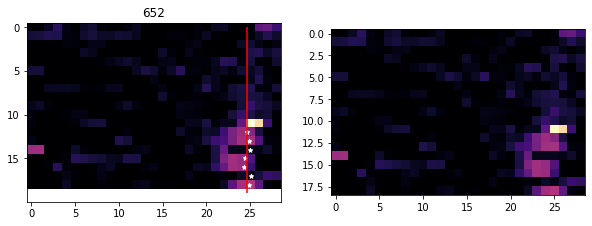

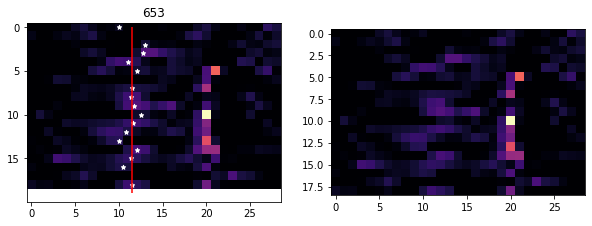

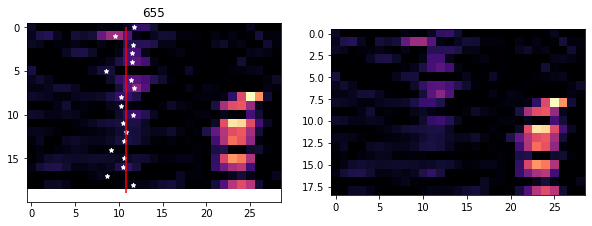

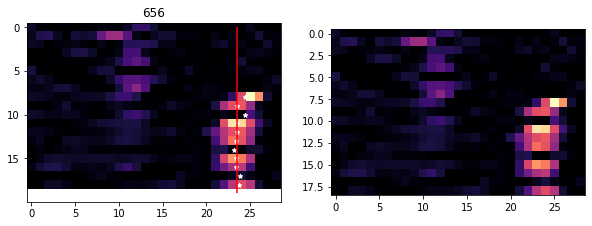

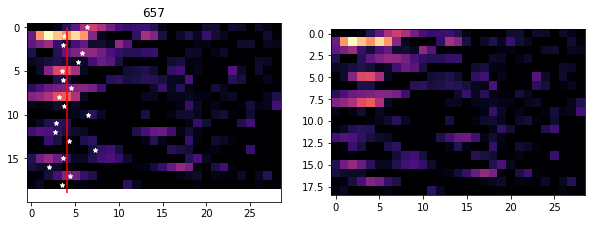

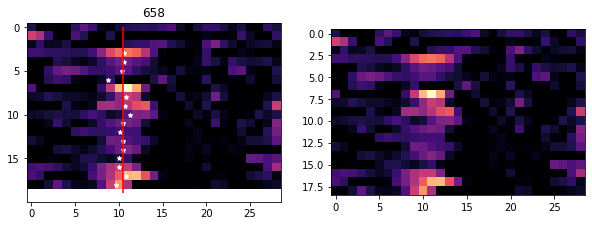

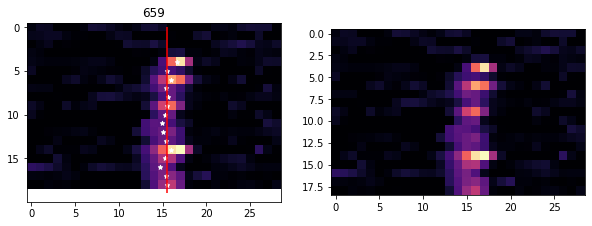

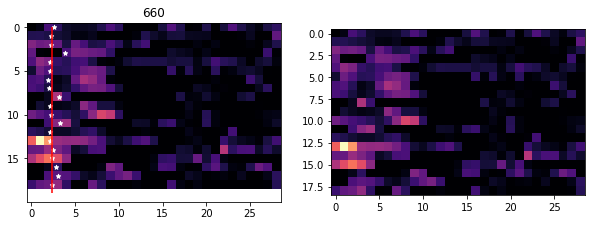

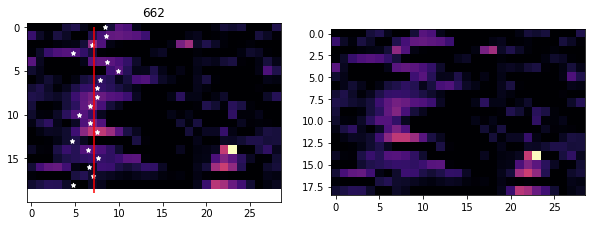

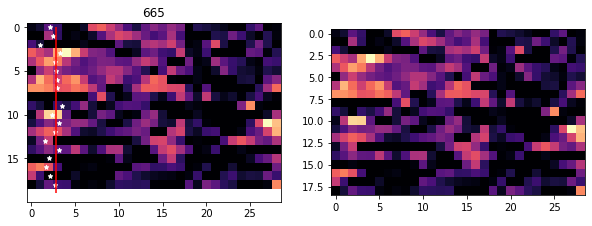

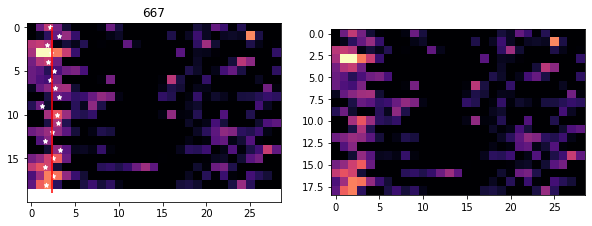

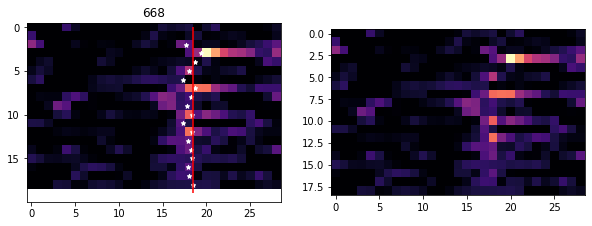

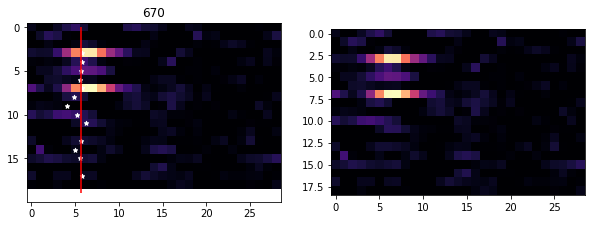

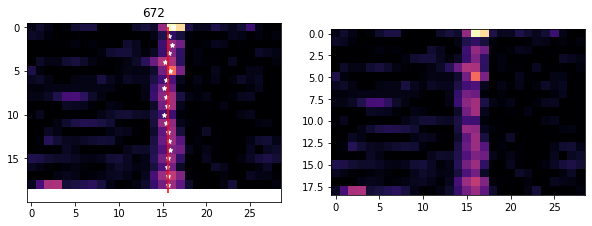

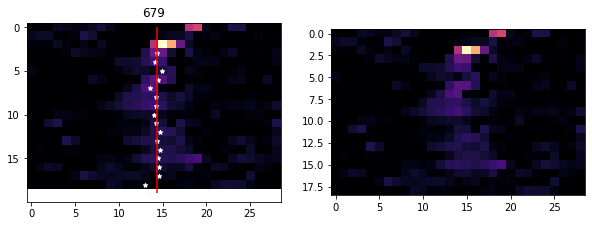

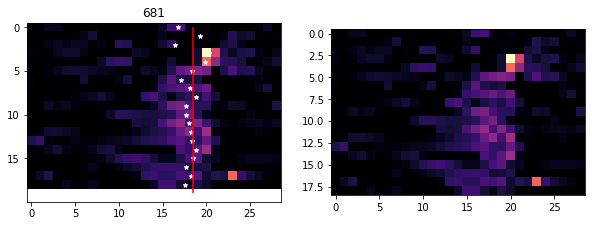

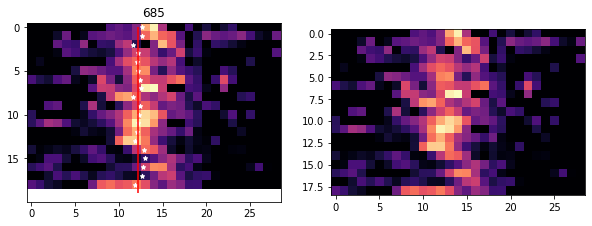

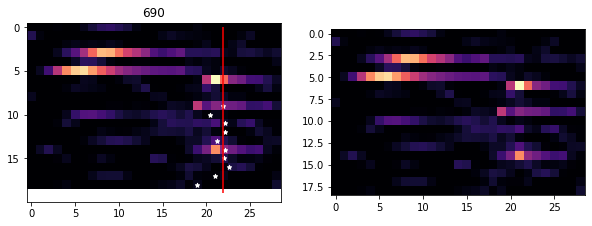

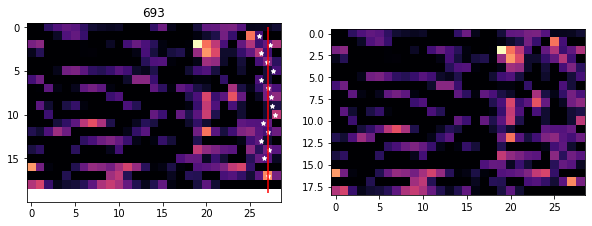

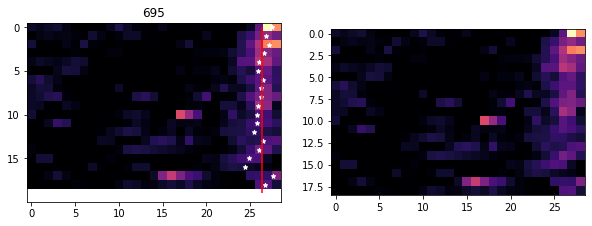

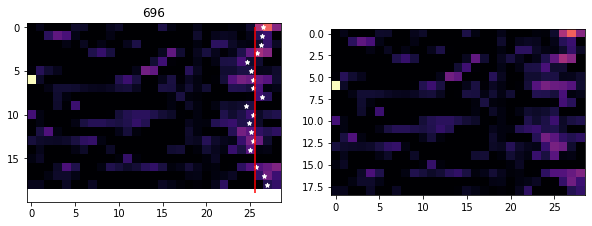

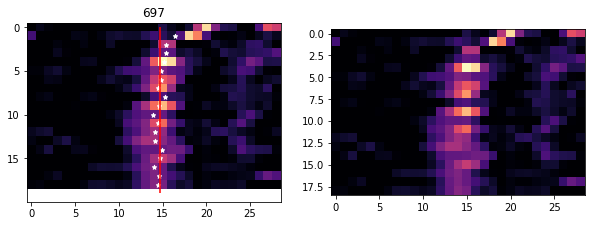

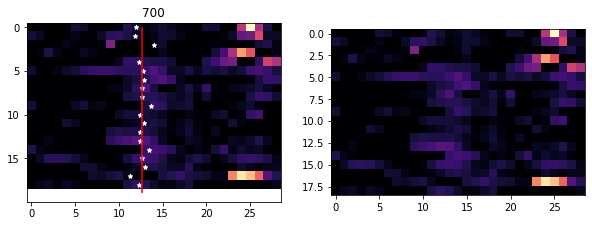

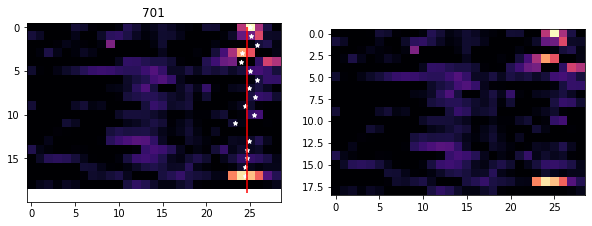

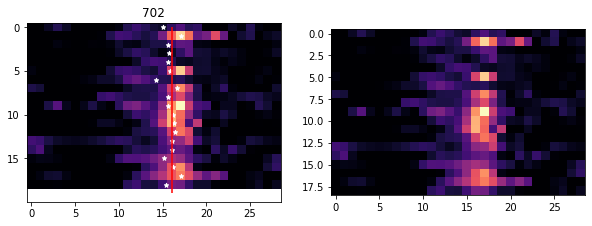

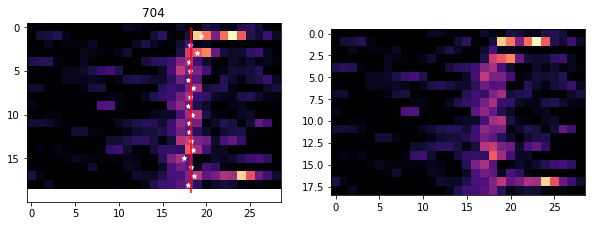

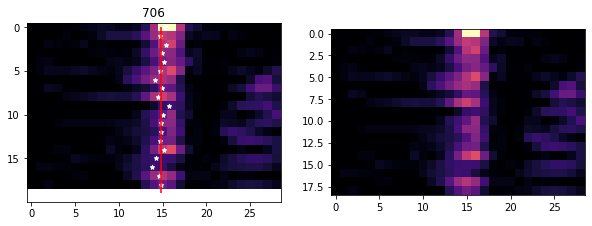

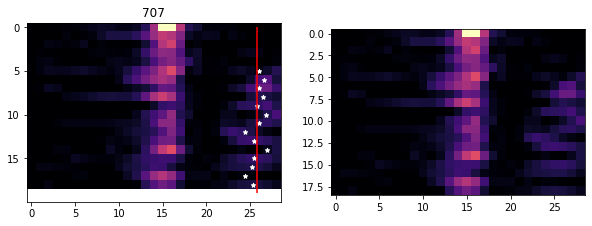

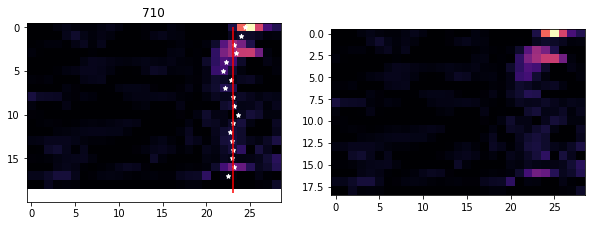

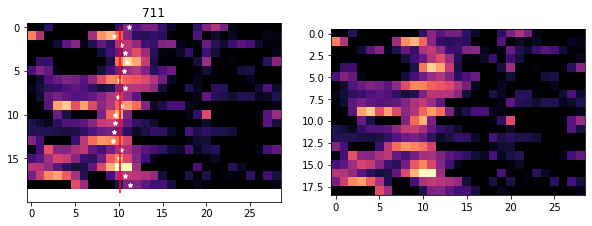

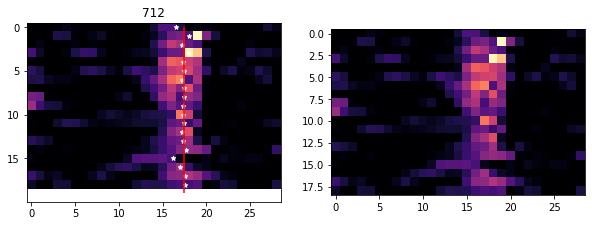

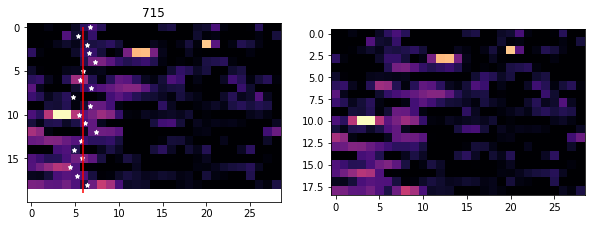

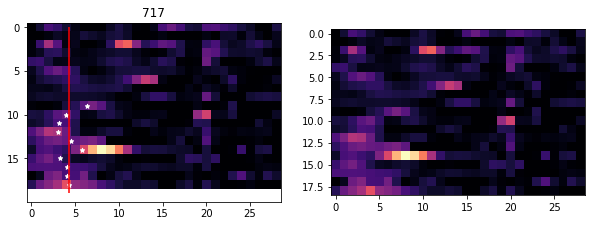

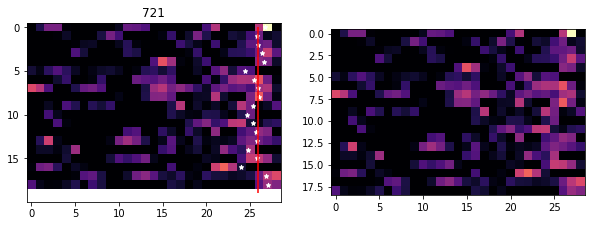

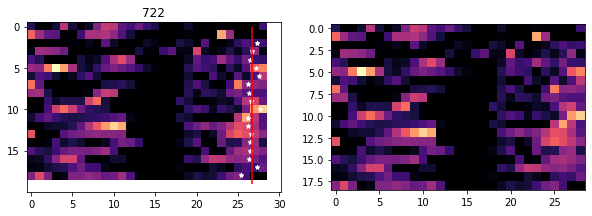

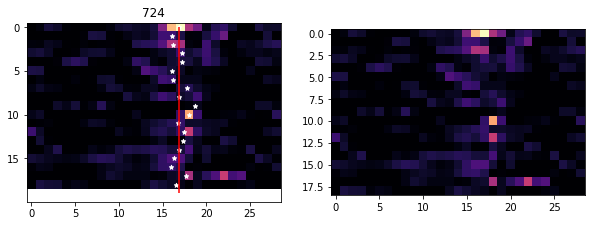

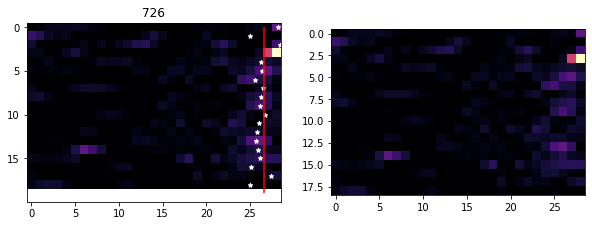

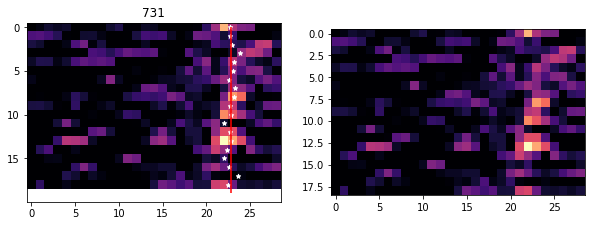

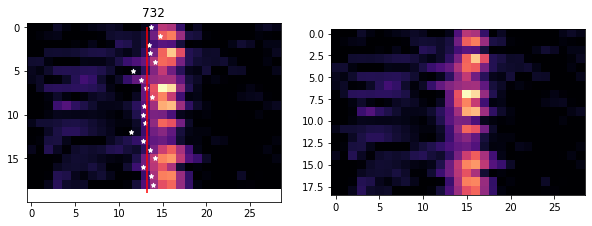

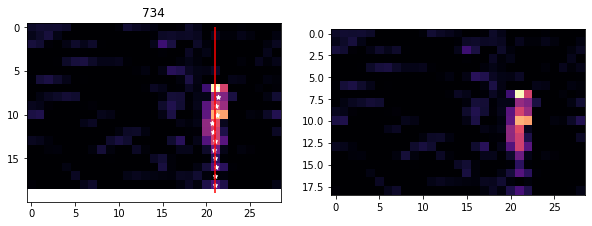

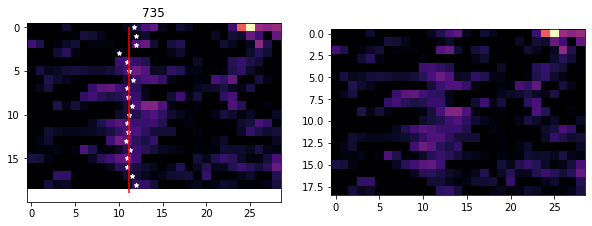

In [21]:

_ = field_shifts(ctrl_mice[0], 0, ctrl_field_mask_res, 'nov', plot=True, act_th = .2, pcnt_th = .2)

{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}


<ipython-input-6-6a8f90bf41bc>:28: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:][:,np.maximum(ledge[field,1],0):redge[field,1]],axis=1)
<ipython-input-6-6a8f90bf41bc>:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2, figsize= [10,5])


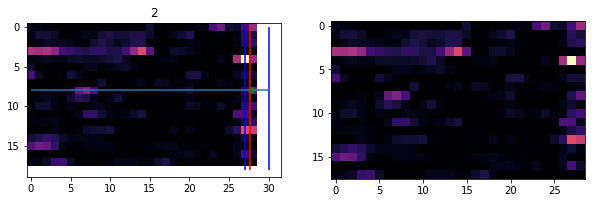

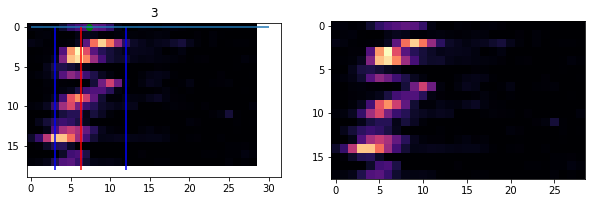

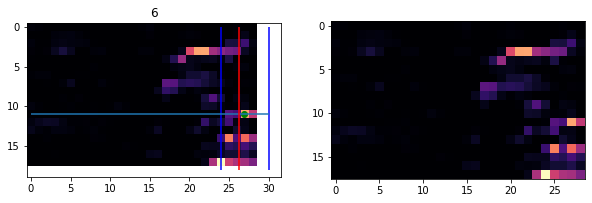

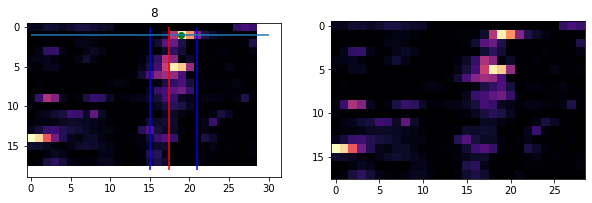

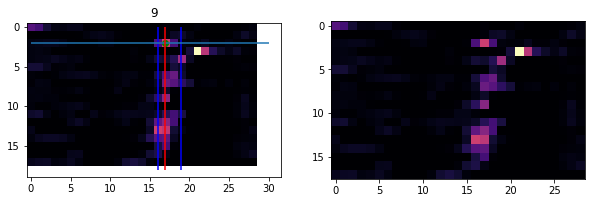

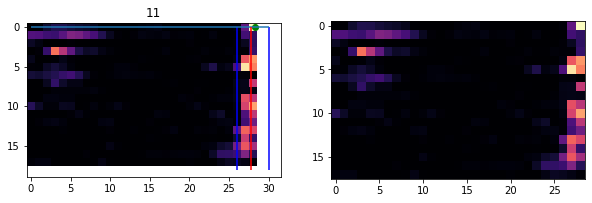

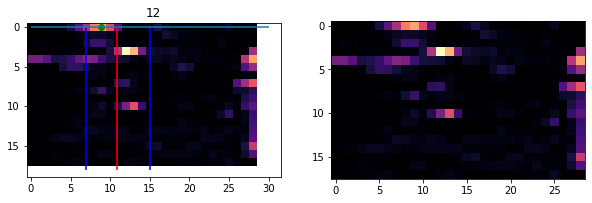

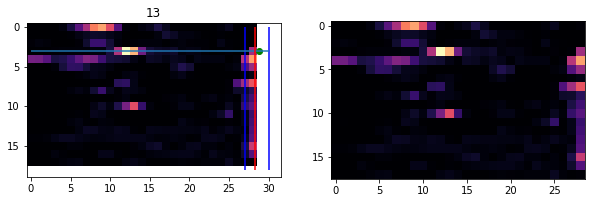

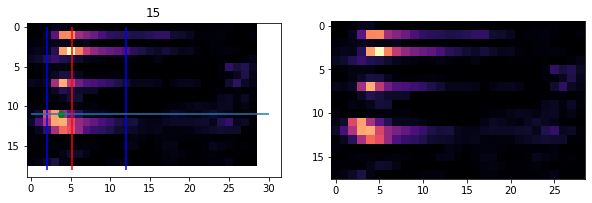

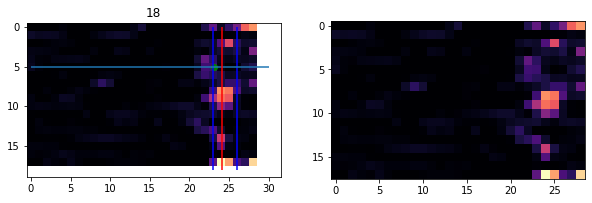

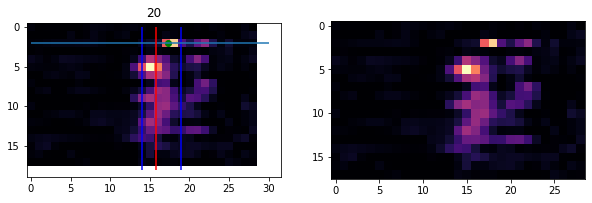

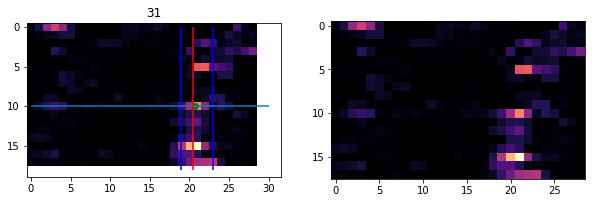

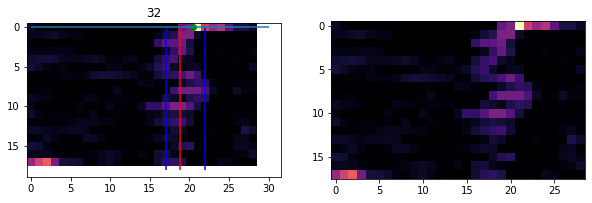

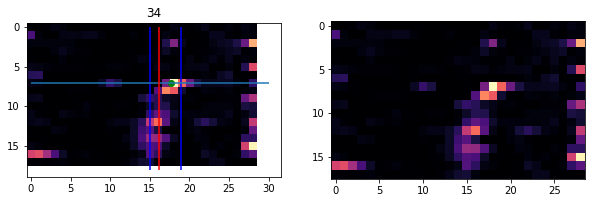

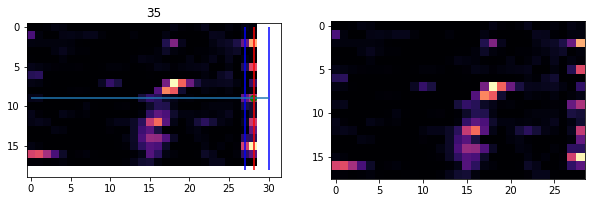

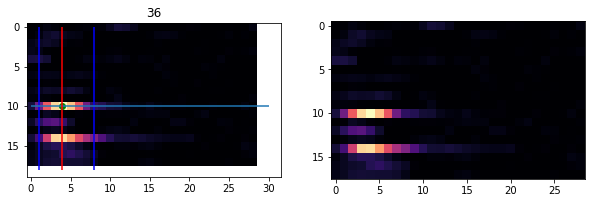

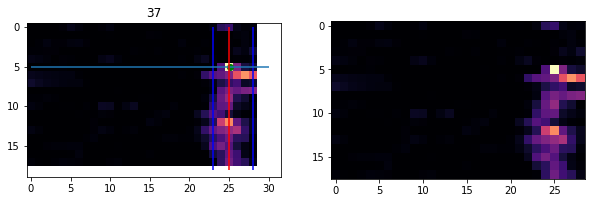

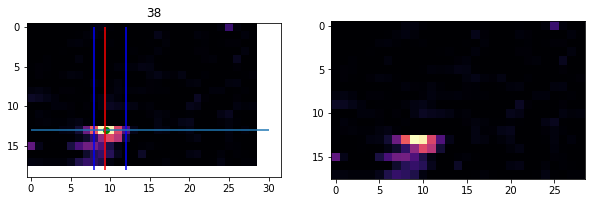

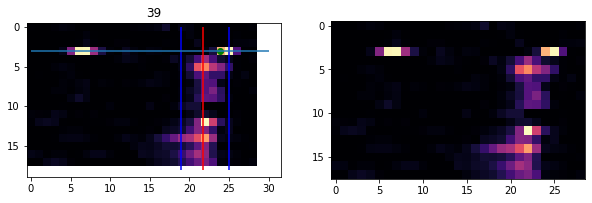

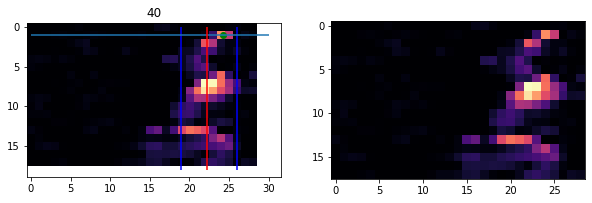

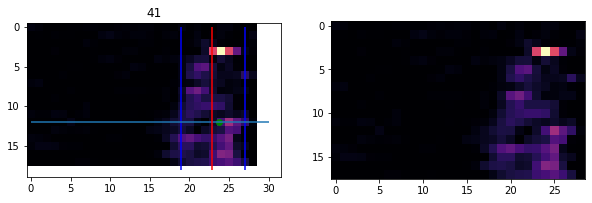

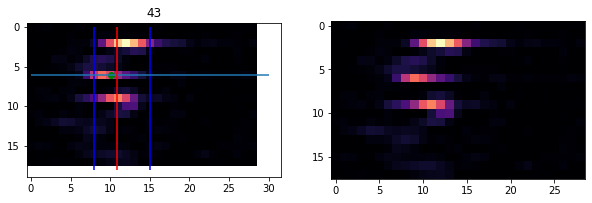

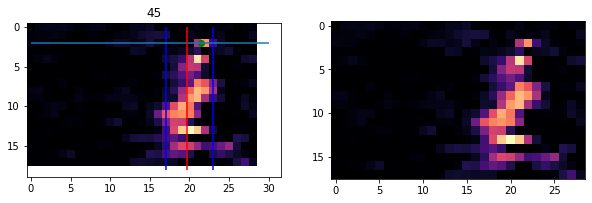

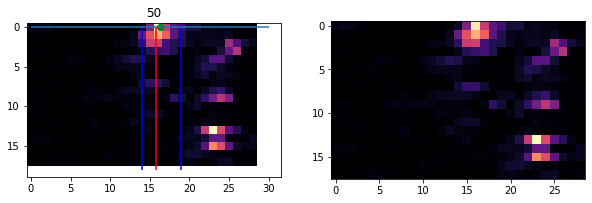

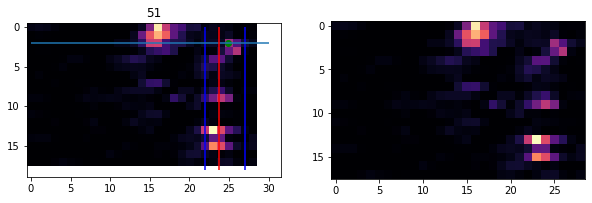

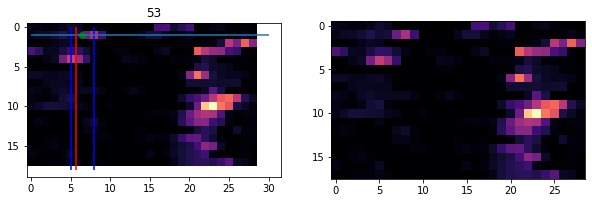

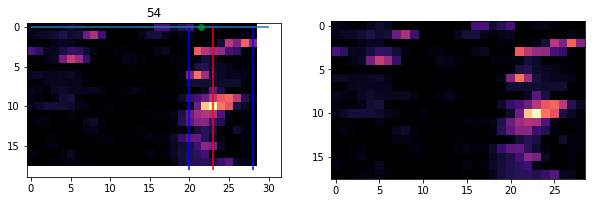

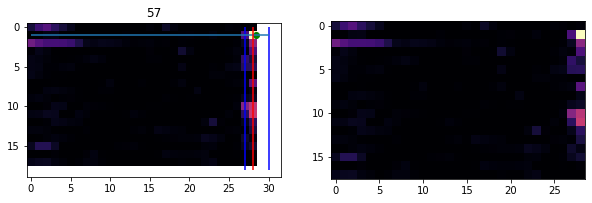

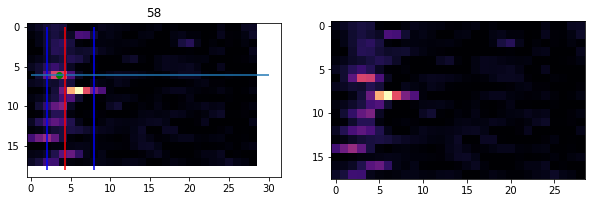

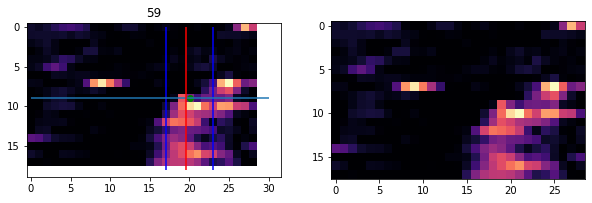

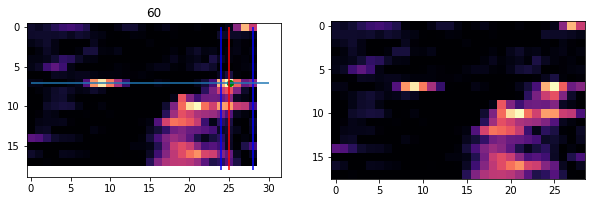

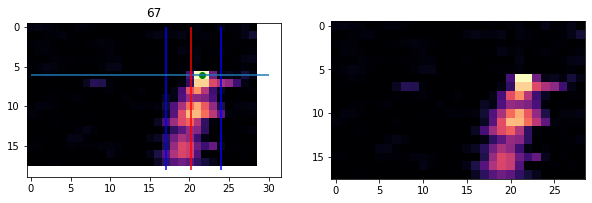

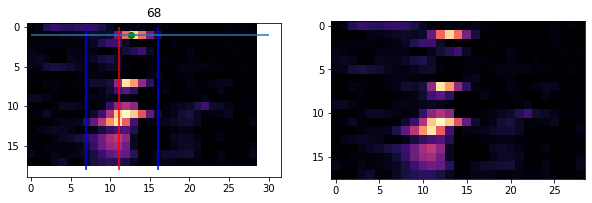

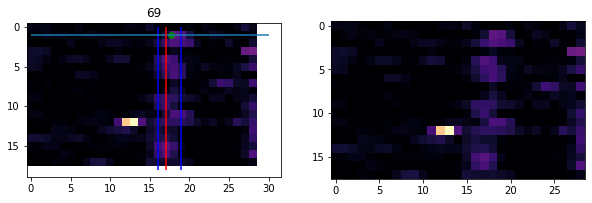

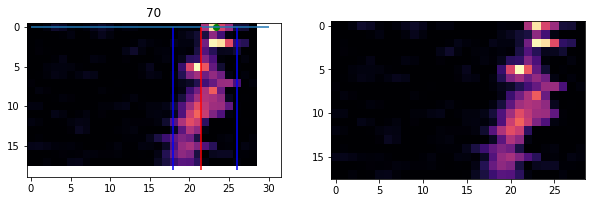

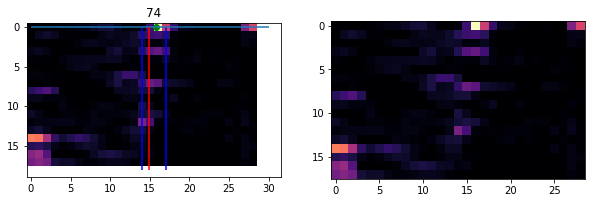

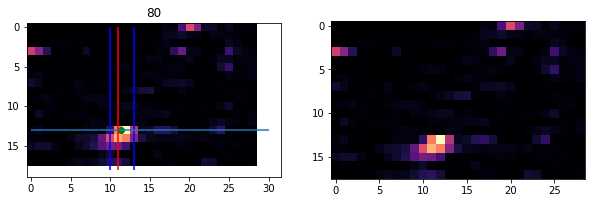

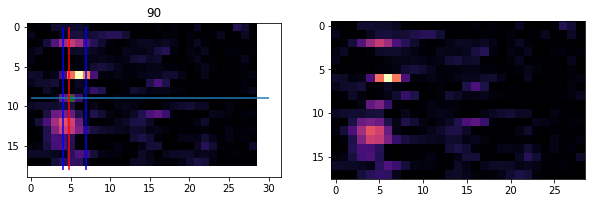

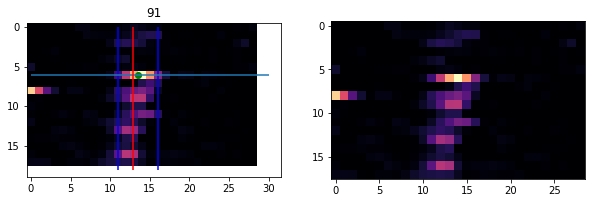

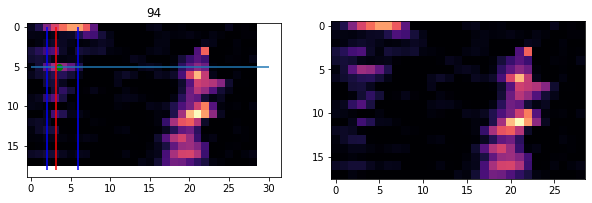

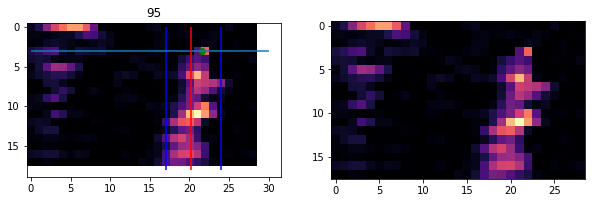

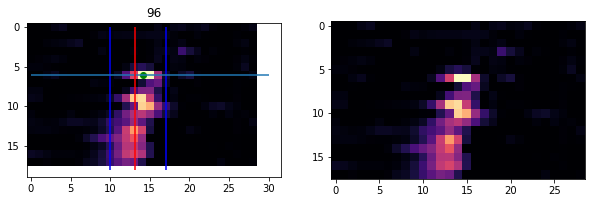

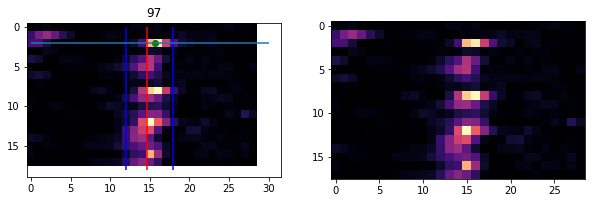

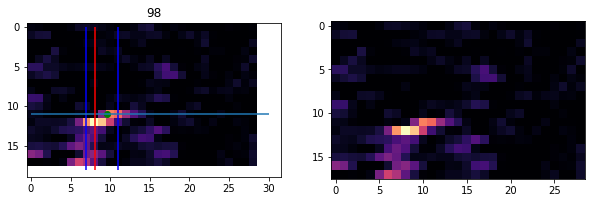

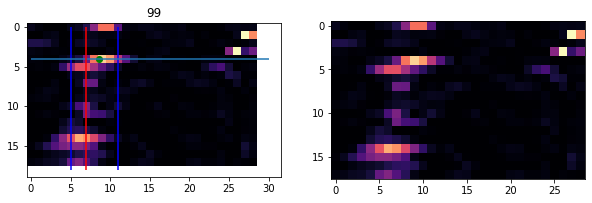

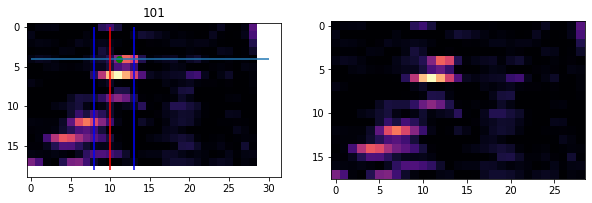

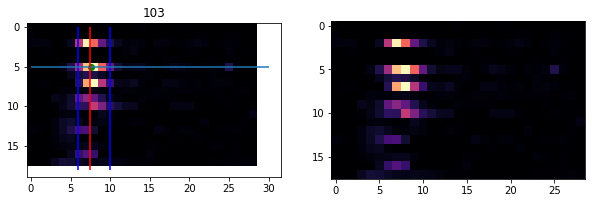

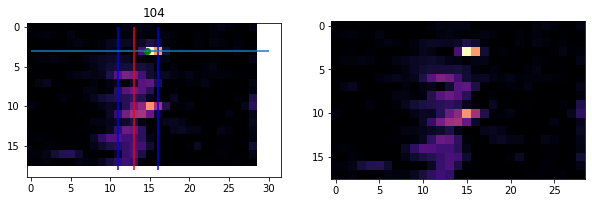

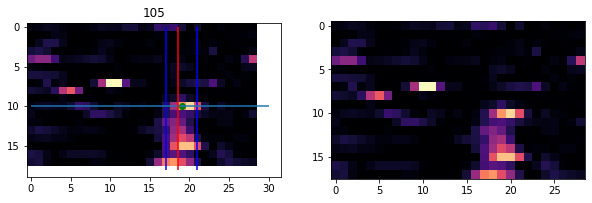

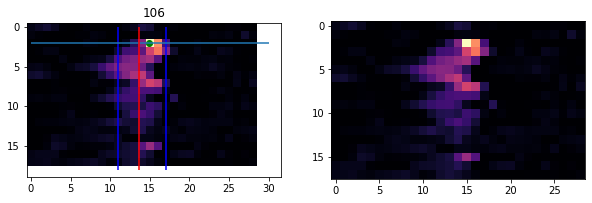

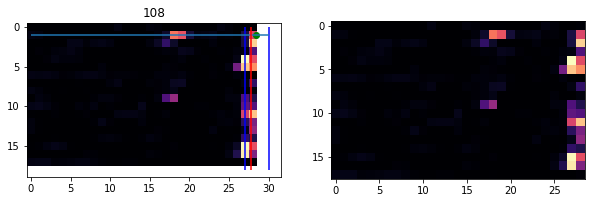

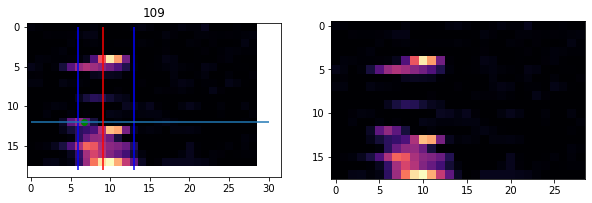

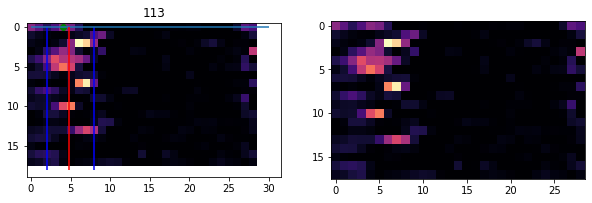

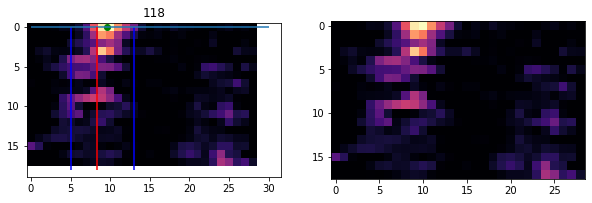

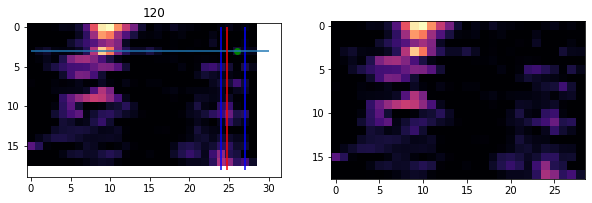

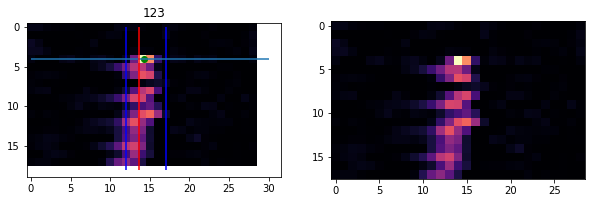

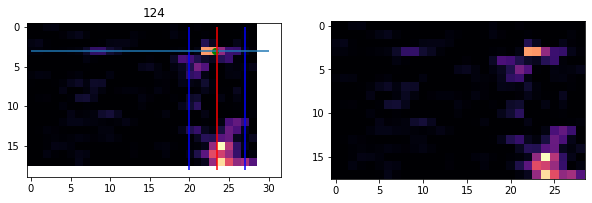

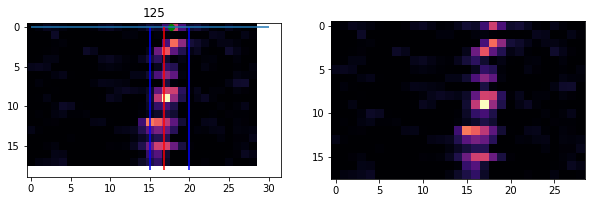

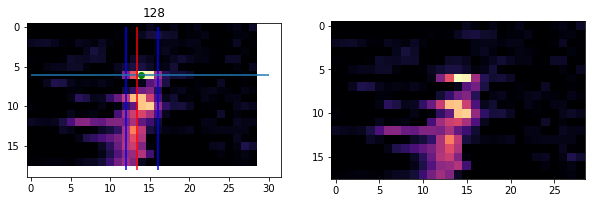

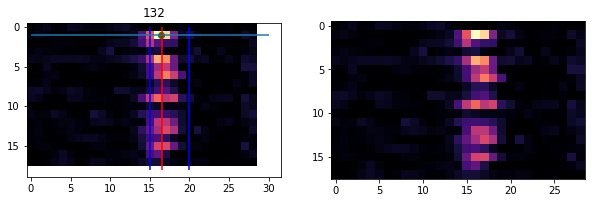

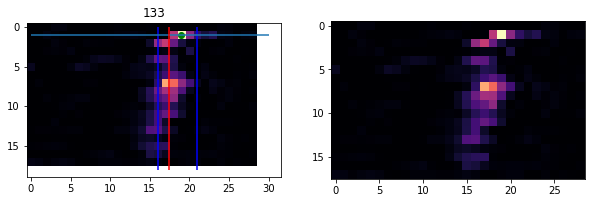

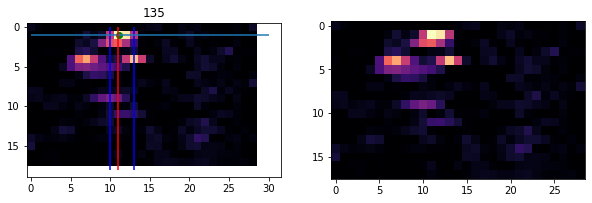

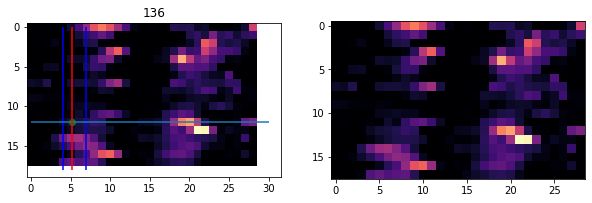

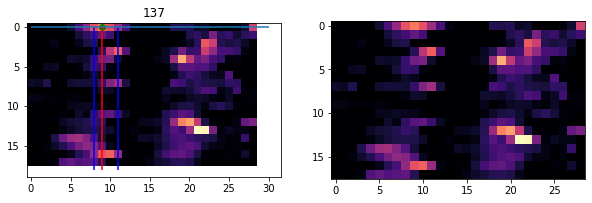

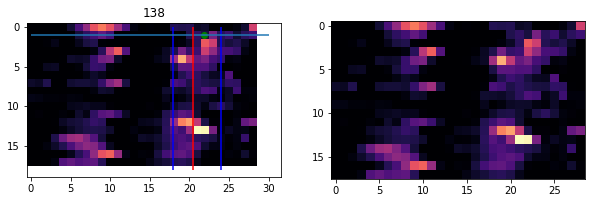

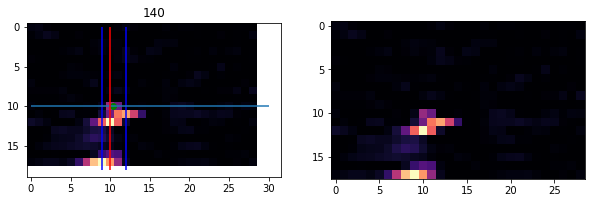

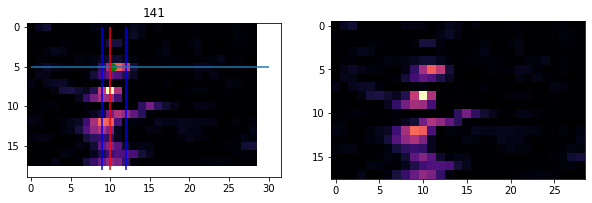

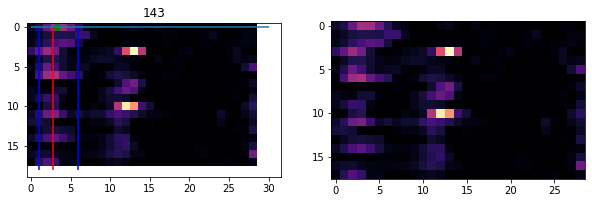

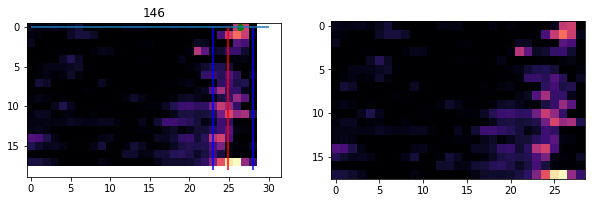

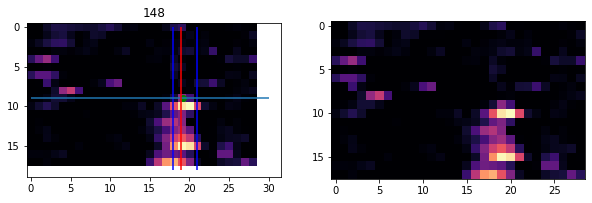

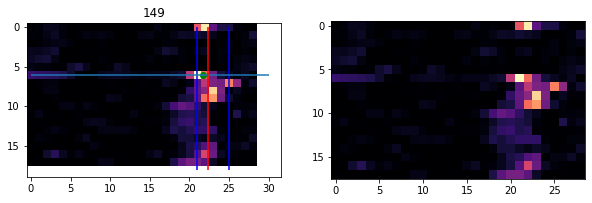

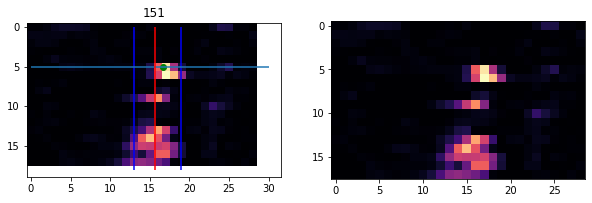

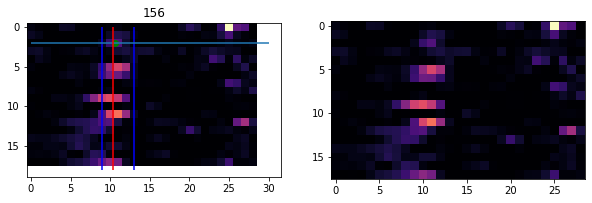

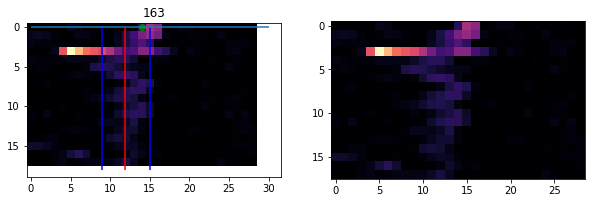

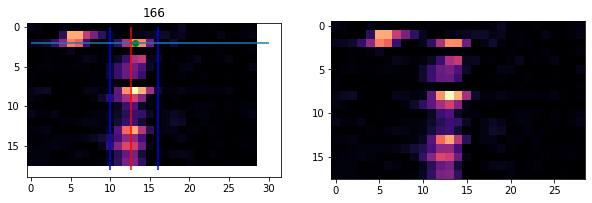

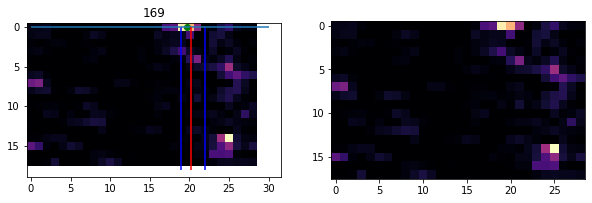

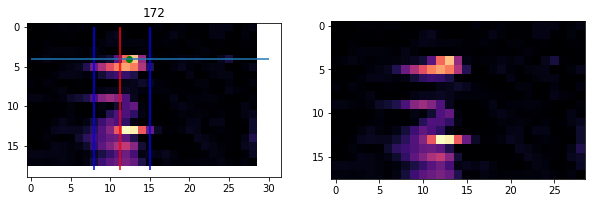

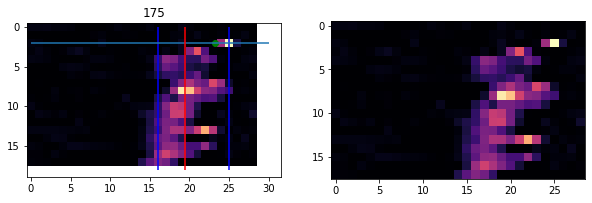

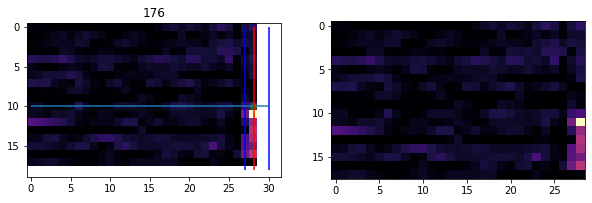

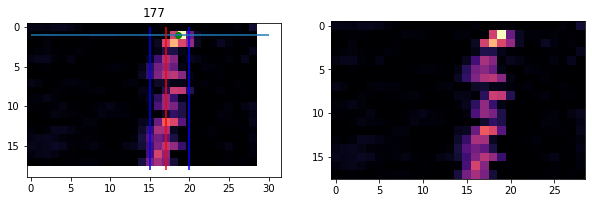

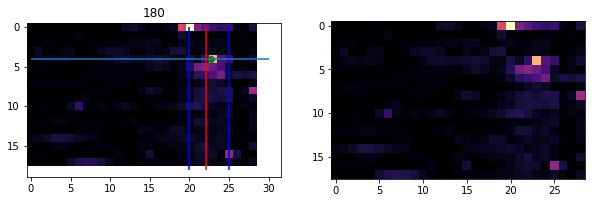

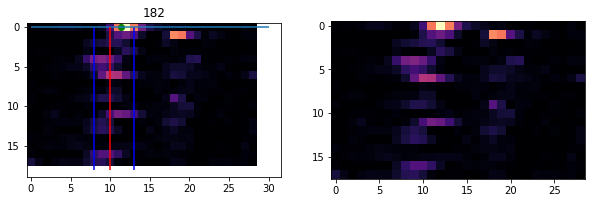

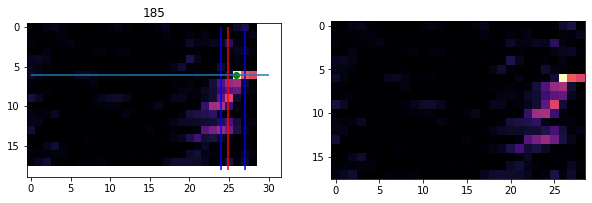

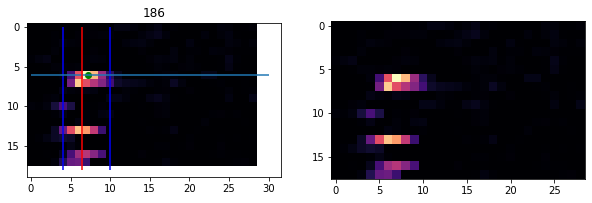

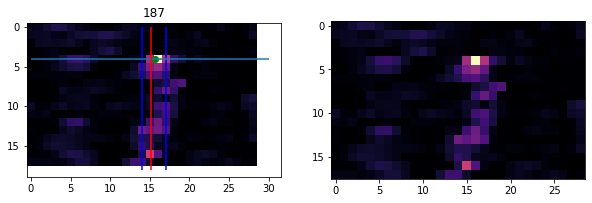

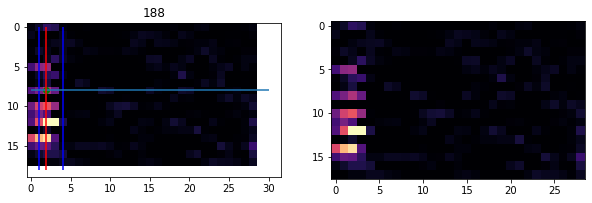

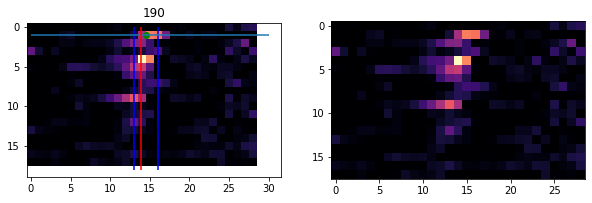

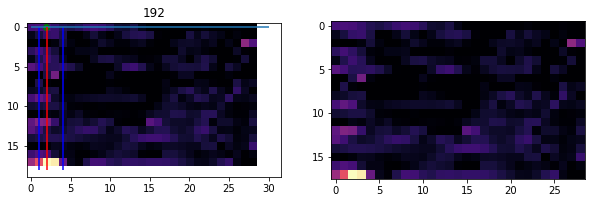

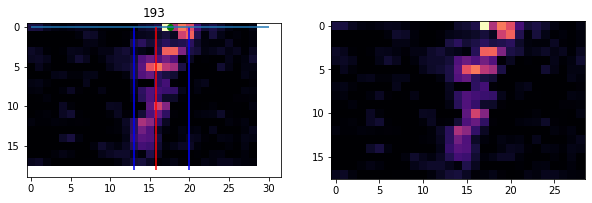

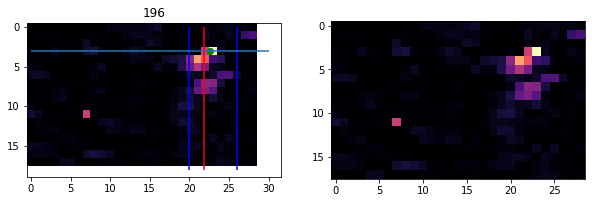

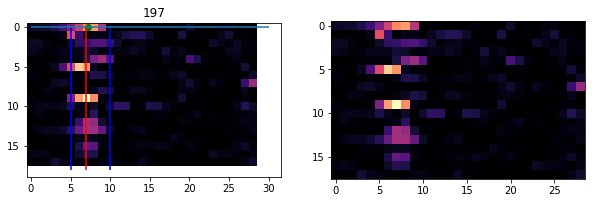

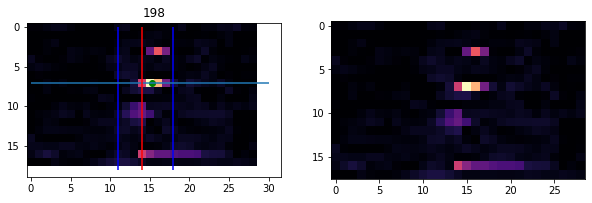

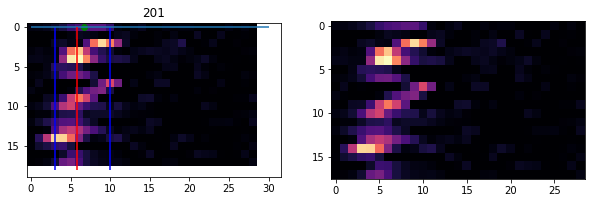

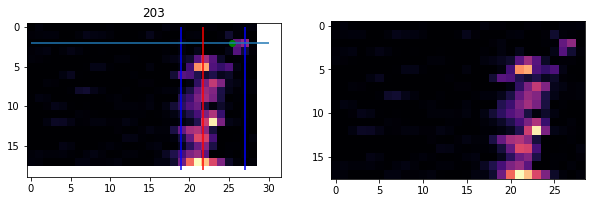

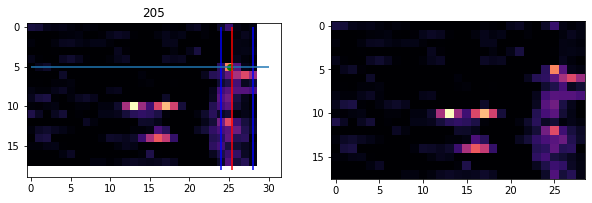

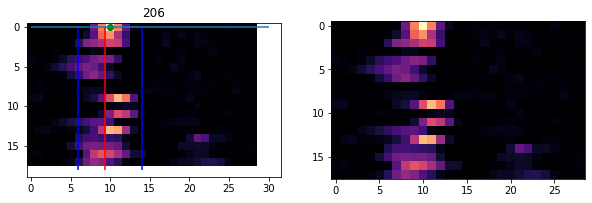

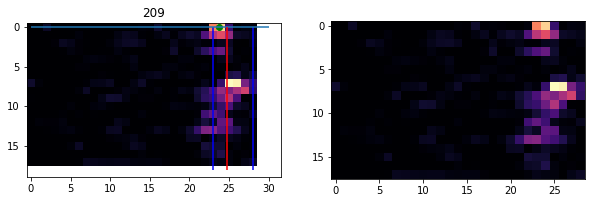

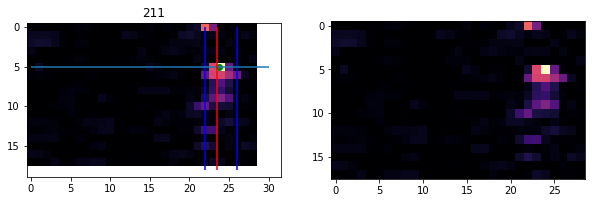

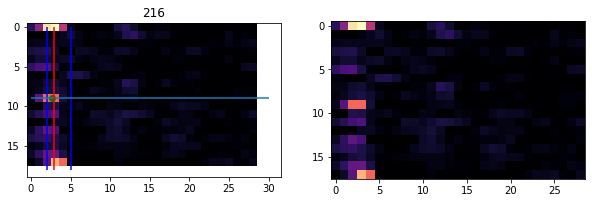

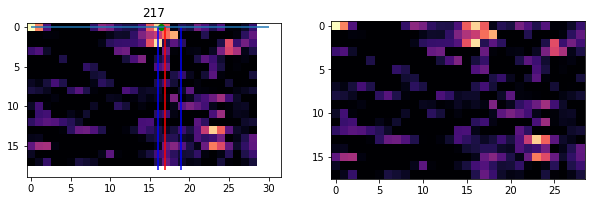

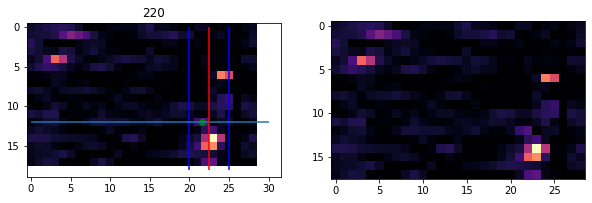

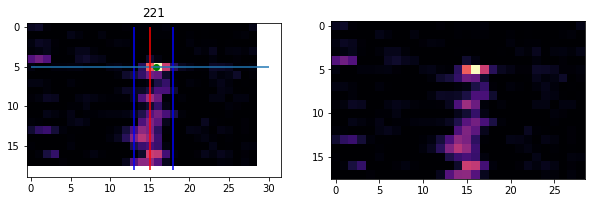

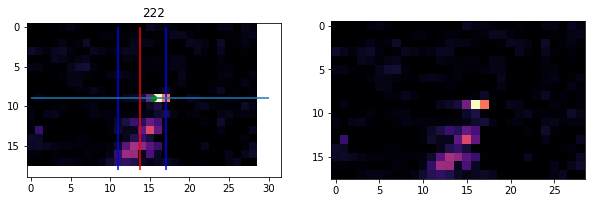

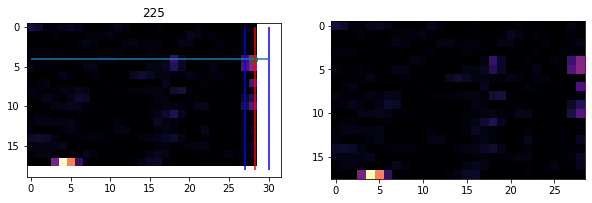

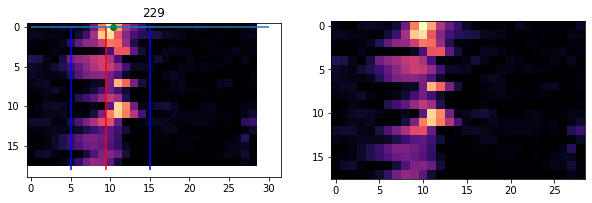

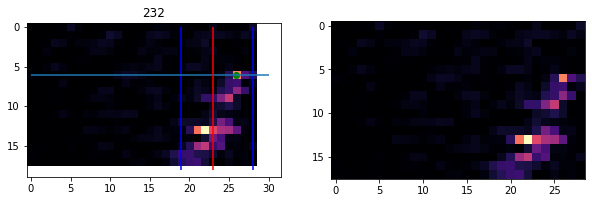

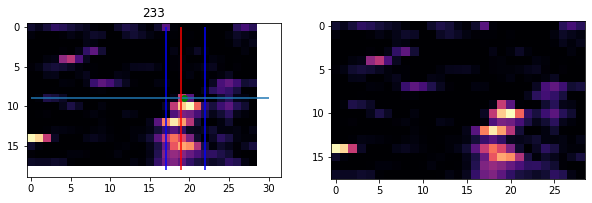

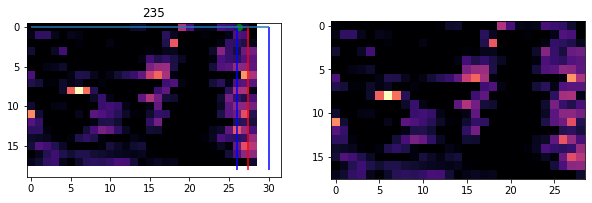

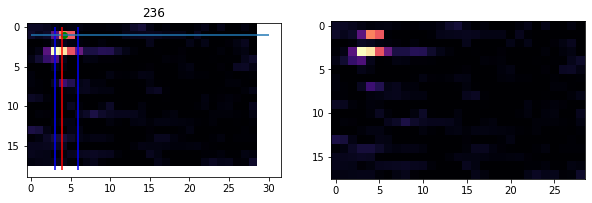

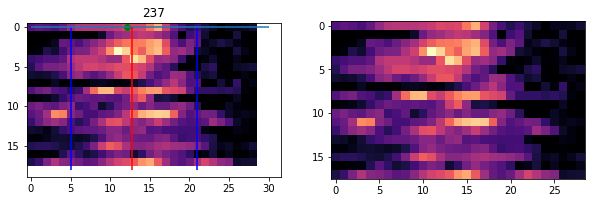

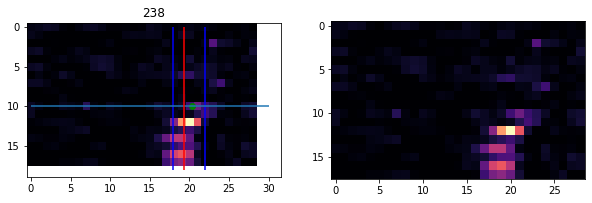

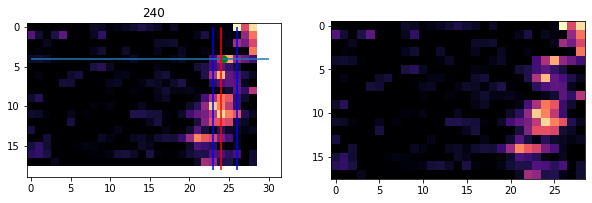

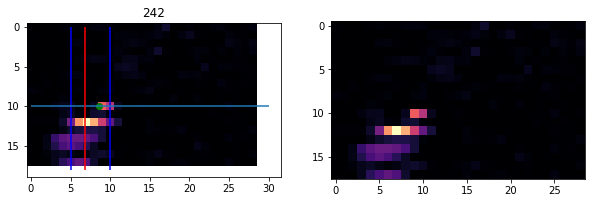

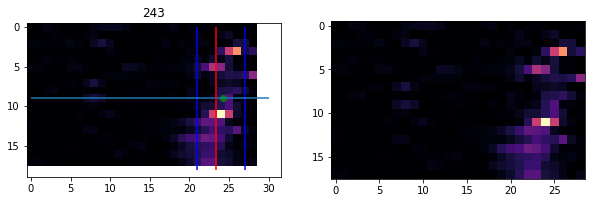

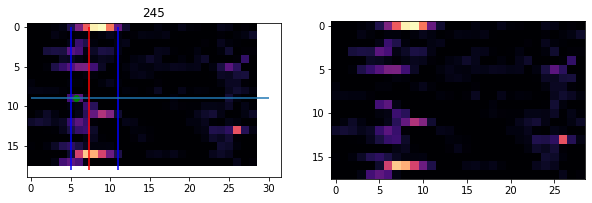

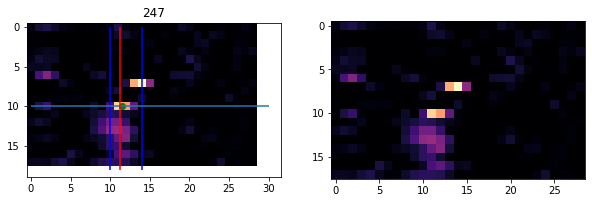

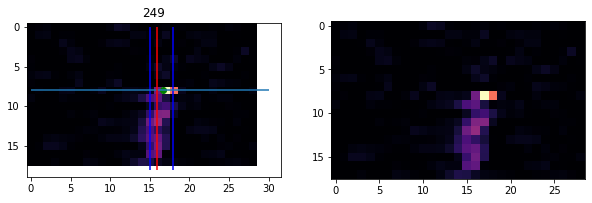

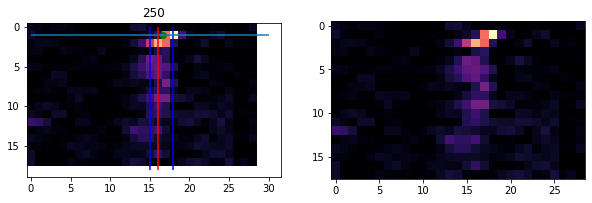

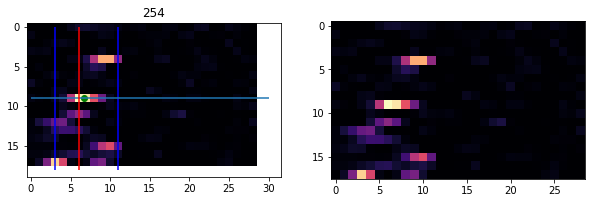

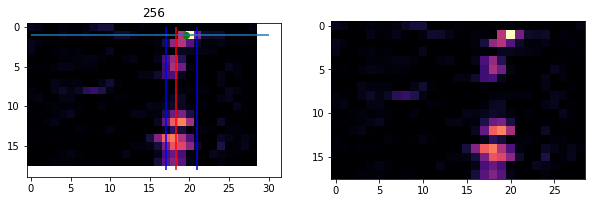

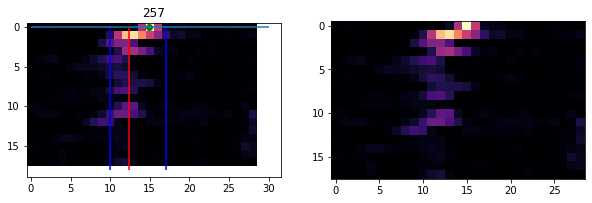

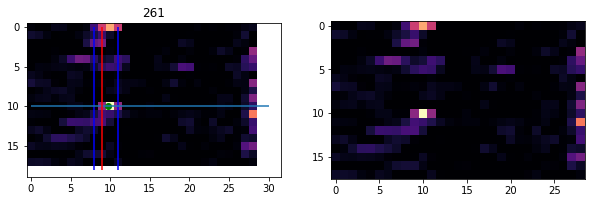

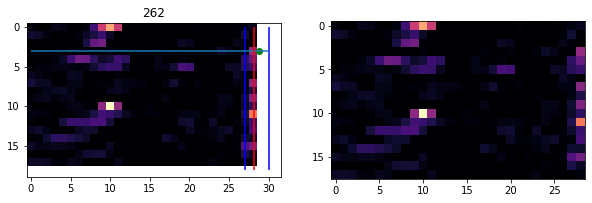

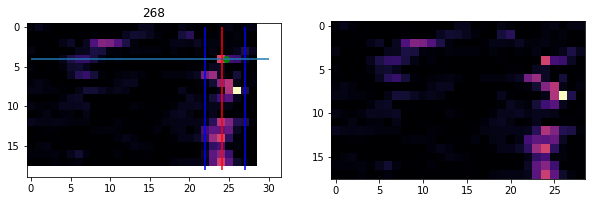

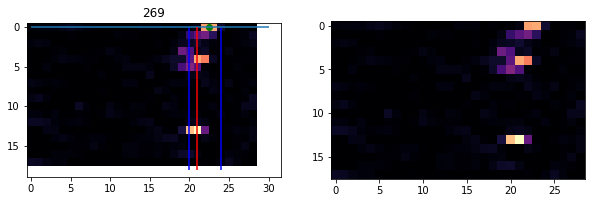

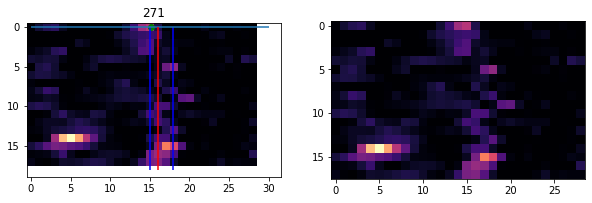

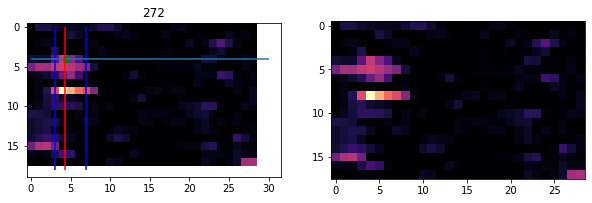

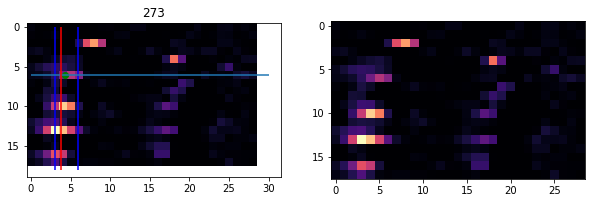

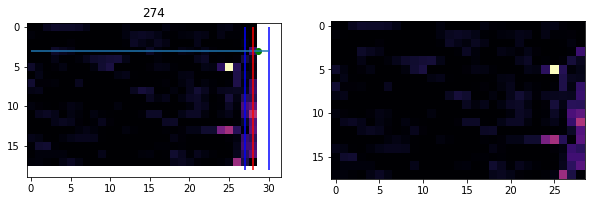

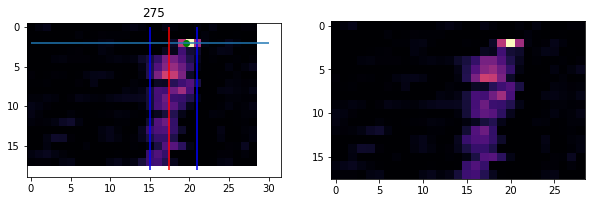

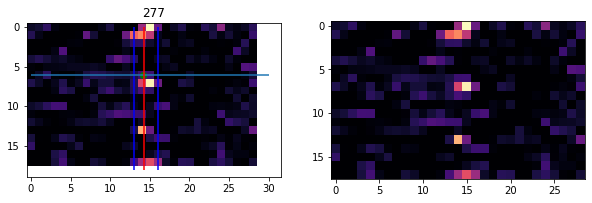

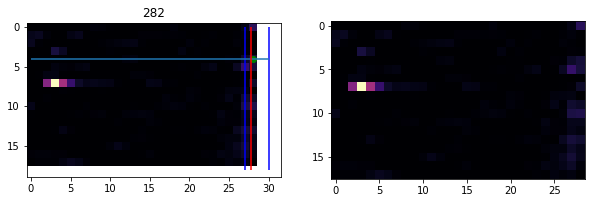

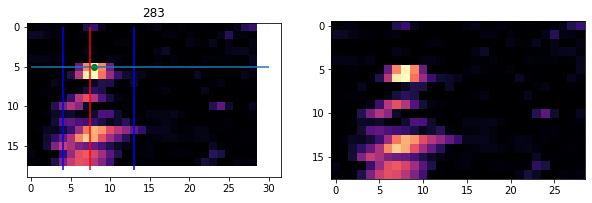

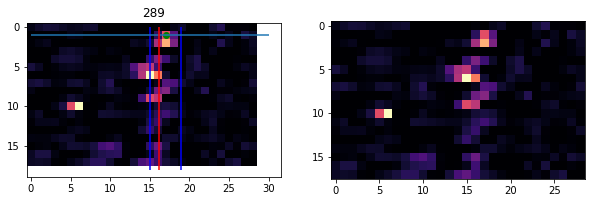

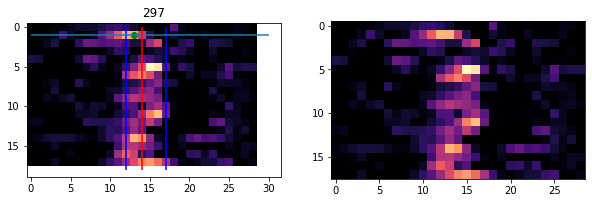

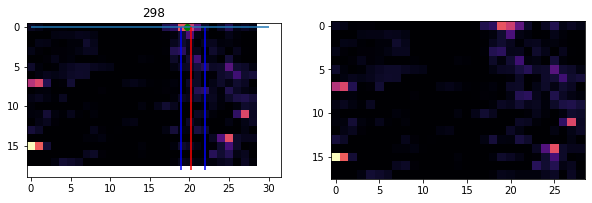

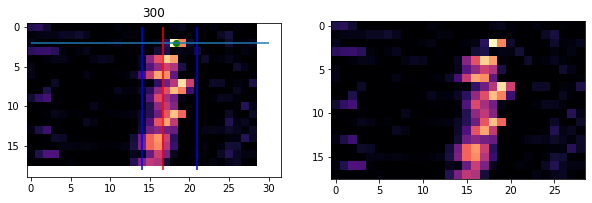

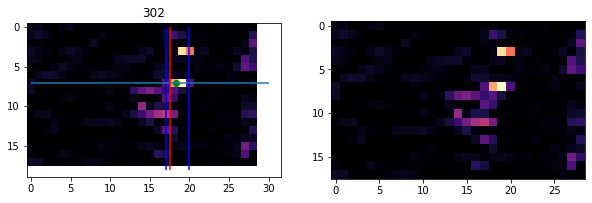

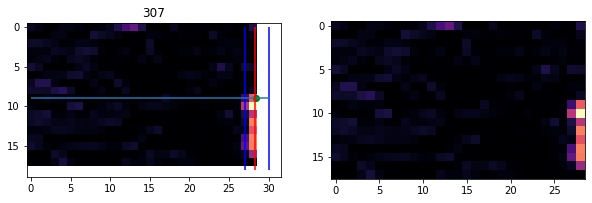

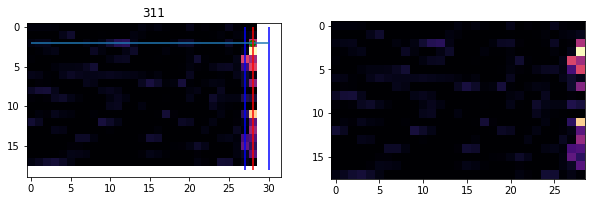

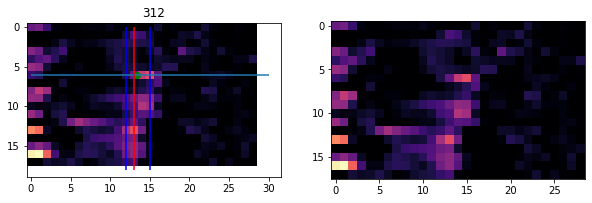

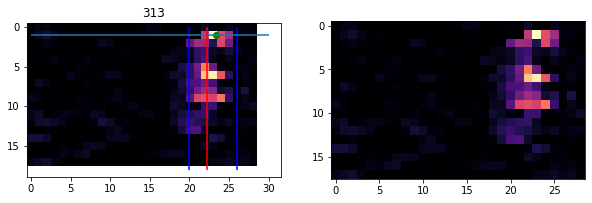

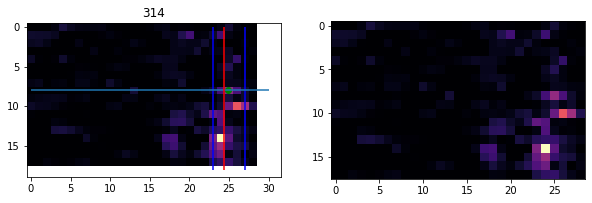

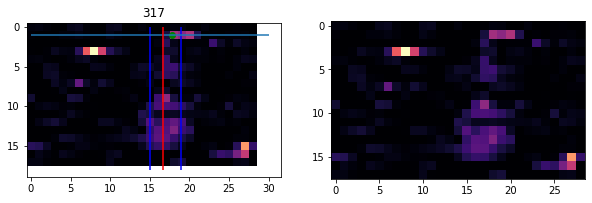

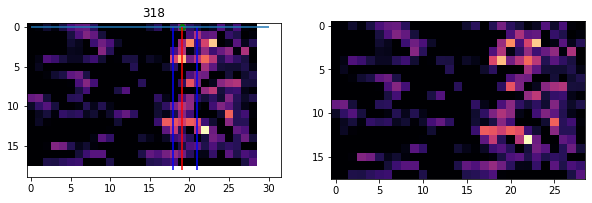

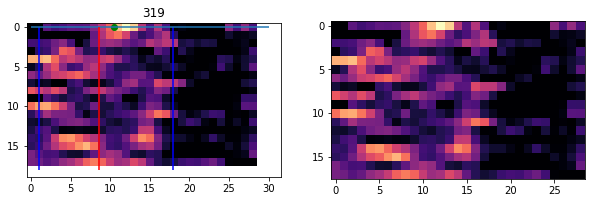

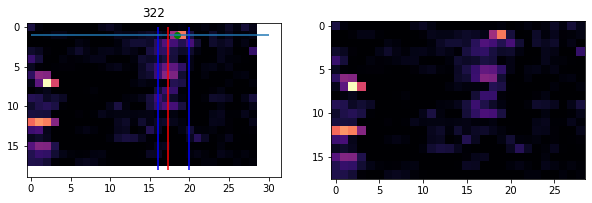

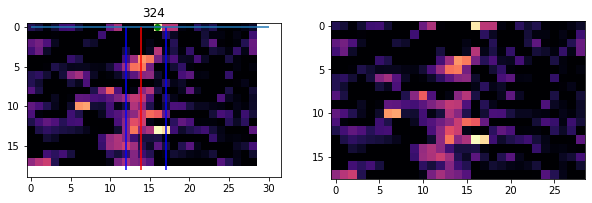

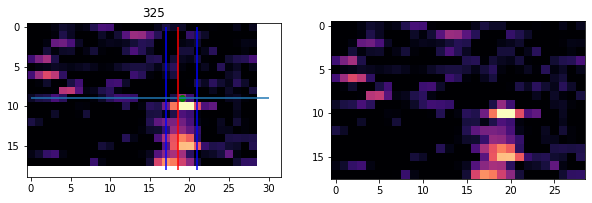

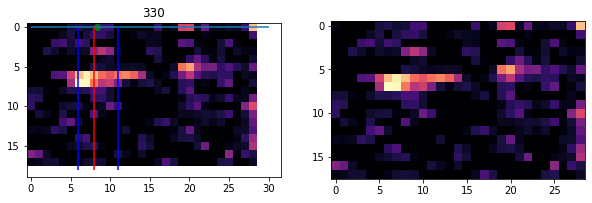

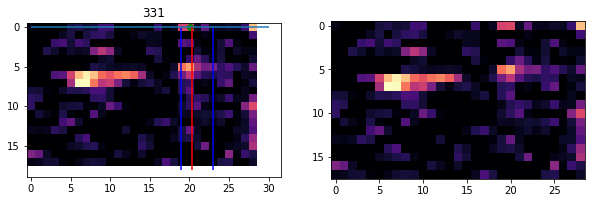

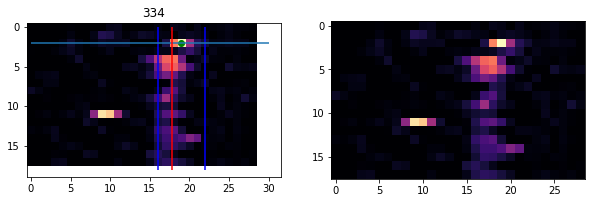

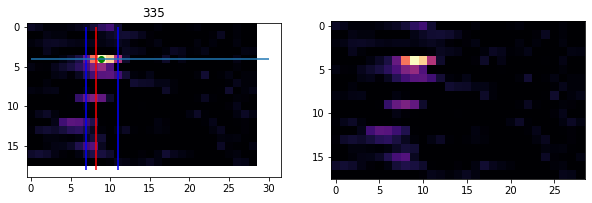

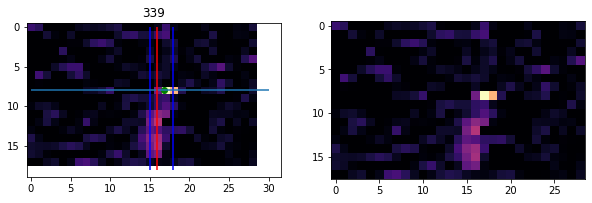

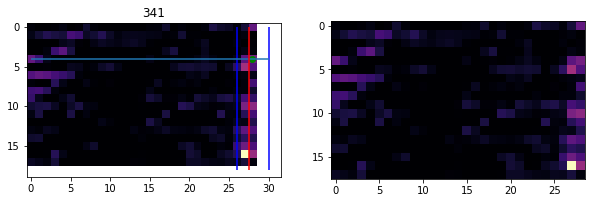

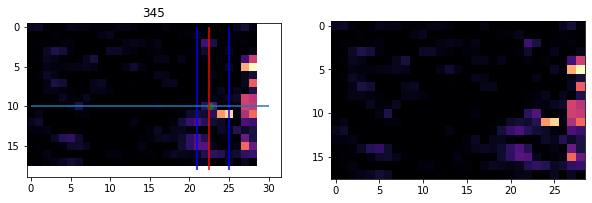

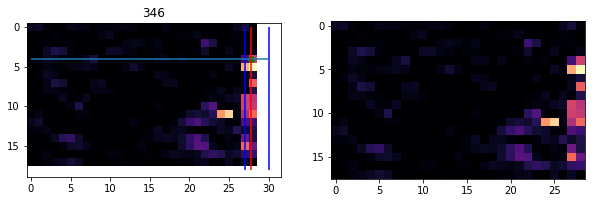

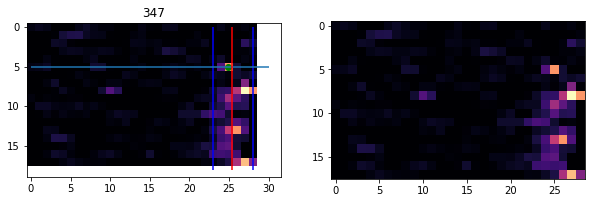

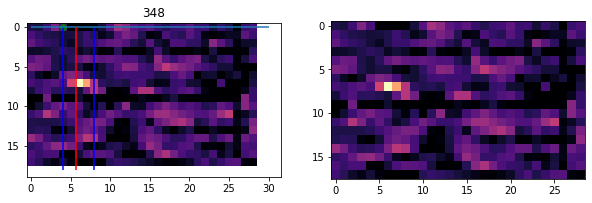

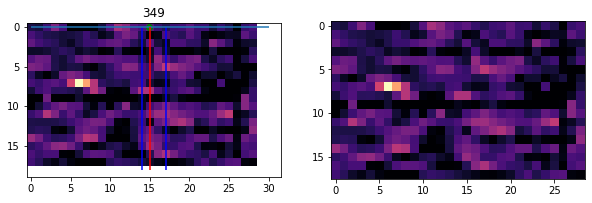

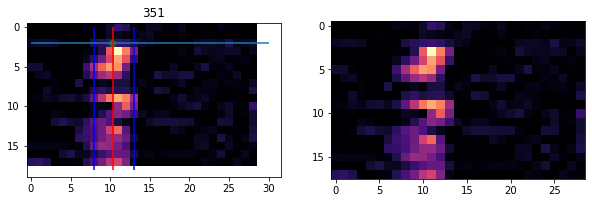

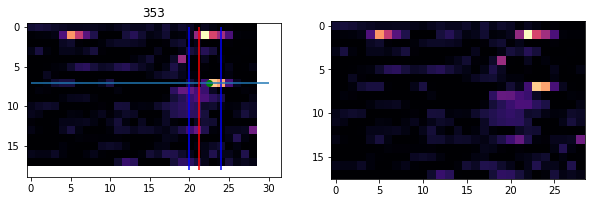

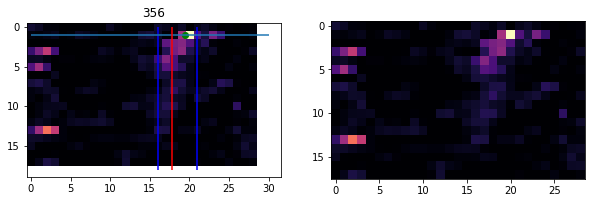

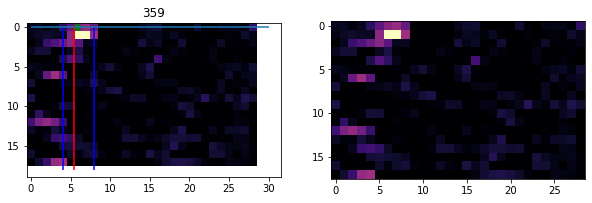

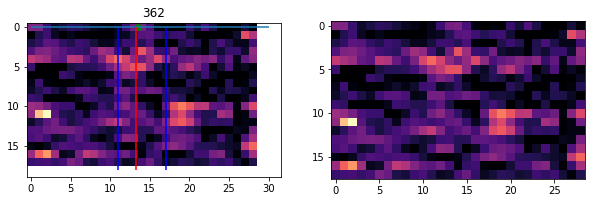

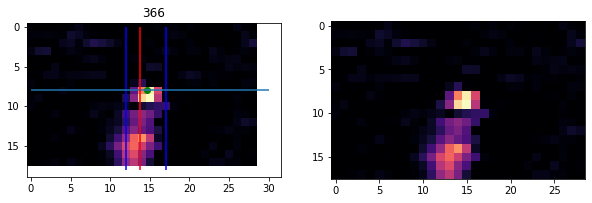

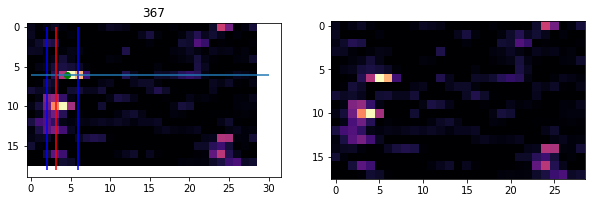

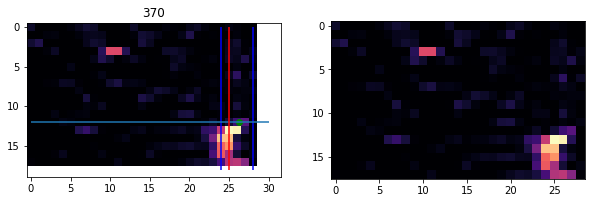

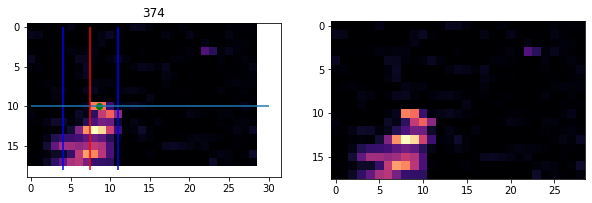

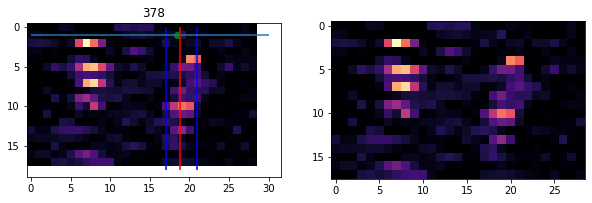

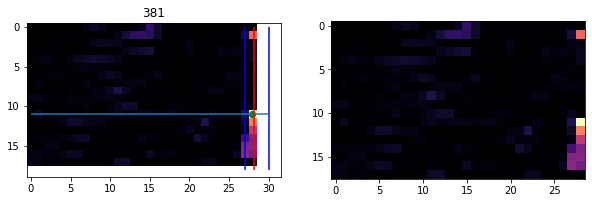

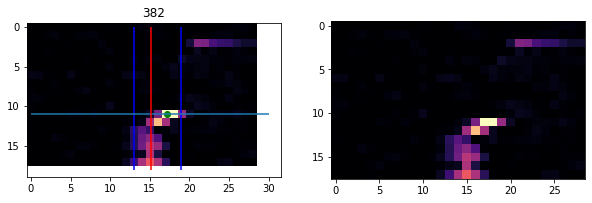

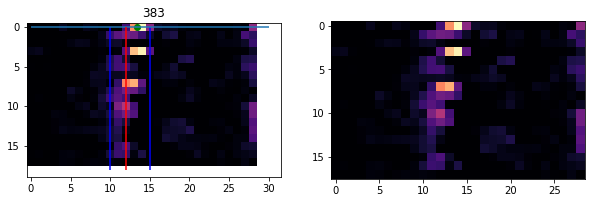

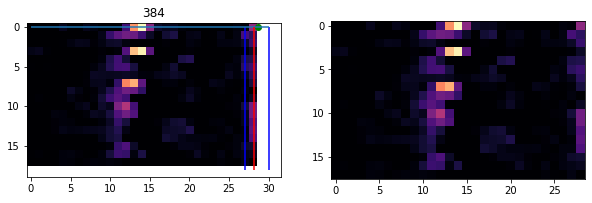

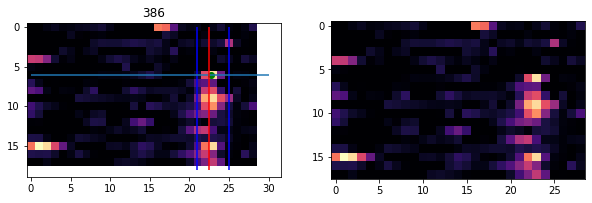

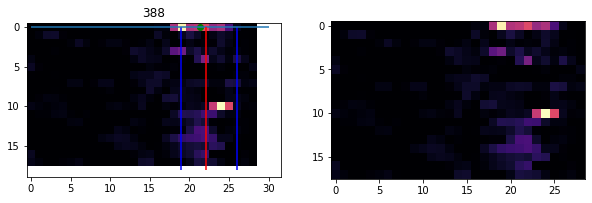

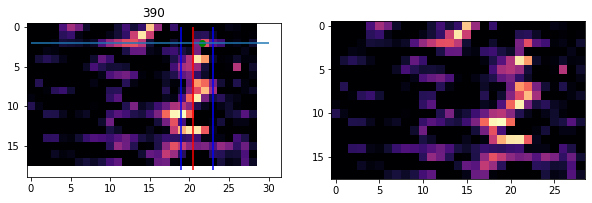

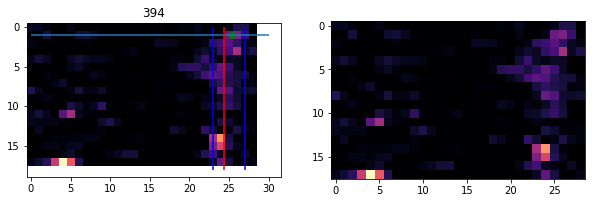

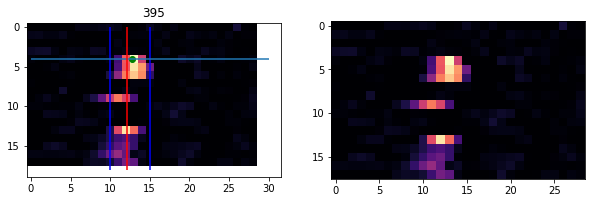

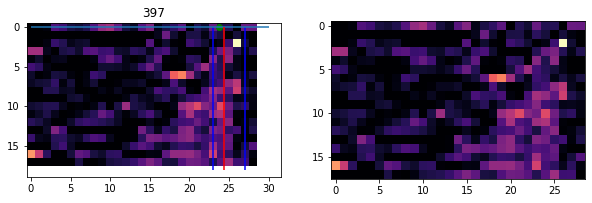

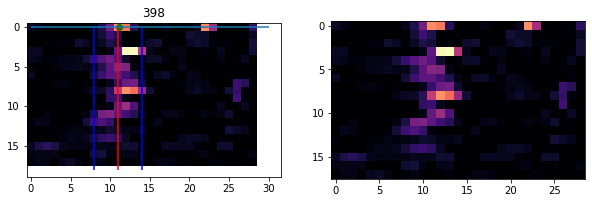

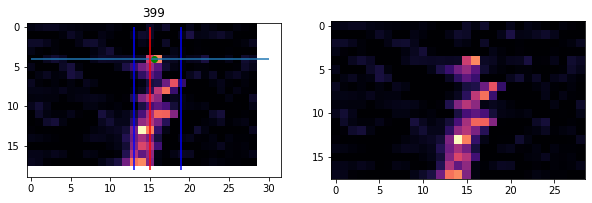

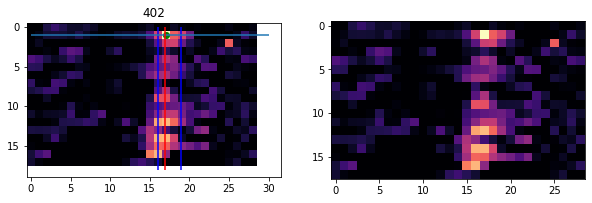

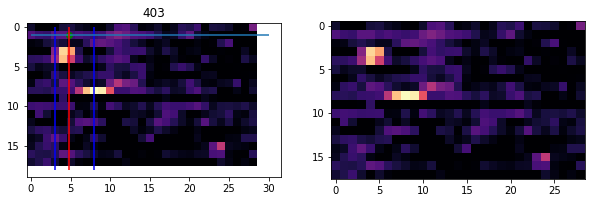

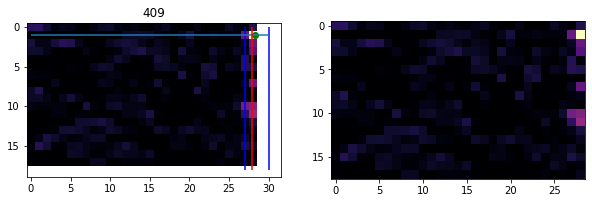

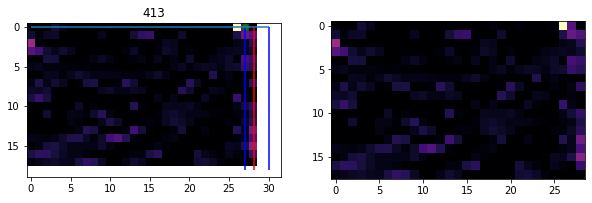

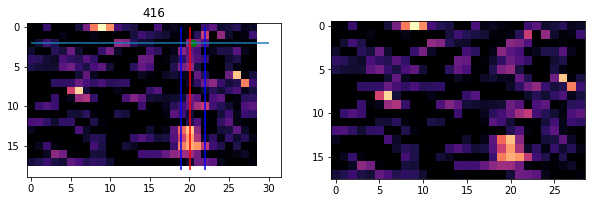

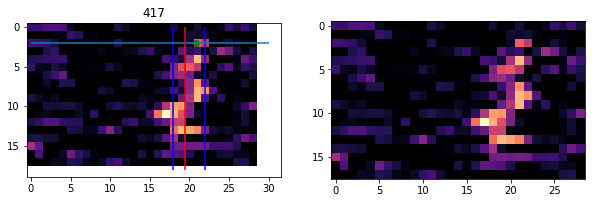

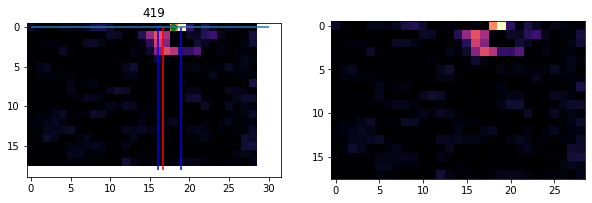

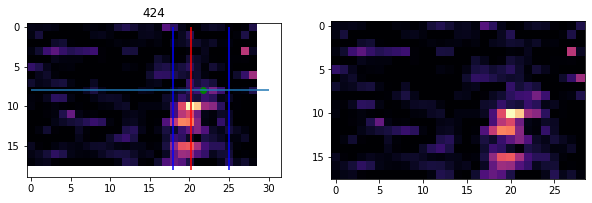

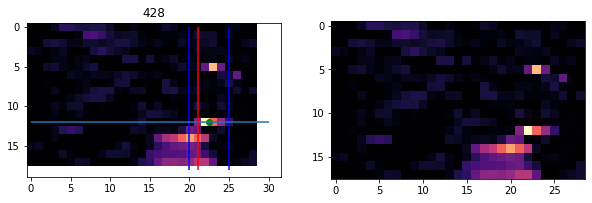

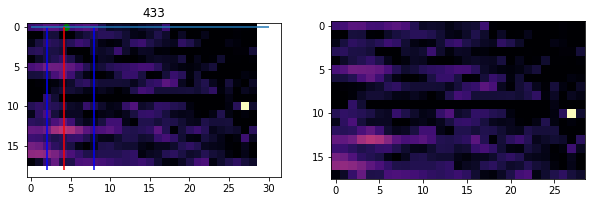

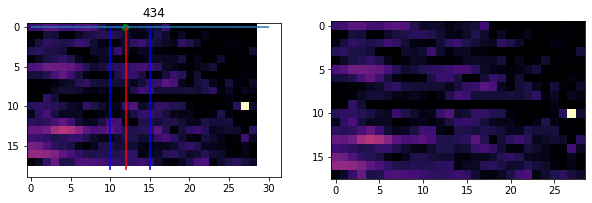

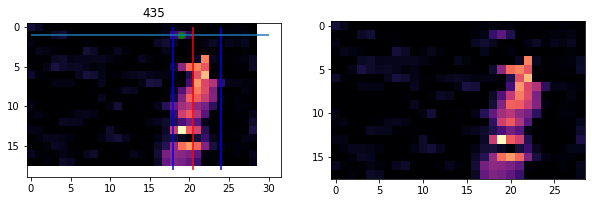

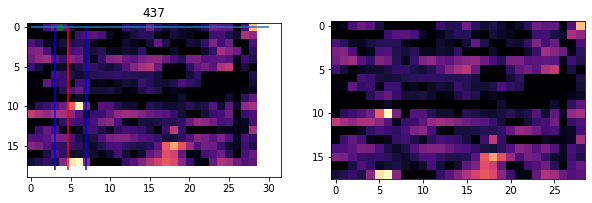

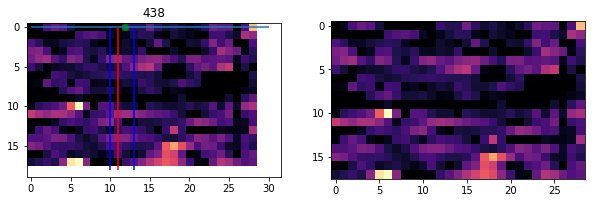

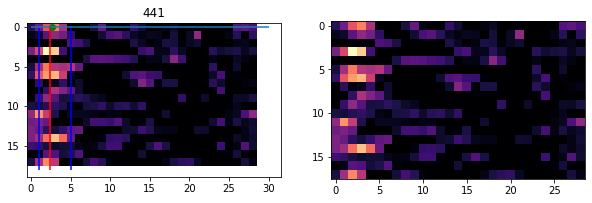

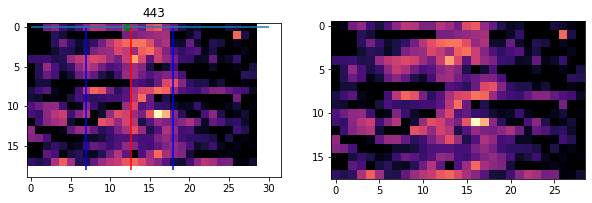

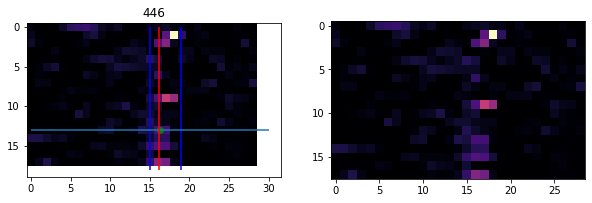

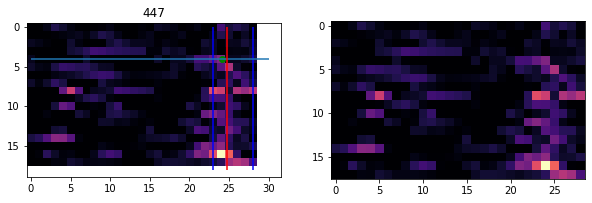

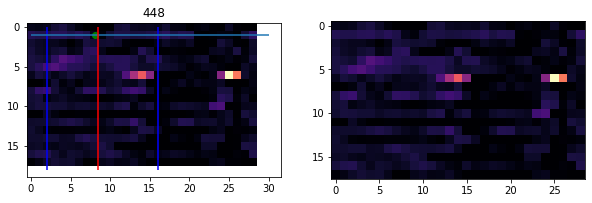

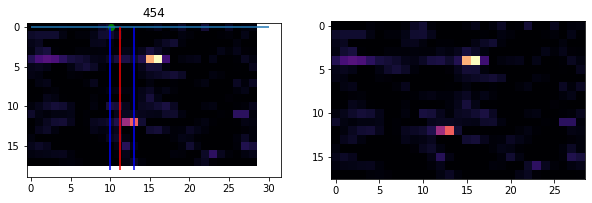

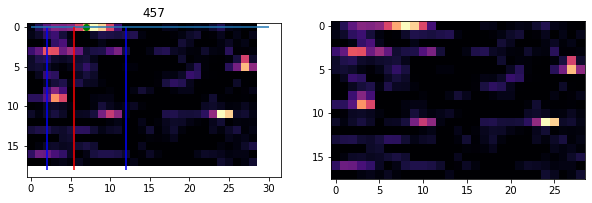

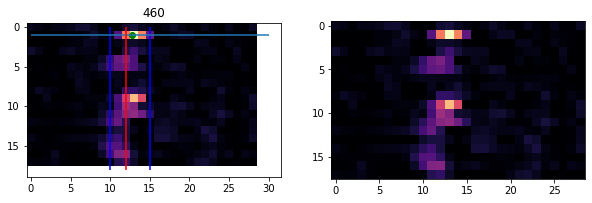

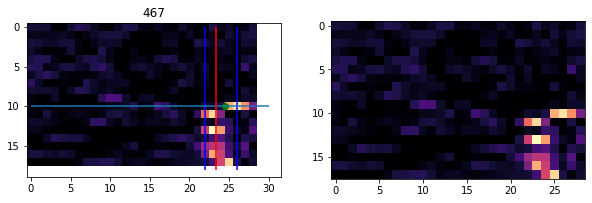

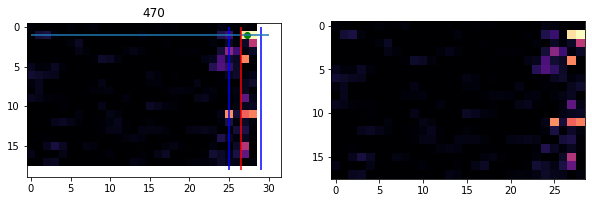

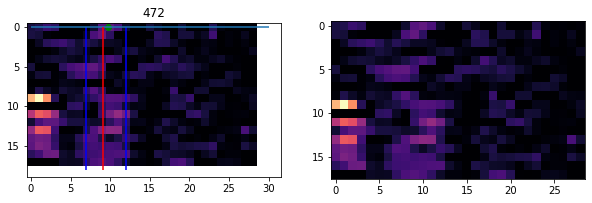

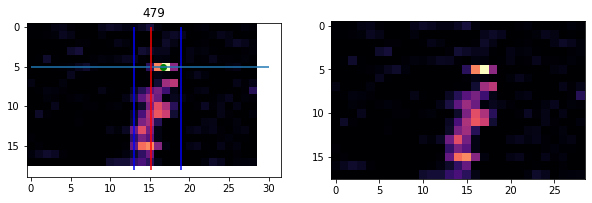

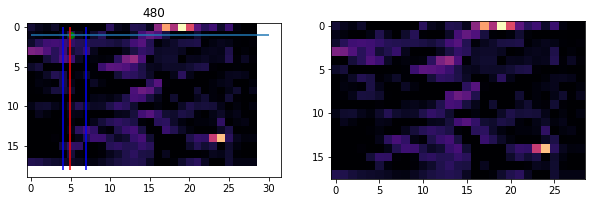

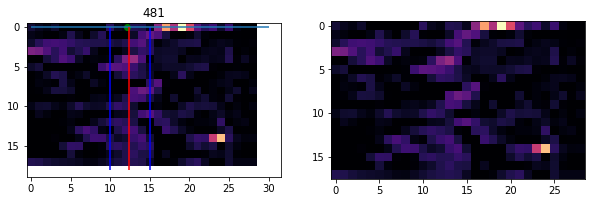

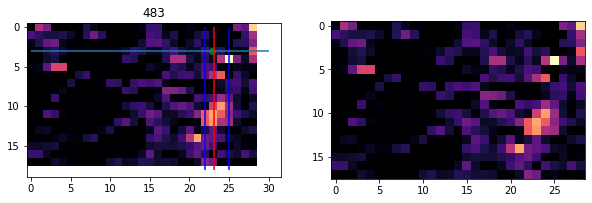

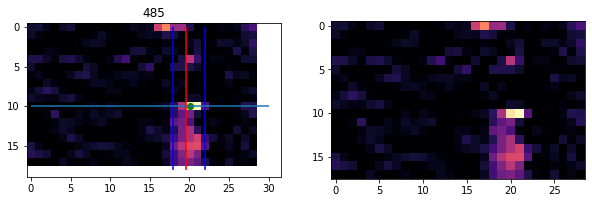

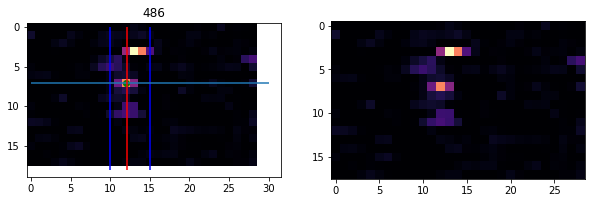

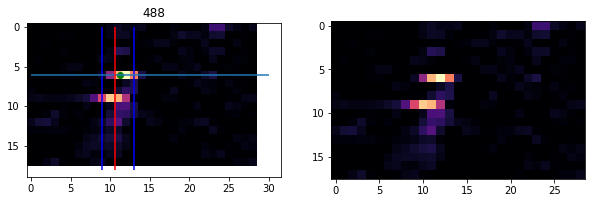

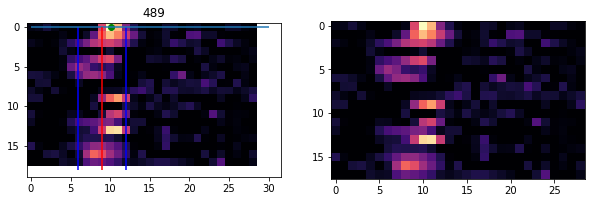

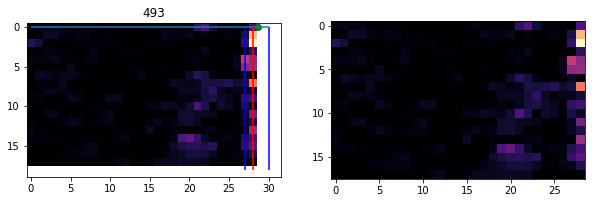

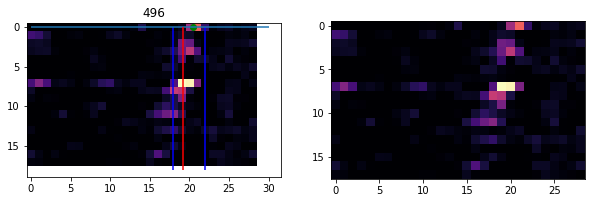

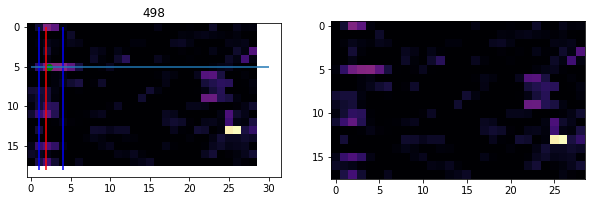

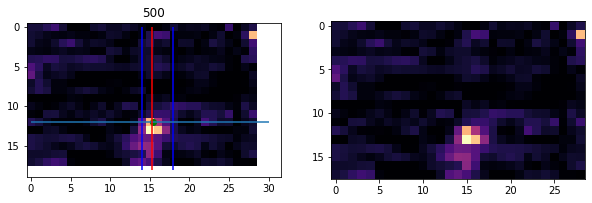

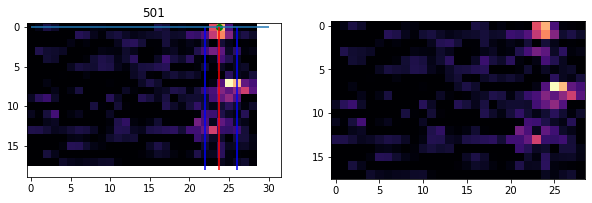

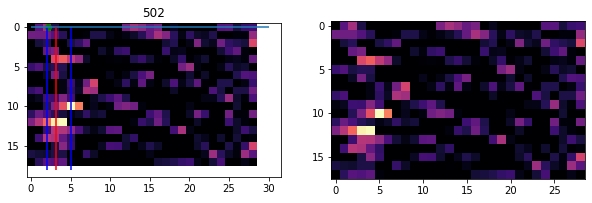

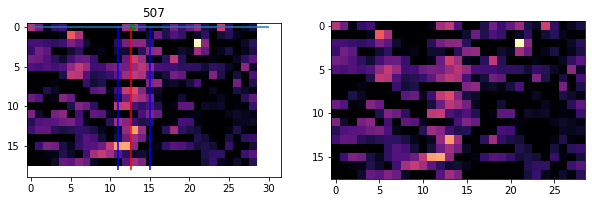

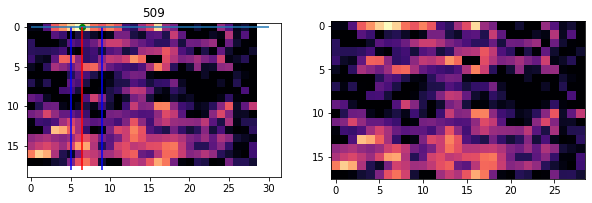

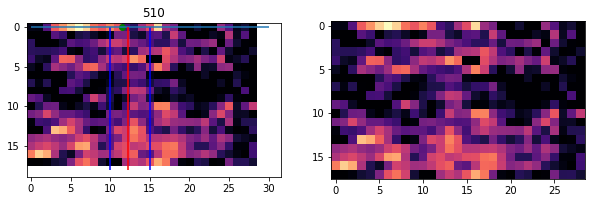

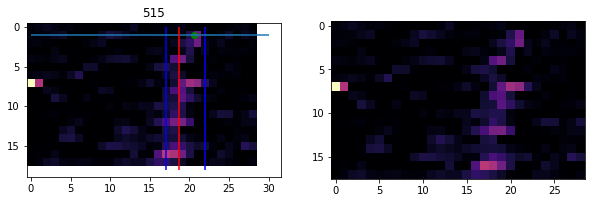

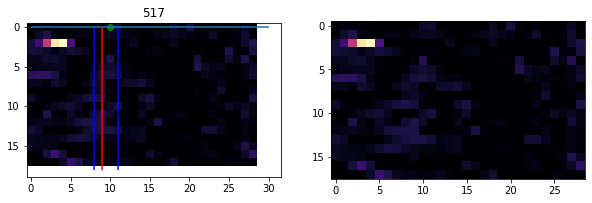

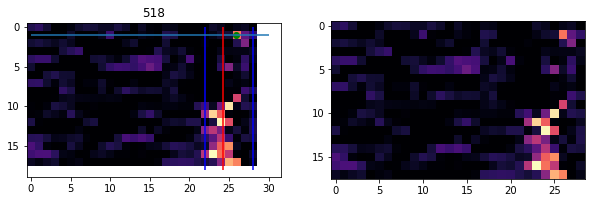

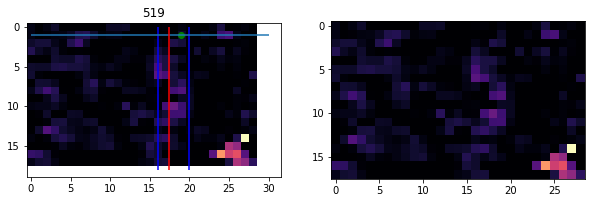

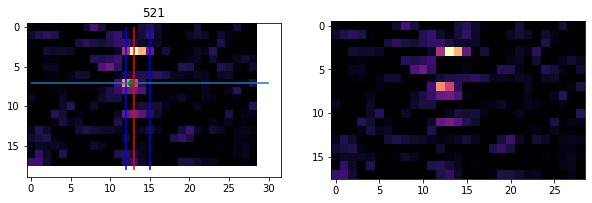

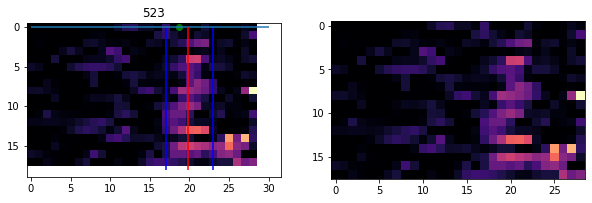

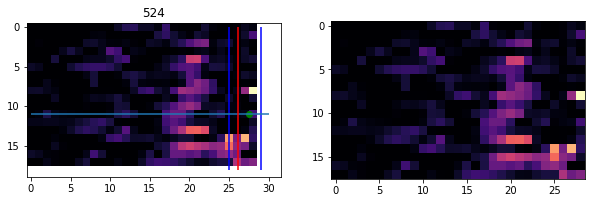

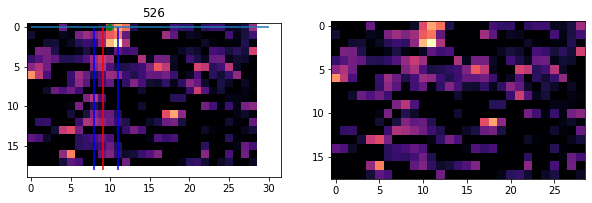

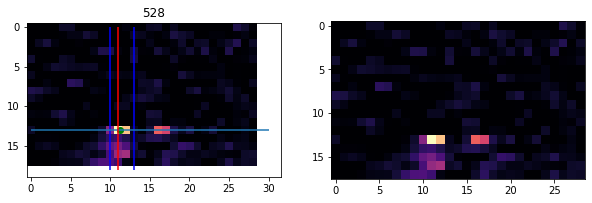

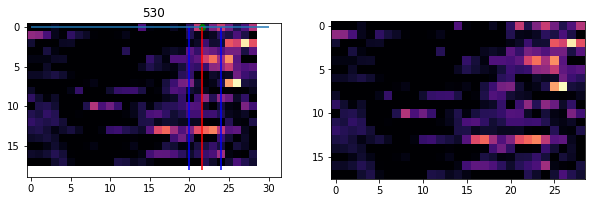

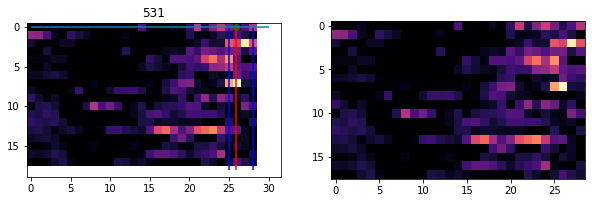

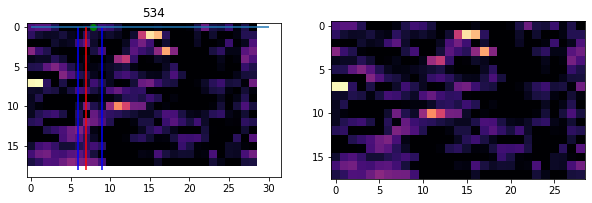

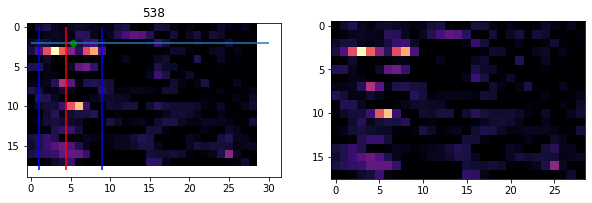

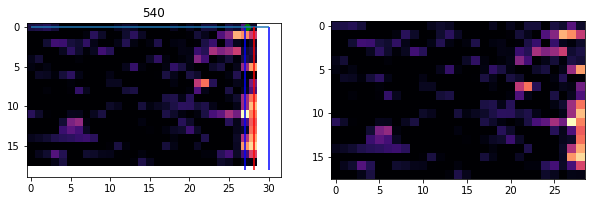

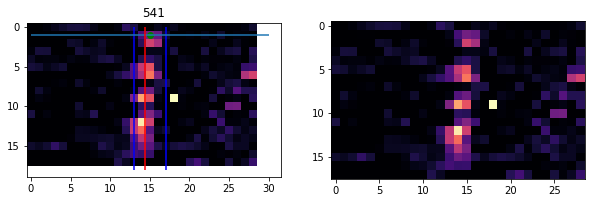

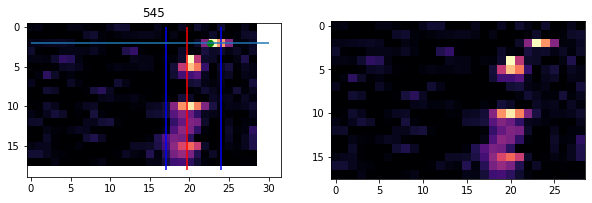

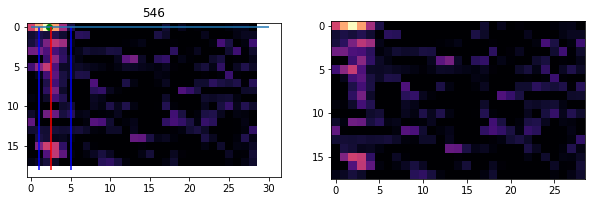

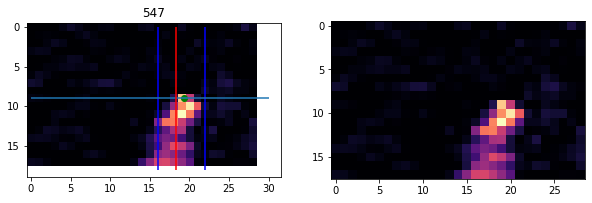

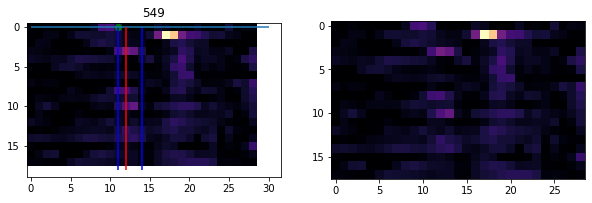

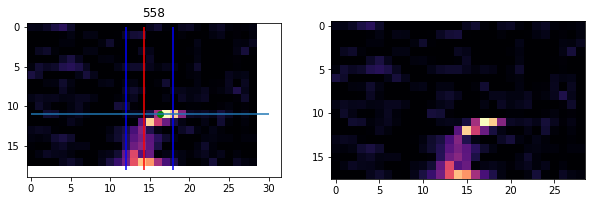

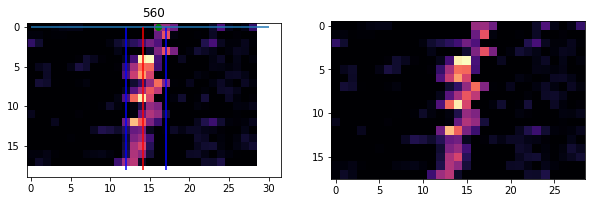

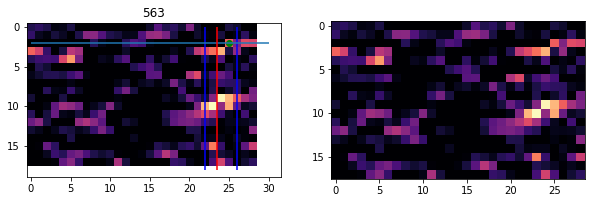

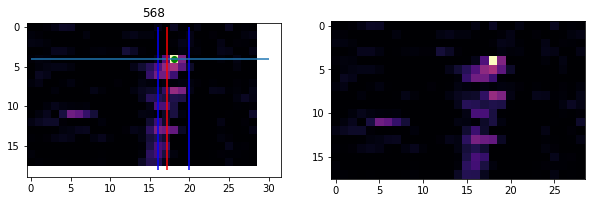

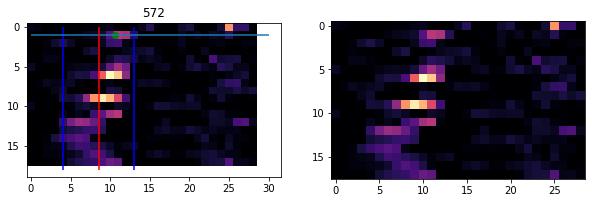

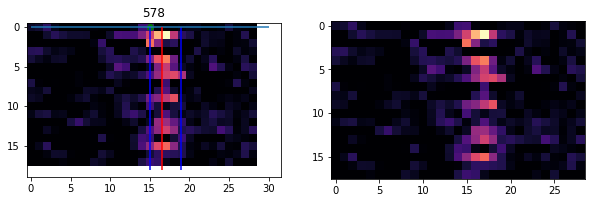

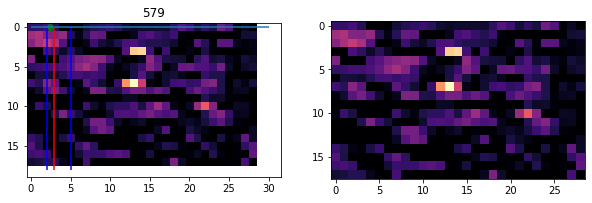

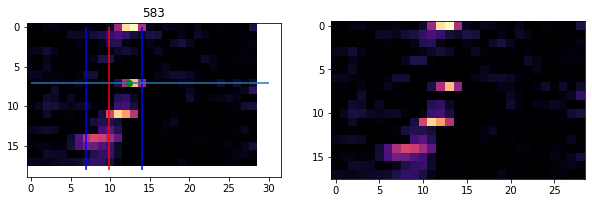

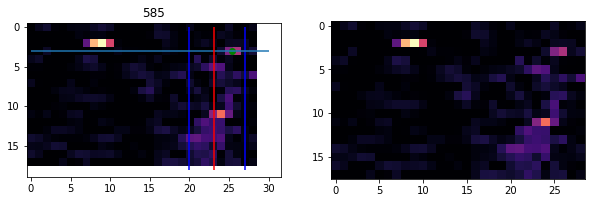

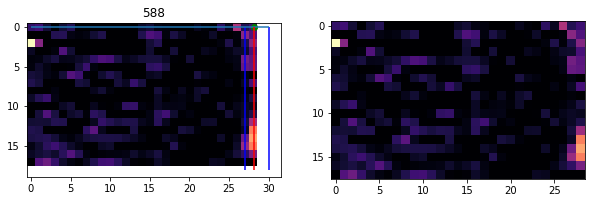

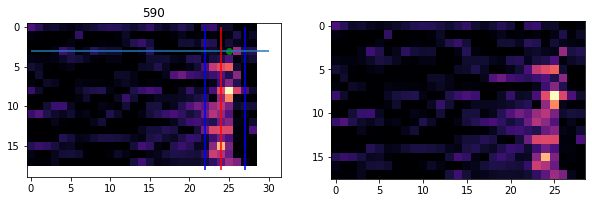

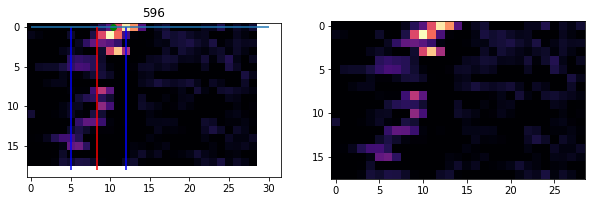

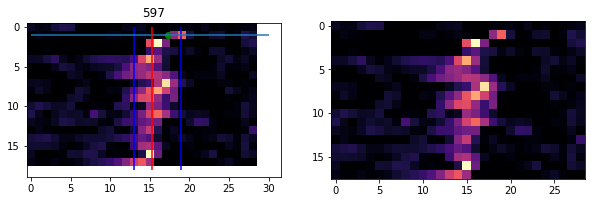

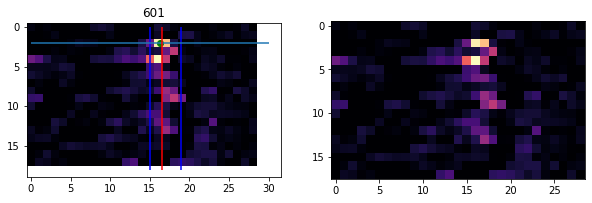

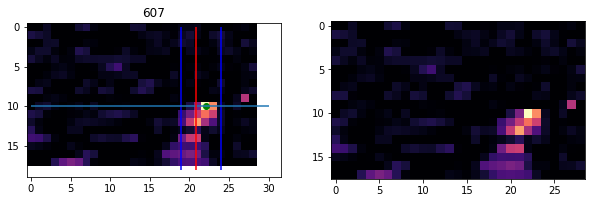

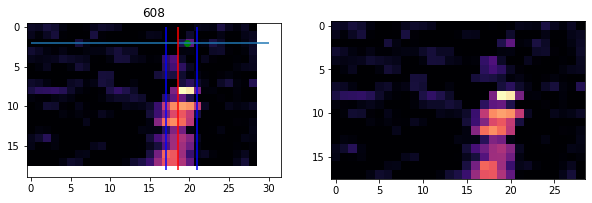

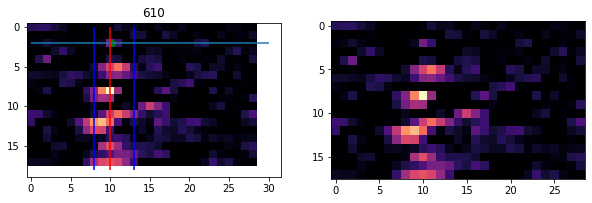

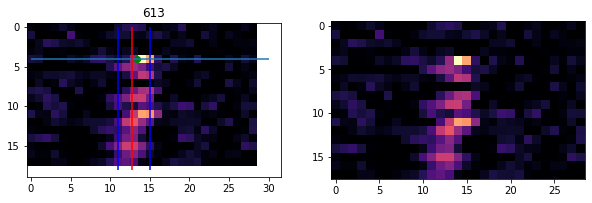

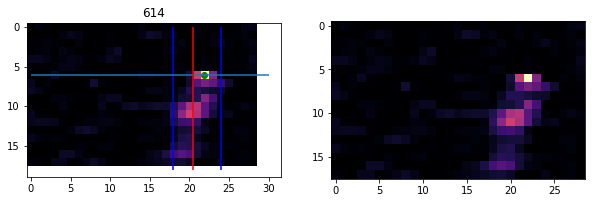

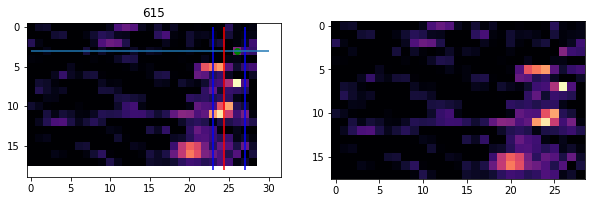

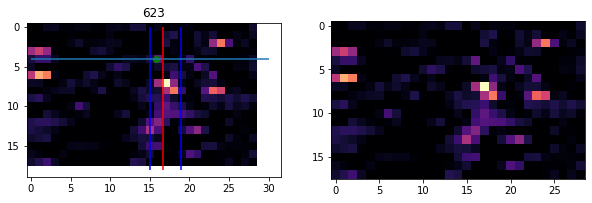

In [44]:
_ = field_shifts(ko_mice[-1], 0, ko_field_mask_res, 'nov', plot=True, act_th=.2, pcnt_th=.2)

In [8]:
ctrl_nov_shifts = {mouse: [field_shifts(mouse, day, ctrl_field_mask_res, 'nov', act_th = .2, pcnt_th = .2) for day in range(6)] for mouse in ctrl_mice}

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


<ipython-input-7-6a8f90bf41bc>:28: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:][:,np.maximum(ledge[field,1],0):redge[field,1]],axis=1)


{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

In [9]:
ko_nov_shifts = {mouse: [field_shifts(mouse, day, ko_field_mask_res, 'nov', act_th = .2, pcnt_th = .2) for day in range(6)] for mouse in ko_mice}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
<ipython-input-7-6a8f90bf41bc>:28: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:][:,np.maximum(ledge[field,1],0):redge[field,1]],axis=1)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

In [10]:
ctrl_fam_shifts = {mouse: [field_shifts(mouse, day, ctrl_field_mask_res, 'fam', act_th = .2, pcnt_th = .2) for day in range(6)] for mouse in ctrl_mice}
ko_fam_shifts = {mouse: [field_shifts(mouse, day, ko_field_mask_res, 'fam', act_th = .2, pcnt_th = .2) for day in range(6)] for mouse in ko_mice}

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


<ipython-input-7-6a8f90bf41bc>:28: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:][:,np.maximum(ledge[field,1],0):redge[field,1]],axis=1)


{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 

In [11]:
df_shifts = pd.DataFrame({'mouse': [],
                          'm': [],
                          'day': [],
                         'dz': [],
                         'ko': [],
                         'nov': [],
                         'nov_x_dz': [],
                         'ko_x_dz': [],
                         'ko_x_nov': [],
                         'ko_x_nov_x_dz':[],
                         'shifts': [],
                         'width': [],
                         'formation_lap': [],
                         'init_speed': [],
                         'init_speed_x_ko': [],
                         'speed': [],
                         'ko_x_speed': [],
                         'field_var': [],
                         'ko_x_speed': [], 
                         'intercept': []})


days_z = sp.stats.zscore(np.arange(6))
for day, dz in enumerate(days_z):
    print('day', day)
    
    for m, mouse in enumerate(ctrl_mice):
        
        for _fn, (shift, width, init_speed, speed, formlap, fvar) in enumerate(zip(ctrl_nov_shifts[mouse][day]['shift'], 
                                                                                   ctrl_nov_shifts[mouse][day]['width'], 
                                                                                   ctrl_nov_shifts[mouse][day]['init_speed'],
                                                                                   ctrl_nov_shifts[mouse][day]['speed'],
                                                                                   ctrl_nov_shifts[mouse][day]['formation_lap'],
                                                                                   ctrl_nov_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m,
                                              'day': day,
                                              'dz': dz,
                                              'ko': 0,
                                              'nov': 1,
                                              'ko_x_dz': 0,
                                              'nov_x_dz': dz,
                                              'ko_x_nov': 0,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': init_speed,
                                              'init_speed_x_ko': 0,
                                              'field_var': fvar,
                                              'speed': speed,
                                              'ko_x_speed': 0,
                                              'intercept': 1}, ignore_index=True)
                
        for _fn, (shift, width, init_speed, speed, formlap, fvar) in enumerate(zip(ctrl_fam_shifts[mouse][day]['shift'], 
                                                                                    ctrl_fam_shifts[mouse][day]['width'], 
                                                                                    ctrl_fam_shifts[mouse][day]['init_speed'],
                                                                                   ctrl_fam_shifts[mouse][day]['speed'],
                                                                                    ctrl_fam_shifts[mouse][day]['formation_lap'],
                                                                                    ctrl_fam_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m,
                                              'day': day,
                                              'dz': dz,
                                              'ko': 0,
                                              'nov': 0,
                                              'ko_x_dz': 0,
                                              'nov_x_dz': 0,
                                              'ko_x_nov': 0,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': init_speed,
                                              'init_speed_x_ko': 0,
                                              'speed': speed,
                                              'field_var': fvar,
                                              'ko_x_speed': 0,
                                              'intercept': 1}, ignore_index=True)

    for m, mouse in enumerate(ko_mice):
        
        for _fn, (shift, width, init_speed, speed, formlap, fvar) in enumerate(zip(ko_nov_shifts[mouse][day]['shift'], 
                                                                                    ko_nov_shifts[mouse][day]['width'], 
                                                                                    ko_nov_shifts[mouse][day]['init_speed'],
                                                                                   ko_nov_shifts[mouse][day]['speed'],
                                                                                    ko_nov_shifts[mouse][day]['formation_lap'],
                                                                                    ko_nov_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m + len(ctrl_mice),
                                              'day': day,
                                              'dz': dz,
                                              'ko': 1,
                                              'nov': 1,
                                              'ko_x_dz': dz,
                                              'nov_x_dz': dz,
                                              'ko_x_nov': 1,
                                              'ko_x_nov_x_dz': 1,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': init_speed,
                                              'init_speed_x_ko': init_speed,
                                              'field_var': fvar,
                                              'speed': speed,
                                              'ko_x_speed': speed,
                                              'intercept': 1}, ignore_index=True)
                
        for _fn, (shift, width, init_speed, speed, formlap, fvar) in enumerate(zip(ko_fam_shifts[mouse][day]['shift'], 
                                                        ko_fam_shifts[mouse][day]['width'], 
                                                        ko_fam_shifts[mouse][day]['init_speed'],
                                                                                   ko_fam_shifts[mouse][day]['speed'],
                                                        ko_fam_shifts[mouse][day]['formation_lap'],
                                                        ko_fam_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m + len(ctrl_mice),
                                              'day': day,
                                              'dz': dz,
                                              'ko': 1,
                                              'nov': 0,
                                              'ko_x_dz': dz,
                                              'nov_x_dz': 0,
                                              'ko_x_nov': 0,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': speed,
                                              'init_speed_x_ko': speed,
                                              'field_var': fvar,
                                              'speed': speed,
                                              'ko_x_speed': speed, 
                                              'intercept': 1}, ignore_index=True)


day 0
day 1
day 2
day 3
day 4
day 5


In [12]:
df_shifts.to_pickle("./df_shifts.pkl")

In [6]:
df_shifts = pd.read_pickle("./df_shifts.pkl")

1.126549466333244 0.259968692111222
1.5814759265364835 0.11384755759298333
1.9301206627061263 0.0536246003279245
1.7189610799923687 0.08568929873513313
0.3926438428731855 0.6945916130599036
2.059791483445037 0.03947104098218515
2.952518245431895 0.003160056322955033
0.19589191197153746 0.8447027013912861
3.447407965811202 0.000568845850640646
-0.13389477837384614 0.8934917814969924
1.3373737841756734 0.18113790582890835
2.028013937930884 0.04259175346035119


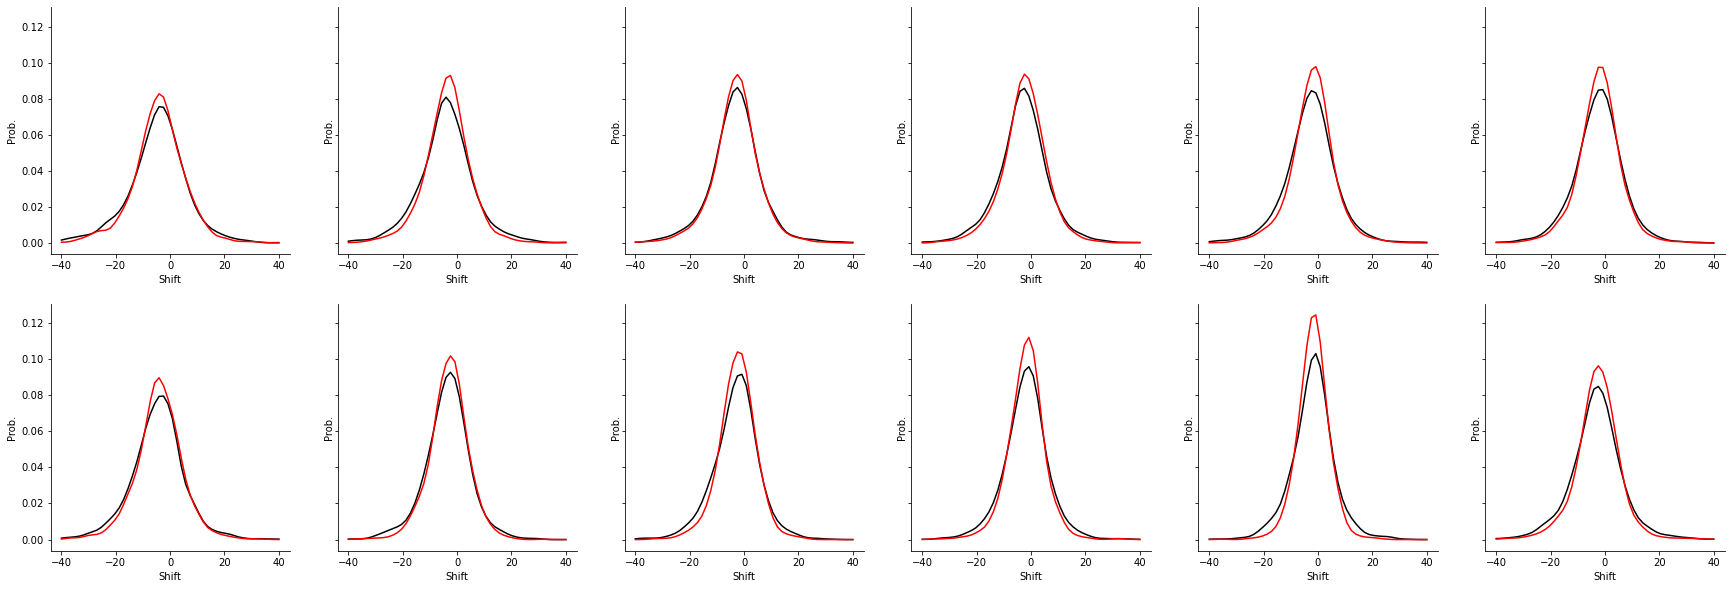

In [7]:
fig, ax = plt.subplots(2,6, figsize= [30,10], sharey=True)

x = np.linspace(-40,40)
for day in range(6):
    mask = (df_shifts['day']==day) & (df_shifts['ko']==0) & (df_shifts['speed']>0.05) & (df_shifts['nov']==0)
    ctrl_shifts = 10*df_shifts['shifts'].loc[mask]._values
    hist = tpu.utilities.gaussian(ctrl_shifts[np.newaxis,:],3, x[:,np.newaxis]).mean(axis=1)
    hist /= hist.sum()
    ax[0,day].plot(x,hist, color='black')
#     ax[0,day].plot(ctrl_shifts.mean()*np.ones([2,]), [0,np.amax(hist)])
    
    mask = (df_shifts['day']==day) & (df_shifts['ko']==1) & (df_shifts['speed']>0.05) & (df_shifts['nov']==0)
    ko_shifts = 10*df_shifts['shifts'].loc[mask]._values
    hist = tpu.utilities.gaussian(ko_shifts[np.newaxis,:],3, x[:,np.newaxis]).mean(axis=1)
    hist /= hist.sum()
    ax[0,day].plot(x,hist, color='red')
#     ax[0,day].plot(ko_shifts.mean()*np.ones([2,]), [0,np.amax(hist)])
    t,p = sp.stats.ttest_ind(ko_shifts,ctrl_shifts)
#     t,p = sp.stats.ttest_1samp(ctrl_shifts, 0) #,ctrl_shifts)
    print(t,p)
    
    mask = (df_shifts['day']==day) & (df_shifts['ko']==0) & (df_shifts['init_speed']>0.02) & (df_shifts['nov']==1)
    ctrl_shifts = 10*df_shifts['shifts'].loc[mask]._values
    hist = tpu.utilities.gaussian(ctrl_shifts[np.newaxis,:],3, x[:,np.newaxis]).mean(axis=1)
    hist /= hist.sum()
    ax[1,day].plot(x,hist, color='black')
#     ax[1,day].plot(ctrl_shifts.mean()*np.ones([2,]), [0,np.amax(hist)])
    
    mask = (df_shifts['day']==day) & (df_shifts['ko']==1) & (df_shifts['init_speed']>0.02) & (df_shifts['nov']==1)
    ko_shifts = 10*df_shifts['shifts'].loc[mask]._values
    hist = tpu.utilities.gaussian(ko_shifts[np.newaxis,:],3, x[:,np.newaxis]).mean(axis=1)
    hist /= hist.sum()
    ax[1,day].plot(x,hist, color='red')
#     ax[1,day].plot(ko_shifts.mean()*np.ones([2,]), [0,np.amax(hist)])
    
    t,p = sp.stats.ttest_ind(ko_shifts,ctrl_shifts)
#     t,p = sp.stats.ttest_1samp(ctrl_shifts, 0) #,ctrl_shifts)
    print(t,p)
    
for row in range(2):
    for col in range(6):
        ax[row,col].set_xlabel('Shift')
        ax[row,col].set_ylabel('Prob.')
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)
    
# fig.savefig(os.path.join(figdir, "com_shift_by_day.pdf"), format = 'pdf')

In [8]:
aov = mixed_anova(data = df_shifts[ (df_shifts['day']<5)], dv = 'shifts', between = 'ko', within= 'day', subject = 'm')
print(aov)

        Source        SS  DF1  DF2        MS          F         p-unc  \
0           ko  0.025956    1   14  0.025956   0.808852  3.836685e-01   
1          day  0.414523    4   56  0.103631  20.930787  1.354031e-10   
2  Interaction  0.002853    4   56  0.000713   0.144059  9.648871e-01   

        np2       eps  
0  0.054619       NaN  
1  0.599207  0.648143  
2  0.010185       NaN  


In [9]:
print(df_shifts[df_shifts['ko']==0].shape)
print(df_shifts[df_shifts['ko']==1].shape)

(48051, 19)
(33923, 19)


In [10]:

df = df_shifts[(df_shifts['speed']>0.01) & (df_shifts['day']<5)]
speed_z = sp.stats.zscore(df['init_speed']._values)
df['init_speed'] = speed_z
df['init_speed_x_ko'] = speed_z*df['ko']._values
speed_z = sp.stats.zscore(df['speed']._values)
df['speed'] = speed_z
df['ko_x_speed'] = speed_z*df['ko']._values
df['shifts'] = sp.stats.zscore(df['shifts']._values)
lmm_res = MixedLM(df['shifts'], df[['ko', 
                                  'dz', 
                                  'nov',
                                  'nov_x_dz', 
                                  'ko_x_dz', 
                                  'ko_x_nov', 
                                  'init_speed',  
                                  'init_speed_x_ko',
                                  'speed',
                                  'ko_x_speed',
                                  'intercept']], 
                                  df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
# print(lmm_resf.pvalues())

<ipython-input-10-ced7e9fbfce5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed'] = speed_z
<ipython-input-10-ced7e9fbfce5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed_x_ko'] = speed_z*df['ko']._values
<ipython-input-10-ced7e9fbfce5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: shifts     
No. Observations:  65767   Method:             REML       
No. Groups:        16      Scale:              0.9813     
Min. group size:   1633    Log-Likelihood:     -92771.9246
Max. group size:   5953    Converged:          Yes        
Mean group size:   4110.4                                 
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
ko               0.009    0.108  0.080 0.936 -0.204  0.221
dz               0.094    0.007 12.837 0.000  0.080  0.108
nov              0.076    0.011  7.016 0.000  0.055  0.097
nov_x_dz         0.025    0.010  2.443 0.015  0.005  0.044
ko_x_dz          0.005    0.010  0.493 0.622 -0.015  0.024
ko_x_nov        -0.020    0.017 -1.204 0.229 -0.053  0.013
init_speed      -0.065    0.007 -8.721 0.000 -0.079 -0.050
init_spe

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [13]:
df = df_shifts[(df_shifts['speed']>0.05) & (df_shifts['day']==0)]
speed_z = sp.stats.zscore(df['init_speed']._values)
df['init_speed'] = speed_z
df['init_speed_x_ko'] = speed_z*df['ko']._values
speed_z = sp.stats.zscore(df['speed']._values)
df['speed'] = speed_z
df['ko_x_speed'] = speed_z*df['ko']._values
df['shifts'] = sp.stats.zscore(df['shifts']._values)
lmm_res = MixedLM(df['shifts'], df[['ko', 
#                                   'dz', 
#                                   'nov',
#                                   'nov_x_dz', 
#                                   'ko_x_dz', 
#                                   'ko_x_nov', 
#                                   'init_speed',  
#                                   'init_speed_x_ko',
                                    'speed',
                                    'ko_x_speed',
                                  'intercept']], 
                                  df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shifts     
No. Observations: 11620   Method:             REML       
No. Groups:       16      Scale:              0.9823     
Min. group size:  264     Log-Likelihood:     -16413.5056
Max. group size:  1145    Converged:          Yes        
Mean group size:  726.2                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko             -0.012    0.070 -0.177 0.859 -0.149  0.124
speed          -0.041    0.014 -2.940 0.003 -0.068 -0.014
ko_x_speed     -0.018    0.025 -0.693 0.488 -0.068  0.032
intercept       0.021    0.046  0.453 0.650 -0.069  0.110
Group Var       0.017    0.007                           



<ipython-input-13-b90cf43b57b0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed'] = speed_z
<ipython-input-13-b90cf43b57b0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed_x_ko'] = speed_z*df['ko']._values
<ipython-input-13-b90cf43b57b0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

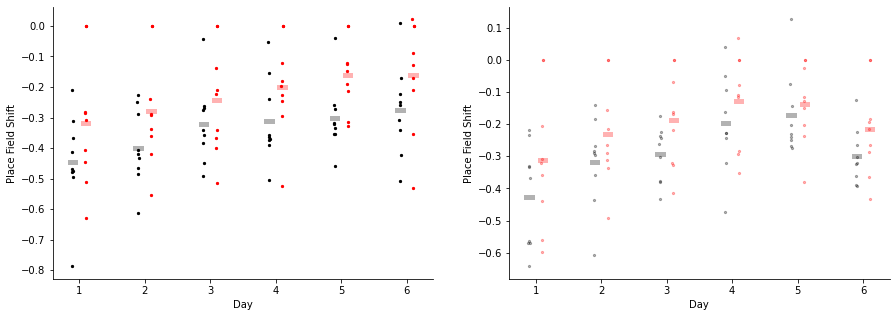

In [22]:
fig, ax = plt.subplots(1,2, figsize = [15,5], sharey=False)

plot_arr = np.zeros([2, 2, 9, 6 ])
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0) & (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]._values.ravel()
        plot_arr[0,0,m,day]=np.nanmean(shifts)
        

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[1,0,m,day]=np.nanmean(shifts)
#         ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(shifts)
#         ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[1,1,m,day]=np.nanmean(shifts)
#         ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)


    
for day in range(6):
    
    
    ax[0].scatter(5*day - .5 + np.linspace(-0.05,.05, num = plot_arr.shape[2]), plot_arr[0,0,:,day], color = 'black', s = 5 )
    ax[0].plot(5*day -.5 + np.array([-.2,.2]), np.nanmean(plot_arr[0,0,:,day])*np.ones([2,]), color = 'black', linewidth=5, alpha = .3)
#     ax.bar([day-.275], [np.nanmean(plot_arr[0,0,:,day])],yerr = [sp.stats.sem(plot_arr[0,0,:,day], nan_policy='omit')],width = .15, edgecolor='black', fill=False)
    
    ax[1].scatter(5*day -.5 + np.linspace(-0.05,.05, num = plot_arr.shape[2]), plot_arr[0,1,:,day], color = 'black', s = 5 , alpha = .3)
    ax[1].plot(5*day -.5 + np.array([-.2,.2]), np.nanmean(plot_arr[0,1,:,day])*np.ones([2,]), color = 'black', linewidth=5, alpha = .3)
#     ax.bar([day-.075], [np.nanmean(plot_arr[0,0,:,day])],yerr = [sp.stats.sem(plot_arr[0,1,:,day], nan_policy='omit')],width = .15, edgecolor='black',alpha = .3, fill=False)
    
    ax[0].scatter(5*day + .5 + np.linspace(-0.05,.05, num = plot_arr.shape[2]), plot_arr[1,0,:,day], color = 'red', s = 5 )
    ax[0].plot(5*day +.5 + np.array([-.2,.2]), np.nanmean(plot_arr[1,0,:,day])*np.ones([2,]), color = 'red', linewidth=5, alpha = .3)
#     ax.bar([day+.125], [np.nanmean(plot_arr[1,0,:,day])],yerr = [sp.stats.sem(plot_arr[1,0,:,day], nan_policy='omit')],width = .15, edgecolor='red',alpha = 1, fill=False)
    
    
    ax[1].scatter(5*day +.5 + np.linspace(-0.05,.05, num = plot_arr.shape[2]), plot_arr[1,1,:,day], color = 'red', s = 5 , alpha = .3)
    ax[1].plot(5*day +.5 + np.array([-.2,.2]), np.nanmean(plot_arr[1,1,:,day])*np.ones([2,]), color = 'red', linewidth=5, alpha = .3)
#     ax.bar([day+.325], [np.nanmean(plot_arr[1,1,:,day])],yerr = [sp.stats.sem(plot_arr[1,1,:,day], nan_policy='omit')],width = .15, edgecolor='red',alpha = .3, fill=False)
    
    
# ax.set_xticks(10*np.arange(6)+2)
# ax.set_xticklabels(np.arange(6))
for a in range(2):
    ax[a].set_xlabel('Day')
    ax[a].set_ylabel('Place Field Shift')
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xticks(np.arange(0,26,5))
    ax[a].set_xticklabels(np.arange(1,7))
fig.savefig(os.path.join(figdir, "field_shift_summary.pdf"))

In [26]:
df_aov = pd.DataFrame({'mouse':[] ,
                      'day': [],
                      'novel': [],
                      'ko': [],
                      'shift': [],})
for day in range(6):
    for m in range(len(ctrl_mice)):
        
        df_aov = df_aov.append({'mouse': m,
                        'day': day,
                        'novel': 0,
                        'ko': 0,
                        'shift': plot_arr[0,0,m,day]}, ignore_index=True)
        
        df_aov = df_aov.append({'mouse': m,
                        'day': day,
                        'novel': 1,
                        'ko': 0,
                        'shift': plot_arr[0,1,m,day]}, ignore_index=True)
        
    for m in range(len(ko_mice)):
        
        df_aov = df_aov.append({'mouse': m+len(ctrl_mice),
                        'day': day,
                        'novel': 0,
                        'ko': 1,
                        'shift': plot_arr[1,0,m,day]}, ignore_index=True)
        
        df_aov = df_aov.append({'mouse': m+len(ctrl_mice),
                        'day': day,
                        'novel': 1,
                        'ko': 1,
                        'shift': plot_arr[1,1,m,day]}, ignore_index=True)

In [27]:
aov = mixed_anova(data = df_aov[ (df_aov['novel']==1) & (df_aov['day']<5)], dv = 'shift', between = 'ko', within= 'day', subject = 'mouse')
print(aov)

        Source        SS  DF1  DF2        MS          F         p-unc  \
0           ko  0.012586    1   14  0.012586   0.293112  5.967440e-01   
1          day  0.620878    4   56  0.155219  13.999325  5.591581e-08   
2  Interaction  0.006397    4   56  0.001599   0.144246  9.648049e-01   

        np2       eps  
0  0.020507       NaN  
1  0.499988  0.785329  
2  0.010198       NaN  


In [28]:
for day in range(6):
    print("day %d" % day)
    print("fam")
    t,p = sp.stats.ttest_ind(plot_arr[0,0,:,day],plot_arr[1,0,:,day], nan_policy = 'omit')
    print("ko v control",t,p)
    t,p = sp.stats.ttest_1samp(plot_arr[0,0,:,day],0)
    print("control", t,p)
    t,p = sp.stats.ttest_1samp(plot_arr[1,0,:,day],0)
    print("ko", t,p)

day 0
fam
ko v control -1.4316991005995856 0.1714747705920229
control -8.391035127530115 3.0923324960160684e-05
ko -4.483930327262737 0.0020451198467408924
day 1
fam
ko v control -1.6574697347410676 0.11689881644479891
control -9.62509884656355 1.1282104351528256e-05
ko -4.579740277696372 0.001802622432988418
day 2
fam
ko v control -1.0304065145523635 0.31814470798280176
control -7.318648606939045 8.239016941953873e-05
ko -4.1026119964123735 0.003425383668990926
day 3
fam
ko v control -1.6078813313128935 0.12741275857344264
control -6.77102368669791 0.0001419635597747756
ko -3.7375074486991977 0.005725778946450779
day 4
fam
ko v control -2.601265087523031 0.019291172279822775
control -7.983051038163001 4.433990955317084e-05
ko -4.0897964271762834 0.0034865742589437797
day 5
fam
ko v control -1.4255226443300237 0.17322348120651304
control -5.510206451975685 0.0005668820249592151
ko -2.652911891704115 0.029123933775309675


In [29]:
for day in range(6):
    print("day %d" % day)
    print("nov")
    t,p = sp.stats.ttest_ind(plot_arr[0,1,:,day],plot_arr[1,1,:,day], nan_policy = 'omit')
    print("ko v control",t,p)
    t,p = sp.stats.ttest_1samp(plot_arr[0,1,:,day],0)
    print("control", t,p)
    t,p = sp.stats.ttest_1samp(plot_arr[1,1,:,day],0)
    print("ko", t,p)

day 0
nov
ko v control -1.288155033063003 0.2160102308620404
control -7.907859061629537 4.746130126055627e-05
ko -4.342418147508976 0.002470336303592728
day 1
nov
ko v control -1.2572831663515514 0.22669444485008983
control -6.905422273315587 0.0001238492456132676
ko -4.314926795911847 0.0025635539885536323
day 2
nov
ko v control -1.850084585056195 0.08285729054785168
control -10.146693706245216 7.61290660582666e-06
ko -3.791800082373487 0.005298212999701085
day 3
nov
ko v control -0.9326484047231882 0.3648629034194666
control -3.8527305765252255 0.004858693268305495
ko -2.6200046977636844 0.03065024381045649
day 4
nov
ko v control -0.5857840861092284 0.5661925999866124
control -4.015166601174869 0.0038671086832916053
ko -3.3198739252645355 0.010542053628242601
day 5
nov
ko v control -1.4844814021544832 0.15711483374443247
control -10.469774934329378 6.01895964703873e-06
ko -4.419552180163414 0.0022278228904365188


In [26]:
df = df_shifts[(df_shifts['speed']>0.05) & (df_shifts['day']<5)]
speed_z = sp.stats.zscore(df['init_speed']._values)
df['init_speed'] = speed_z
df['init_speed_x_ko'] = speed_z*df['ko']._values
speed_z = sp.stats.zscore(df['speed']._values)
df['speed'] = speed_z
df['ko_x_speed'] = speed_z*df['ko']._values
df['field_var'] = sp.stats.zscore(df['field_var']._values)
lmm_res = MixedLM(df['field_var'], df[['ko', 'dz', 'nov','nov_x_dz', 'ko_x_dz', 'ko_x_nov',  'intercept']], 
                  df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

<ipython-input-26-79ba61c8110d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed'] = speed_z
<ipython-input-26-79ba61c8110d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed_x_ko'] = speed_z*df['ko']._values
<ipython-input-26-79ba61c8110d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: field_var  
No. Observations: 65593   Method:             REML       
No. Groups:       16      Scale:              0.7407     
Min. group size:  1625    Log-Likelihood:     -83291.2845
Max. group size:  5953    Converged:          Yes        
Mean group size:  4099.6                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko            -0.039    0.113  -0.348 0.728 -0.261  0.183
dz            -0.097    0.006 -15.353 0.000 -0.109 -0.084
nov            0.928    0.009  99.387 0.000  0.910  0.946
nov_x_dz      -0.118    0.009 -13.498 0.000 -0.135 -0.101
ko_x_dz        0.065    0.009   7.556 0.000  0.048  0.081
ko_x_nov       0.032    0.014   2.201 0.028  0.003  0.060
intercept     -0.331    0.075  -4.419 0.000 -0.478 -0.184
Group Var      0.050    

In [27]:
aov = mixed_anova(data = df[df['nov'] == 0], dv = 'field_var', between = 'ko', within= 'day', subject = 'm')
print(aov)

        Source        SS  DF1  DF2        MS         F     p-unc  p-GG-corr  \
0           ko  0.286325    1   12  0.286325  1.579655  0.232724        NaN   
1          day  1.408304    4   48  0.352076  2.712528  0.040761   0.078228   
2  Interaction  0.464175    4   48  0.116044  0.894046  0.474854        NaN   

        np2       eps sphericity   W-spher   p-spher  
0  0.116325       NaN        NaN       NaN       NaN  
1  0.184369  0.542166      False  0.104915  0.002486  
2  0.069338       NaN        NaN       NaN       NaN  


<ipython-input-28-7c75dc924111>:9: RuntimeWarning: Mean of empty slice
  plot_arr[0,0,m,day]=np.nanmean(shifts)
<ipython-input-28-7c75dc924111>:10: RuntimeWarning: Mean of empty slice
  ax.scatter(10*day+.1*m, np.nanmean(shifts), color='black', s=20)
<ipython-input-28-7c75dc924111>:17: RuntimeWarning: Mean of empty slice
  plot_arr[1,0,m,day]=np.nanmean(shifts)
<ipython-input-28-7c75dc924111>:18: RuntimeWarning: Mean of empty slice
  ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)


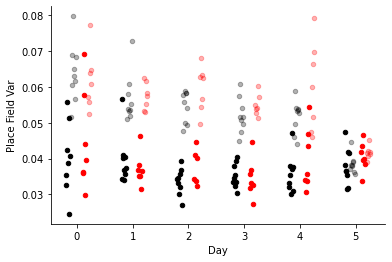

In [28]:
fig, ax = plt.subplots()

plot_arr = np.zeros([2, 2, 9, 6 ])
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[0,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[1,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[1,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)
        

ax.set_xticks(10*np.arange(6)+2)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')
ax.set_ylabel('Place Field Var')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# fig.savefig(os.path.join(figdir, "field_var_summary.pdf"))

In [30]:
df = df_shifts[(df_shifts['speed']>0.01) & (df_shifts['day']<5)]
speed_z = sp.stats.zscore(df['init_speed']._values)
df['init_speed'] = speed_z
df['init_speed_x_ko'] = speed_z*df['ko']._values
speed_z = sp.stats.zscore(df['speed']._values)
df['speed'] = speed_z
df['ko_x_speed'] = speed_z*df['ko']._values
df['shifts'] = sp.stats.zscore(df['shifts']._values)

lmm_res = MixedLM(df['width'], df[['ko', 
                                 'dz', 
                                 'nov',
                                 'nov_x_dz', 
                                 'ko_x_dz', 
                                 'ko_x_nov', 
                                 'init_speed',  
                                 'init_speed_x_ko', 
                                 'speed', 
                                 'ko_x_speed',
                                 'intercept']], 
                  df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

<ipython-input-30-66aa9be0e033>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed'] = speed_z
<ipython-input-30-66aa9be0e033>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed_x_ko'] = speed_z*df['ko']._values
<ipython-input-30-66aa9be0e033>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: width       
No. Observations:  65767   Method:             REML        
No. Groups:        16      Scale:              6.7574      
Min. group size:   1633    Log-Likelihood:     -156210.4981
Max. group size:   5953    Converged:          Yes         
Mean group size:   4110.4                                  
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
ko              -0.079    0.284  -0.277 0.782 -0.636  0.479
dz              -0.062    0.019  -3.254 0.001 -0.100 -0.025
nov             -0.414    0.028 -14.609 0.000 -0.470 -0.359
nov_x_dz         0.073    0.026   2.739 0.006  0.021  0.124
ko_x_dz         -0.021    0.026  -0.825 0.409 -0.072  0.029
ko_x_nov        -0.054    0.044  -1.230 0.219 -0.141  0.032
init_speed      -0.053    0.019  -2.744 0.006 -0.09

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<ipython-input-30-062e55a22f42>:9: RuntimeWarning: Mean of empty slice
  plot_arr[0,0,m,day]=np.nanmean(shifts)
<ipython-input-30-062e55a22f42>:10: RuntimeWarning: Mean of empty slice
  ax.scatter(10*day+.1*m, np.nanmean(shifts), color='black', s=20)
<ipython-input-30-062e55a22f42>:17: RuntimeWarning: Mean of empty slice
  plot_arr[1,0,m,day]=np.nanmean(shifts)
<ipython-input-30-062e55a22f42>:18: RuntimeWarning: Mean of empty slice
  ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)


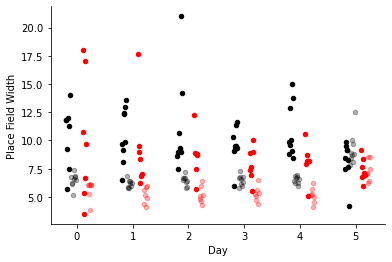

In [30]:
fig, ax = plt.subplots()

plot_arr = np.zeros([2, 2, 9, 6 ])
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[0,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[1,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[1,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)
        

ax.set_xticks(10*np.arange(6)+2)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')
ax.set_ylabel('Place Field Width')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# fig.savefig(os.path.join(figdir, "field_width_summary.pdf"))

In [45]:
t,p = sp.stats.ttest_ind(plot_arr[0,0,:,0],plot_arr[1,0,:,0])
print(t,p)

2.2204814538609745 0.041175546614633574


-0.04010072183026374 0.9680138786790258
10.333411481109225 6.93779089612521e-25
-0.9656481995413998 0.33424550670058917
4.1872407760684265 2.8504774447022604e-05
-6.8364540832498815 8.70064056967552e-12
-10.487288197646649 1.4359400456666603e-25


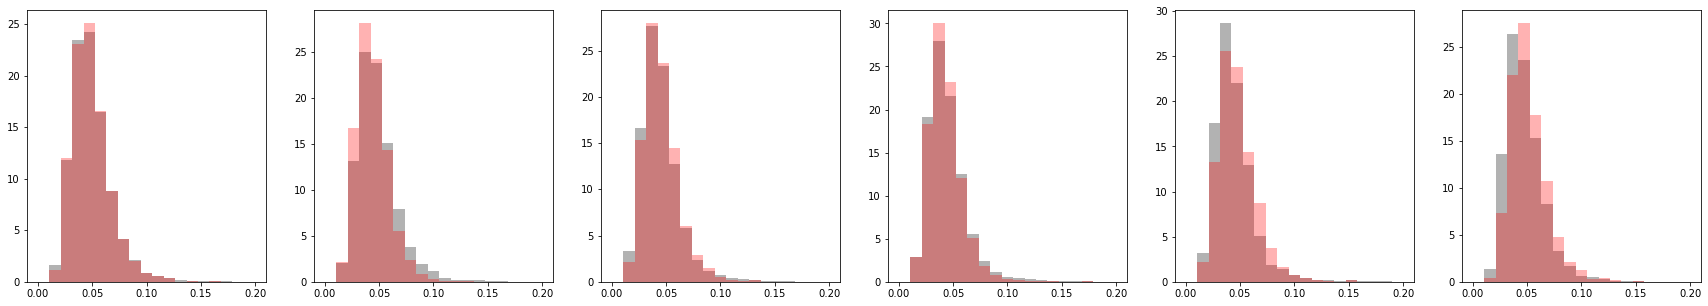

In [41]:
fig,ax = plt.subplots(1,6, figsize = [30,5])

bins = np.linspace(0,.2, num=20)
for day in range(6):
    ax[day].hist(df_shifts['field_var'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                 bins = bins, color = 'black', alpha = .3, density=True)
    ax[day].hist(df_shifts['field_var'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                 bins = bins, color = 'red', alpha = .3, density=True)
    t,p = sp.stats.ttest_ind(df_shifts['field_var'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                             df_shifts['field_var'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day) & (df_shifts['nov']==0)])
    print(t,p)

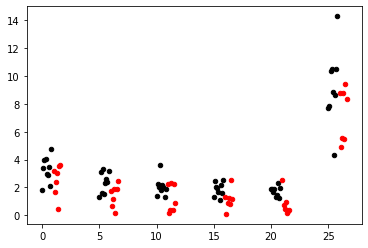

In [31]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['formation_lap'].loc[mask ]
        ax.scatter(5*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['formation_lap'].loc[mask ]
        ax.scatter(5*day+.1*m + 1, np.nanmean(shifts), color='red', s=20)
    

In [32]:
lmm_res = MixedLM(df_shifts['field_var'], df_shifts[['ko', 'dz', 'ko_x_dz','nov', 'intercept']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: field_var  
No. Observations: 81974   Method:             REML       
No. Groups:       16      Scale:              0.0004     
Min. group size:  2018    Log-Likelihood:     205274.1018
Max. group size:  7409    Converged:          Yes        
Mean group size:  5123.4                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko            -0.000    0.003  -0.195 0.845 -0.005  0.004
dz            -0.004    0.000 -44.937 0.000 -0.004 -0.004
ko_x_dz        0.002    0.000  14.767 0.000  0.002  0.002
nov            0.018    0.000 123.973 0.000  0.017  0.018
intercept      0.047    0.002  28.304 0.000  0.044  0.050
Group Var      0.000    0.000                            



/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Index(['mouse', 'm', 'day', 'dz', 'ko', 'nov', 'nov_x_dz', 'ko_x_dz',
       'ko_x_nov', 'ko_x_nov_x_dz', 'shifts', 'width', 'formation_lap',
       'init_speed', 'init_speed_x_ko', 'speed', 'ko_x_speed', 'field_var',
       'intercept'],
      dtype='object')
             names  coef    se      T  pval   r2  adj_r2  CI[2.5%]  CI[97.5%]
0        Intercept -0.32  0.03 -12.50   0.0  0.0     0.0     -0.36      -0.27
1  init_speed_x_ko  0.09  0.08   1.04   0.3  0.0     0.0     -0.08       0.25
2       init_speed -0.59  0.10  -6.08   0.0  0.0     0.0     -0.79      -0.40
(7013, 19) -0.06791767277373527 1.2465478277865014e-08
(4571, 19) -0.027220706143675173 0.06573785235517378


Text(0, 0.5, 'COM shift')

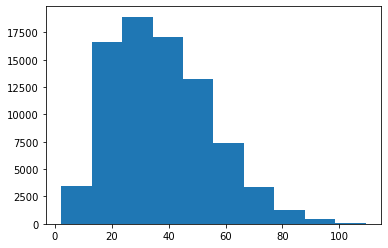

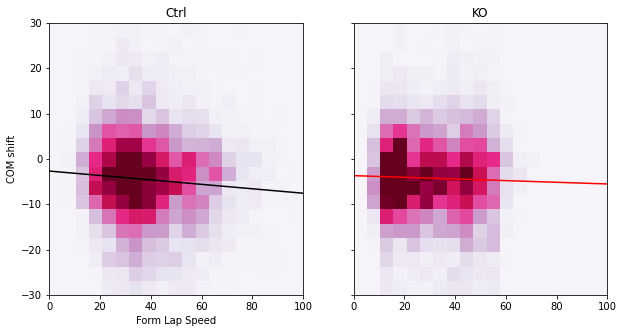

In [49]:
fig, ax = plt.subplots()


df_ = df_shifts[(df_shifts['day']==0) & (df_shifts['init_speed']>0.05)]
print(df_.columns)
res = linear_regression(df_[ ['init_speed_x_ko','init_speed']], df_['shifts'])
print(res.round(2))

ax.hist(10*15.46*df_shifts['init_speed'])

fig, ax = plt.subplots(1,2,figsize=[10,5], sharey=True, sharex=True)
ctrl_df = df_shifts[(df_shifts['ko']==0) & (df_shifts['day']==0) & (df_shifts['init_speed']>0.05) ]
ax[0].hist2d(10*15.46*ctrl_df['init_speed'], 10*ctrl_df['shifts'], bins=(np.linspace(0,100,num=20),np.linspace(-30,30,num=20)),density=True,vmax=.001, cmap = 'PuRd') #, color='black')

res = sp.stats.linregress(10*15.46*ctrl_df['init_speed'],10*ctrl_df['shifts'])
x = np.linspace(0,100)
ax[0].plot(x,res.slope*x + res.intercept, color='black')

r,p = sp.stats.pearsonr(10*15.46*ctrl_df['init_speed'],10*ctrl_df['shifts'])
# r,p = sp.stats.spearmanr(ctrl_df['init_speed'],ctrl_df['shifts'])
print(ctrl_df.shape,r,p)

# fig, ax = plt.subplots()
ko_df = df_shifts[(df_shifts['ko']==1) & (df_shifts['day']==0) & (df_shifts['init_speed']>0.05)]
ax[1].hist2d(10*15.46*ko_df['init_speed'],10*ko_df['shifts'], bins=(np.linspace(0,100,num=20),np.linspace(-30,30,num=20)), density=True, vmax=.001,cmap = 'PuRd') #, color='red')
r,p = sp.stats.pearsonr(10*15.46*ko_df['init_speed'],10*ko_df['shifts'])
# r,p = sp.stats.spearmanr(ko_df['init_speed'],ko_df['shifts'])

res = sp.stats.linregress(10*15.46*ko_df['init_speed'], 10*ko_df['shifts'])
x = np.linspace(0,100)
ax[1].plot(x,res.slope*x + res.intercept, color='red')
print(ko_df.shape,r,p)

ax[0].set_title('Ctrl')
ax[1].set_title('KO')
ax[0].set_xlabel('Form Lap Speed')
ax[0].set_ylabel('COM shift')
# fig.savefig(os.path.join(figdir,"initspeed_vs_shifts_day0.pdf"))

0
[0.         0.03157895 0.06315789 0.09473684 0.12631579 0.15789474
 0.18947368 0.22105263 0.25263158 0.28421053 0.31578947 0.34736842
 0.37894737 0.41052632 0.44210526 0.47368421 0.50526316 0.53684211
 0.56842105 0.6       ] [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
0.22176955674686066 7.124973503442517e-79
0.21799647359105936 2.6627563009082054e-50


Text(0, 0.5, 'width')

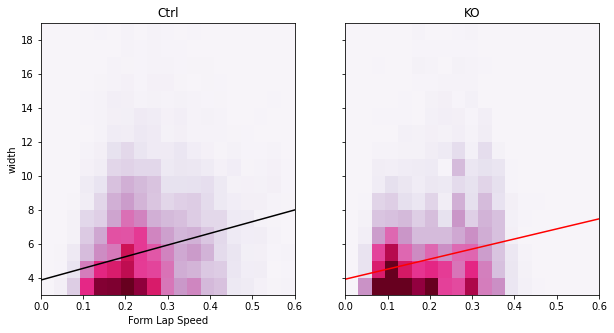

In [35]:
fig, ax = plt.subplots(1,2,figsize=[10,5], sharey=True, sharex=True)
ctrl_df = df_shifts[(df_shifts['ko']==0) & (df_shifts['day']==0) & (df_shifts['init_speed']>0.05)]
h, xedges, yedges, _ = ax[0].hist2d(ctrl_df['init_speed'], ctrl_df['width'], bins=(np.linspace(0,.6,num=20),np.arange(3,20)),density=True, vmax = 1, cmap = 'PuRd') #, color='black')
print(np.isnan(h).sum())
print(xedges, yedges)

res = sp.stats.linregress(ctrl_df['speed'],ctrl_df['width'])
x = np.linspace(0,.6)
ax[0].plot(x,res.slope*x + res.intercept, color='black')

r,p = sp.stats.pearsonr(ctrl_df['speed'],ctrl_df['width'])
r,p = sp.stats.spearmanr(ctrl_df['speed'],ctrl_df['width'])
print(r,p)

# fig, ax = plt.subplots()
ko_df = df_shifts[(df_shifts['ko']==1) & (df_shifts['day']==0)& (df_shifts['init_speed']>0.05)]
ax[1].hist2d(ko_df['init_speed'],ko_df['width'], bins=(np.linspace(0,.6,num=20),np.arange(3,20)), density=True, vmax=1, cmap = 'PuRd') #, color='red')
r,p = sp.stats.pearsonr(ko_df['speed'],ko_df['width'])
r,p = sp.stats.spearmanr(ko_df['speed'],ko_df['width'])

res = sp.stats.linregress(ko_df['speed'], ko_df['width'])
x = np.linspace(0,.6)
ax[1].plot(x,res.slope*x + res.intercept, color='red')
print(r,p)

ax[0].set_title('Ctrl')
ax[1].set_title('KO')
ax[0].set_xlabel('Form Lap Speed')
ax[0].set_ylabel('width')
# fig.savefig(os.path.join(figdir,"initspeed_vs_width.pdf"))

In [40]:
speed_z = sp.stats.zscore(df_shifts['init_speed']._values)
df_shifts['init_speed'] = speed_z
df_shifts['init_speed_x_ko'] = speed_z*df_shifts['ko']._values
speed_z = sp.stats.zscore(df_shifts['speed']._values)
df_shifts['speed'] = speed_z
df_shifts['ko_x_speed'] = speed_z*df_shifts['ko']._values
lmm_res = MixedLM(df_shifts['width'], df_shifts[['ko', 
                                                 'dz', 
                                                 'ko_x_dz',
                                                 'init_speed', 
                                                 'init_speed_x_ko',
#                                                  'speed',
#                                                  'ko_x_speed',
                                                 'intercept']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())



          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: width       
No. Observations: 81974   Method:             REML        
No. Groups:       16      Scale:              7.2006      
Min. group size:  2018    Log-Likelihood:     -197272.2400
Max. group size:  7409    Converged:          Yes         
Mean group size:  5123.4                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
ko              -0.427    0.108 -3.969 0.000 -0.638 -0.216
dz               0.065    0.012  5.271 0.000  0.041  0.089
ko_x_dz         -0.087    0.019 -4.498 0.000 -0.124 -0.049
init_speed       0.584    0.012 48.496 0.000  0.560  0.607
init_speed_x_ko  0.215    0.024  9.090 0.000  0.168  0.261
intercept        5.811    0.071 81.815 0.000  5.671  5.950
Group Var        0.044    0.006                           



2.669383421480665 0.0076096018781027135
12.146465586410429 9.060544477869095e-34
7.307041774017994 2.8768469428038027e-13
9.787554704735133 1.5032546827449443e-22
11.186978771727034 6.450831017927376e-29
9.837117041180816 9.02359331966001e-23


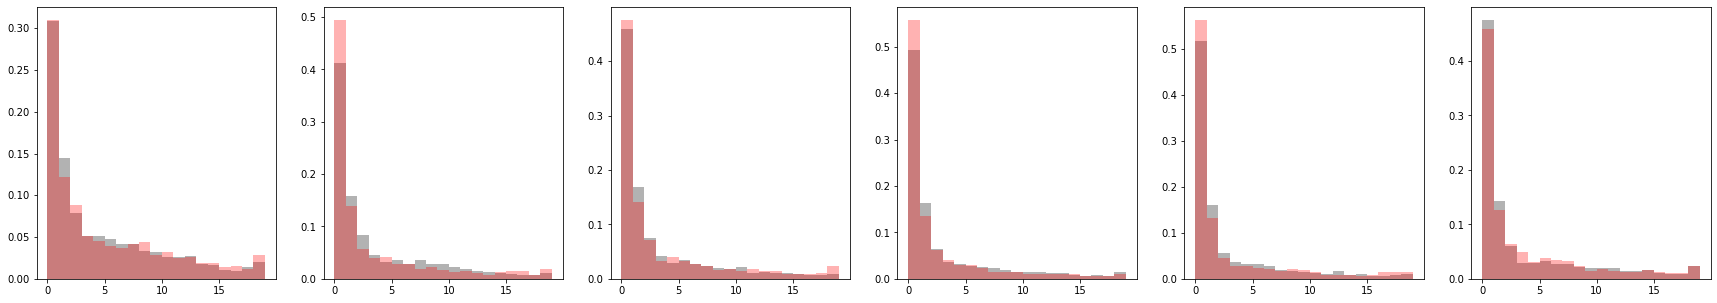

In [37]:
fig,ax = plt.subplots(1,6, figsize = [30,5])

bins = np.arange(20)
for day in range(6):
    ax[day].hist(df_shifts['formation_lap'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) ],
                 bins = bins, color = 'black', alpha = .3, density=True)
    ax[day].hist(df_shifts['formation_lap'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day)],
                 bins = bins, color = 'red', alpha = .3, density=True)
    t,p = sp.stats.ttest_ind(df_shifts['formation_lap'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day)],
                             df_shifts['formation_lap'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day)])
    print(t,p)

In [38]:
lmm_res = MixedLM(df_shifts['formation_lap'], df_shifts[['ko', 'dz', 'ko_x_dz']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: formation_lap
No. Observations: 81974   Method:             REML         
No. Groups:       16      Scale:              420.1748     
Min. group size:  2018    Log-Likelihood:     -363960.5038 
Max. group size:  7409    Converged:          Yes          
Mean group size:  5123.4                                   
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
ko           9.465     3.796    2.493  0.013   2.024  16.905
dz          -2.456     0.094  -26.245  0.000  -2.639  -2.272
ko_x_dz      0.152     0.146    1.040  0.299  -0.135   0.439
Group Var  100.778     1.754                                



In [42]:
aov = mixed_anova(data = df_shifts[df_shifts['nov'] == 0], dv = 'formation_lap', between = 'ko', within= 'day', subject = 'm')
print(aov)

        Source           SS  DF1  DF2          MS          F         p-unc  \
0           ko   625.968114    1   14  625.968114   8.081320  1.303455e-02   
1          day  2269.594508    5   70  453.918902  37.397328  1.763875e-18   
2  Interaction   128.280376    5   70   25.656075   2.113745  7.383639e-02   

        np2       eps  
0  0.365980       NaN  
1  0.727612  0.704887  
2  0.131177       NaN  
